# **Challenge: Elo Merchant Category Recommendation** (Help understand customer loyalty)

## **Descripción del reto**

### **Introducción**



**Elo** es una de las marcas de pago más grandes de Brasil, ha establecido alianzas con comerciantes para ofrecer promociones o descuentos a los titulares de tarjetas. Su objetivo es identificar y atender las oportunidades mas relevantes para los clientes, al descubrir la señal de lealtad por medio de algoritmos de machine learning. Esto ayudará a mejorar la efectividad de las campañas y el servicio al cliente.

Para consultar el reto en kaggle se puede visitar el siguiente enlace:
 https://www.kaggle.com/c/elo-merchant-category-recommendation/data

### **Resumen Datasets**

El reto proporciona seis archivos cvs: el primero es un diccionario de términos donde se explica brevemente las características contenidas en los conjuntos de datos proporcionados, un conjunto de datos de entrenamiento y uno de prueba, adicionalmente proporciona dos conjuntos de datos con las transacciones de cada tarjeta de crédito y finalmente un conjunto de datos con las características de los comerciante. 

El nombre, la descripción y la dimensión de cada conjunto datos estudiado en este notebook se puede consultar en la siguiente tabla: 

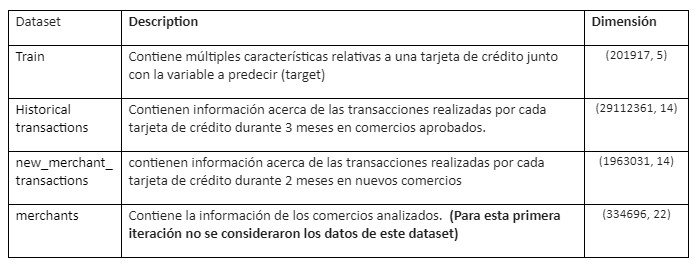

## **Instalacion de librerias y carga de datos**

### **Instalación de paquetes**

In [ ]:
## LPS & OSR: Instalación de librerias utilizadas en la lectura y exploración inicial de los datos.
from collections import Counter, defaultdict
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline
from matplotlib import pyplot 
from google.colab import files
import datetime

## LPS & OSR: Instalaciòn de paquetes de scikit-learn
from sklearn.pipeline import Pipeline                     
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Con el objetivo de automatizar la carga de archivos, se procede a clonar un repositorio Github que alberga los documentos necesarios para ejecutar el notebook. 

In [ ]:
# Instalando paquetes y creando el ambiente content
!git clone https://github.com/LuisPortela/ELO.git  #LPS & OSR: se clona el repostorio que alberga el documento json para hacer la lectura de datos directamente 
import zipfile                                     #           del API de kaggel
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/ELO"

Cloning into 'ELO'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 44 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


### **Creación de variables de entorno e instalación de Spark Context**

Teniendo en cuenta que el reto proporciona un conjunto de datos de gran volumen, se hace necesario implementar dentro del proyecto tecnicas de Big Data para exploración y manipulación del dataset. En este sentido, se crean los ambientes de Java y Spark, y se instalan los paquetes de SparkContext y  las funciones de Pyspark.

In [ ]:
# LPS & OSR: Instalación
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz 
!pip install -q findspark

#LPS & OSR: Creación de variables de Entorno de java y spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

# LPS & OSR:  Instalación paquetes de SparkContext
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate()

#LPS & OSR:Intalando funciones de Pyspark
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, isnull
from pyspark.sql.types import *
sqlCtx = SQLContext(sc)
from pyspark.sql import SQLContext
from pyspark.sql.functions import countDistinct, avg, max, col, struct, min, stddev, sum # Intentar con *

### **Carga de datos desde Kaggle**

Los conjuntos de datos proporcionados por el reto son cargando directamente desde el API de Kaggle a través de un token que es cargado desde la clonación del repositorio de Github

In [ ]:
# LPS & OSR: Estas lineas de codigo permiten descargar el conjunto de archivos del challenge ELO desde 
#            el API de kaggel y los almacena en la carpeta temporal "/content"
! kaggle competitions download -c elo-merchant-category-recommendation

 99% 611M/615M [00:21<00:00, 51.4MB/s]
100% 615M/615M [00:21<00:00, 30.5MB/s]


 ## **Lectura de los Data Set**

Debido a que se cuenta con multiples bases de datos, se busca hacer la intersección de los card_ID que estén presente en las distintas tablas suministradas por el concurso, es decir:  **Historical_Trasaction**,  **New_Merchant_Transaction** y **Train**. Lo anterior, con el proposito de de eliminar aquellos registros (**Cards_ID**) que no tienen asociado un valor de **Target**.

La metodología que se llevará a cabo es la siguiente:

* 1. Intersección de los elementos **card_ID** comunes presentes en las tablas **Train** y **New_Merchant_Transaction**.

* 2. Con las **card_ID**  resultantes de la etapa 1, se realizará la intersección con los registros de la base de datos **Historical_Trasaction**


### Etapa 1:  Intersección **Train** y **New_Merchant_Transaction**.


In [ ]:
#LPS & OSR: Descomprimiendo el archivo ZIP del dataset train obtenido del API de kaggle.
zip_ref = zipfile.ZipFile('elo-merchant-category-recommendation.zip', 'r')
zip_ref.extractall('/content') #LPS & OSR: este código extrae los datos de la carpeta anteriormente descomprimda
zip_ref.close()

In [ ]:
#LPS & OSR: Lectura del dataset train 
train=pd.read_csv("train.csv", sep=",")
train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913


In [ ]:
# LPS & OSR:  Lectura del dataset New merchants transactions 
new_merchants=pd.read_csv("new_merchant_transactions.csv", sep=",")
new_merchants.head(2) 

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19


In [ ]:
# LPS & OSR: Este código realiza la interseción entre los dataset new_merchants y trains 
new_merchants_join=new_merchants.merge(train , how='inner' ,on='card_id', indicator=True) #LPS & OSR: Se realiza el merge con inner con el objetivo de considerar las  filas con etiquetas comunes
                                                                                          #LPS & OSR: Indicador en true crea una columna que indica si la clave de fusión de la observación se encuentra en ambos DataFrames.

In [ ]:
## LPS & OSR: Visualización del dataframe resultante de la interseción entre new_merchants y train
new_merchants_join.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,_merge
0,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29,2016-08,1,1,0,-4.839243,both
1,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,1.0,9,16,2016-08,1,1,0,-4.839243,both


In [ ]:
## LPS & OSR: Se crea un Dataframe considerando unicamente las filas que tengan la etiqueta both en la columna de _merge obtenida del merge. 
new_merchants_join=new_merchants_join[new_merchants_join['_merge']=='both']

In [ ]:
## LPS & OSR: Se eliminan las columans provenientes de train adquiridas por defecto del proceso de train 
## LPS & OSR: Con este proceso del DataFrame -New_merchants se busca que tenga el número de columnas iniciales. 
new_merchants_join.drop(columns=['first_active_month','feature_1','feature_2','feature_3', 'target',	'_merge'], inplace=True)

In [ ]:
## LPS & OSR: Se realiza una validación del número de cards_id prsentes en los DataFrames train, new_merchants y  new_merchants_join
print(len(np.unique(train['card_id'])))
print(len(np.unique(new_merchants['card_id'])))
print(len(np.unique(new_merchants_join['card_id'])))

201917
290001
179986


Inicialmente el DataFrame New_merchants contaba con 290001 Caid_ID únicos, pero al verificar cuales de estos estaban calificados con una señal de lealtad, pudimos constatar que unicamente 179986 tenian señal de lealtad. 

Como resultado de la etapa_1 se obtiene el Dataframe **New_merchants_join**, el cual contiene los card_id unicos que están contenidos tanto en el conjunto de datos train como new_merchants.  De este proceso demás se reduce la dimensionalidad en filas del conjunto de datos New_merchants en un 37,8%.

In [ ]:
#LPS & OSR: Se crea un dataframe el cual contiene los card_id obtenidos del Dataframe New_merchants_join
DF_Card_ID=pd.DataFrame(data=np.unique(new_merchants_join['card_id']), columns=['card_id'])

In [ ]:
#LPS & OSR: Se constata que el nuevo dataframe contiene exactamente los caid_id unicos contenidos en new_merchants_join
len(np.unique(DF_Card_ID['card_id']))

179986

In [ ]:
#LPS & OSR: Se hace la intersección el Dataframe Train a partir de un merge con el parametro how=inner el cual filtrará solo  los card_id contenidos en DF_Card_ID
#LPS & OSR:
train_join=train.merge(DF_Card_ID , how='inner' ,on='card_id')

In [ ]:
# Se verifican las dimensiones del dataframe obtenido de la intersección entre train y DF_card_id
train_join.shape

(179986, 6)

En esta etapa se identifica la necesidad de construir la columna **elapsed_time** la cual explica el tiempo transcurido entre la fecha más actual de activación  menos el **first_active_month** de cada caid_id unico contenido en el DataFrame train_join. Esta característica esta representada en días. 

In [ ]:
#LPS&OSR: Se crean las columnas mencionadas anteriormente
train_join['first_active_month'] = pd.to_datetime(train_join['first_active_month'])
train_join['elapsed_time'] = (datetime.date(2018, 2, 1) - train_join['first_active_month'].dt.date).dt.days

### Etapa 2. Interseccion **DF_card_ID** y **Historical_Trasaction**

In [ ]:
#LPS & OSR: En estas lineas de código se crea el esquema que posteriormente se utilizará para crear el dataframe en Pyspark
##LPS & OSR: Adicionalmente cada variable fue esquematizada segun su Type. Los type fueron optimizados para ahorrar recurso computacional
schema = StructType() \
            .add("authorized_flag",StringType(),True)  \
            .add("card_id",StringType(),True)\
            .add("city_id",ShortType(),True) \
            .add("category_1",StringType(),True) \
            .add("installments",ShortType(),True) \
            .add("category_3",StringType(),True) \
            .add("merchant_category_id",ShortType(),True) \
            .add("merchant_id",IntegerType(),True) \
            .add("month_lag",FloatType(),True) \
            .add("purchase_amount",FloatType(),True)\
            .add("purchase_date",DateType(),True) \
            .add("Category_2",FloatType(),True) \
            .add("state_id",ShortType(),True) \
            .add("subsector_id",ShortType(),True)

In [ ]:
#LPS & OSR: Se carga el dataset utilizando el SQL context ya que el dataset requiere ser tratado con técnicas de big data
historical_transactions= sqlCtx.read.format("csv") \
      .option("header", True) \
      .option("delimiter", ",") \
      .schema(schema) \
      .load("historical_transactions.csv")

In [ ]:
##LPS & OSR: se registra la tabla temporal historical_transactions para posteriormente ser trabajada a través de Pyspark
historical_transactions.registerTempTable("historical_transactions")

In [ ]:
##LPS & OSR: Se crea el dataframe que contiene los Card_id unicos obtenidos en la etapa_1
DF_Card_ID=sqlCtx.createDataFrame(DF_Card_ID)
DF_Card_ID.show()

+---------------+
|        card_id|
+---------------+
|C_ID_00007093c1|
|C_ID_0001506ef0|
|C_ID_000183fdda|
|C_ID_0002c7c2c1|
|C_ID_0003be3c83|
|C_ID_00042d509c|
|C_ID_0004888ddd|
|C_ID_0004b68c49|
|C_ID_0004c2a5ab|
|C_ID_0005f16cc8|
|C_ID_0006152db8|
|C_ID_000616f4a8|
|C_ID_000664aa02|
|C_ID_00079fec55|
|C_ID_0007a60a33|
|C_ID_0007fe3157|
|C_ID_000844d8f1|
|C_ID_000950bc78|
|C_ID_00099cb909|
|C_ID_0009ae74c1|
+---------------+
only showing top 20 rows



In [ ]:
##LPS & OSR: se registra la tabla temporal DF_card_ID para posteriormente ser trabajada a traves de Pyspark
DF_Card_ID.registerTempTable("DF_Card_ID")

In [ ]:
##LPS & OSR: Se realiza la intersección entre el dataset Historical_transaction y DF_card_id
historical_transactions_join= historical_transactions.join(DF_Card_ID, on=["card_id"], how='inner')

In [ ]:
##LPS & OSR: Se registra  la tabla temporal histical_transaction_join
historical_transactions_join.registerTempTable("historical_transactions_join")

Como resultado de la **etapa_2** se obtiene el Dataframe historical_transaction_join, el cual contiene las transacciones contenidas en  tabla historical_transactio de los card_id identificados en la **etapa_1** . Del mismo modo se obtiene una reducción de dimensionalidad en filas del conjunto de datos historical_transaction del 42,35%.

 ## **Exploración de los Data Set**

Una vez que se hace la intersección de los conjuntos de datos, se procede hacer una análisis descriptivos de los conjuntos de datos: **Train_join, New_merchants_join y Historical_transaction_join**. Esto con el objetivo de recolectar y ordenar información de las variables de los conjuntos de datos. 

### 1 Dataset:  **Train_join**

#### **1.1. Descripcion del Dataset**

Este conjunto de datos fue suministrado  con tres
características categóricas anonimizadas: feature_1,
feature_2 y feature_3, además contiene el código unico de identificación de las tarjetas de los usuarios (card_id), la fecha de activación y la señal de lealtad calculada. 

Adicionalmente se integró a este conjunto de datos la variable elapsed_time que representa el tiempo trasncurrido desde la activación para cada card_i único. 


**1.1.1 Cantidad de datos**

In [ ]:
# LPS & OSR:  Se imprimen las dimensiones del dataframe
print("El DF train tiene", len(train_join.columns), "columnas y ", len(train_join.index), "filas")


El DF train tiene 7 columnas y  179986 filas


**1.1.2 Tipo de datos**

In [ ]:
# LPS & OSR: Exploración inicial de las variables del Dataset train
train_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179986 entries, 0 to 179985
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  179986 non-null  datetime64[ns]
 1   card_id             179986 non-null  object        
 2   feature_1           179986 non-null  int64         
 3   feature_2           179986 non-null  int64         
 4   feature_3           179986 non-null  int64         
 5   target              179986 non-null  float64       
 6   elapsed_time        179986 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 11.0+ MB


Inicialmente se puede evidenciar que el dataset esta compuesto por una variable tipo date, cuatro variables categoricas (entre ellas la variable clave card_ID) y una variable continua target (variable objetivo).

Ninguna de las columnas del dataset Train presenta muestras con datos nulos.

#### **1.2. Descripcion de variables**

Esta sección tiene como un objetivo realizar un analisis descriptivo de las variables contenidas en el conjunto de datos **Train_join**, con proposito de conocer sus distribuciones y las principales medidas de tendencia central.

 **1.2.1 Analisis univariable: Variables Cuantitativas y Variables Categóricas**

In [ ]:
#LPS&OSR: Se realiza la descripción del dataset train_join
train_join.describe()

,feature_1,feature_2,feature_3,target,elapsed_time
count,179986.000000,179986.000000,179986.000000,179986.000000,179986.000000
mean,3.098408,1.742135,0.562866,-0.443856,373.064311
std,1.188421,0.752006,0.496033,3.527220,290.278675
min,1.000000,1.000000,0.000000,-33.219281,31.000000
25%,2.000000,1.000000,0.000000,-0.928893,153.000000
50%,3.000000,2.000000,1.000000,-0.085816,306.000000
75%,4.000000,2.000000,1.000000,0.666257,488.000000
max,5.000000,3.000000,1.000000,17.675716,2284.000000


El puntaje de lealtad promedio representado por la variable **target** es de -0,44. Además, el rango del puntaje de lealtad para los clientes contenidos en este dataset se distribuye entre -33,21 y 17,67 puntos. También se puede evidenciar que la variable objetivo target, tiene un coeficiente de dispersión alto.

Para la variable **feature_1** se puede evidenciar inicialmente que el promedio de clientes está clasificado en 3,1. Además, el rango de esta variable se comprende entre 1 y 5. Igualmente para la variable **feature_2** la media de los clientes se encuentra entre 1,74, y la variable tiene un rango entre 1 y 3. Finalmente, la variable **feature_3 ** tiene una media de 0,56 y su rango está comprendido entre 0 y 1.

**Variables: feature_1, feature_2  y feature_3** **(Categorias Anonimas)**

Text(0.5, 1.0, 'feature_3')

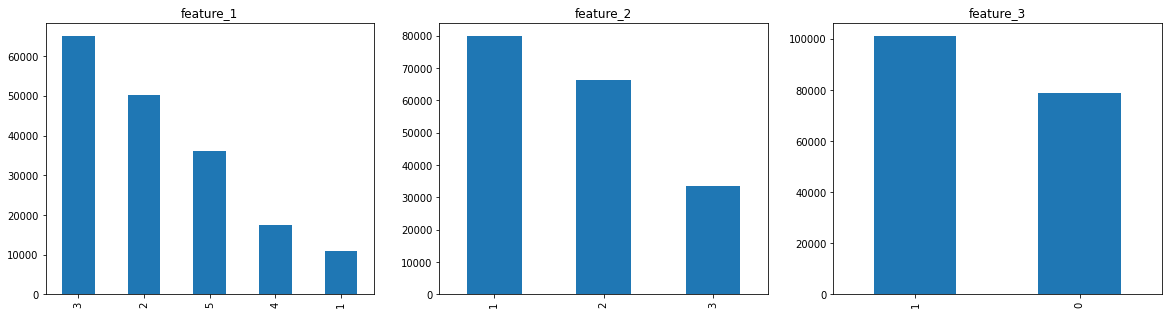

In [ ]:
# # LPS & OSR: Creación de histogramas para las variables Features
from matplotlib import pyplot
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
pd.value_counts(train_join.feature_1).plot(kind="bar")
plt.title('feature_1')

plt.subplot(1,3,2)
pd.value_counts(train_join.feature_2).plot(kind="bar")
plt.title('feature_2')

plt.subplot(1,3,3)
pd.value_counts(train_join.feature_3).plot(kind="bar")
plt.title('feature_3')


Los gráficos evidencian que aunque las variables tienen atributos con diferentes frecuencias,  no se presenta una predominancia importante en un atributo por lo cual inicialmente se puede considerar que las variables  pueden aportar información importante para describir la variable objetivo target.

Se puede visualizar que en la variable **feature_1** el atributo con más frecuencia es 3. Tambien se puede observar que aproximadamente el 65% de los clientes esta distribuido entre los atributos 3 y 2. Adicionalmente se puede apreciar que la frecuencia de los demás atributos va decreciendo gradualmente.

En la variable **feature_2** se puede evidenciar que el atributo que tiene más frecuencia es el 1, con aproximadamente 43,5% de los clientes, el abributo 2 contiene el 34,6 %de los clientes.

Para el **feature_3 **los datos entan distribuidos muy equitativamente sin embargo el abributo predimante es el atributo 1 con el 59% de los clientes clasificados con este atributos.

Text(0.5, 1.0, 'target')

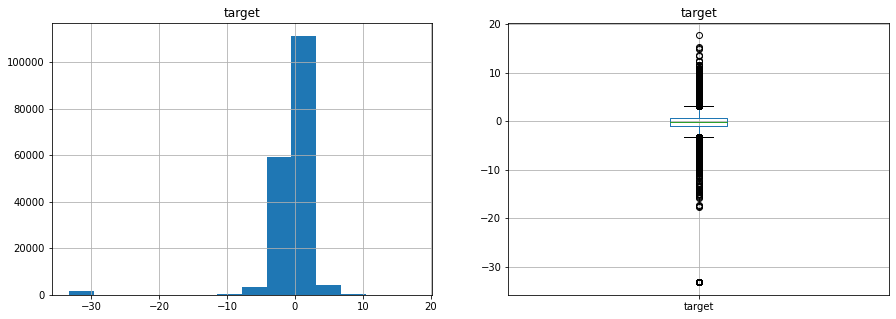

In [ ]:
# # LPS & OSR:Creación de histograma y boxplot de la variable target
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
train_join["target"].hist(bins=14)
plt.title('target')
plt.subplot(1,2,2)
train_join.boxplot(column="target")
plt.title('target')

Gráficamente se puede observar que los datos estan concentrados en su mayoría entre el intervalo -10 a 10. Además, se evidencia visualmente en el boxplot que el 50% de los datos contenidos entre el percentil  no están muy dispersos y se concentran en rangos cercanos a cero. Adicionalmente, se pueden visualizar presencia de outliers, presentando especial atención al rango -33 a -30 donde  se visualizam una cantidad notable de datos.  

**1.3.2 Variables cualitativas**

**Variable Card ID** 

In [ ]:
# LPS & OSR: Conteo de datos unicos para la variable Card ID. 
len(train_join.card_id.unique())
print("Cada cart_ID es unica en el Dataset de Train. Cuenta con",len(train_join.card_id.unique()), "ID's" )

Cada cart_ID es unica en el Dataset de Train. Cuenta con 179986 ID's


In [ ]:
#LPS&OSR: Se imprime el rango de la variable first_active_month
print("EL rango de la variable first_active_month se encuentre desde:", train_join.first_active_month.max(), "hasta:", train_join.first_active_month.min(),".Es decir, que el rango de activación es de aproximadamente de 8 años.")

EL rango de la variable first_active_month se encuentre desde: 2018-01-01 00:00:00 hasta: 2011-11-01 00:00:00 .Es decir, que el rango de activación es de aproximadamente de 8 años.


Los tiempos de antiguedad en las activaciones de las tarjetas de crédito son muy variados, sin embargo, el tiempo período de activación más antiguo es de 8 meses. 



### 2 Dataset: **New Merchants transactions join**

#### **2.1. Descripcion del Dataset**

Este conjunto de datos contiene la información transaccional de las  compras de los caid_id en un periodo de tiempo de dos meses, estas transacciones fueron hechas en los comercios que no fueron registrados en el conjunto de datos **Historical_transaction**. 

El dataset está conformado por 10 variables categoricas: caid_id, , authorized_flag, category_3, category_1, merchant_category_id, subsector_id, merchant_id, city_id, state_id  y category_2.  Adicionalmente tiene 3 variables númericas: month_lag,  installments y purchase_amount y una variable tipo date: purchase_date. 

**2.1.1 Cantidad de datos**

In [ ]:
# LPS & OSR: imprimiendo las dimensiones del dataset
print("El DF new_merchant_transactions tiene", len(new_merchants_join.columns), "columnas y ", len(new_merchants_join.index), "filas")
new_merchants_join.shape

El DF new_merchant_transactions tiene 14 columnas y  1219685 filas


(1219685, 14)

**2.1.2 Tipo de datos**

In [ ]:
# LPS & OSR: Exploración inicial de las variables del Dataset New_merchants_join
new_merchants_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1219685 entries, 0 to 1219684
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   authorized_flag       1219685 non-null  object 
 1   card_id               1219685 non-null  object 
 2   city_id               1219685 non-null  int64  
 3   category_1            1219685 non-null  object 
 4   installments          1219685 non-null  int64  
 5   category_3            1185001 non-null  object 
 6   merchant_category_id  1219685 non-null  int64  
 7   merchant_id           1203415 non-null  object 
 8   month_lag             1219685 non-null  int64  
 9   purchase_amount       1219685 non-null  float64
 10  purchase_date         1219685 non-null  object 
 11  category_2            1150634 non-null  float64
 12  state_id              1219685 non-null  int64  
 13  subsector_id          1219685 non-null  int64  
dtypes: float64(2), int64(6), object(6)

Inicialmente se puede evidenciar que el conjunto de datos tiene presencia de datos atipicos en  3 variables. 

**2.2.3 Control de datos nulos**

In [ ]:
# LPS & OSR: Identificación de columnas con nulos a través de un  ciclo for
columns_new_merchants_NA_value=0

# train
for column in new_merchants_join:  
  if new_merchants_join[column].isna().sum() != 0:
    columns_new_merchants_NA_value+=1

print("El DF new_merchants: De las",len(new_merchants_join.columns), "columnas del DF new_merchants hay", columns_new_merchants_NA_value, "columnas con elementos nulos")

El DF new_merchants: De las 14 columnas del DF new_merchants hay 3 columnas con elementos nulos


In [ ]:
# LPS & OSR: Conteo de datos nulos por característica del Dataset
new_merchants.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

Las variables donde hay  presencia de datos nulos son: **category_3** con el 4,5% de los datos nulos, **merchat_id** con el 2,1% de datos nulos y **Category_2** con el 9,1% de los datos nulos. Incialmente no se evidencia baja calidad en la información del dataset dado que la cantidad de datos nulos en las variables anteriores es muy bajo. 

#### **2.2. Descripcion de variables**

Esta sección tiene como un objetivo realizar un analisis descriptivo de las variables contenidas en el conjunto de datos **New_merchants**, con el proposito de conocer sus distribuciones y principales las medidas de tendencia central.

**2.2.1 Analisis univariable: Variables Cuantitativas**

In [ ]:
# LPS & OSR Visualización inicial de los datos del data set New_Merchants_join
new_merchants_join.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
1,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,1.0,9,16
2,Y,C_ID_ef55cf8d4b,69,N,1,B,333,M_ID_6d061b5ddc,1,5.263697,2018-03-28 19:50:19,1.0,9,10
3,Y,C_ID_ef55cf8d4b,231,N,1,B,307,M_ID_df1e022f41,2,-0.553787,2018-04-05 08:06:52,1.0,9,19
4,Y,C_ID_ef55cf8d4b,69,N,1,B,278,M_ID_d15eae0468,2,-0.596643,2018-04-07 18:37:40,1.0,9,37


**Purchase_amount** **(monto de la compra)**

In [ ]:
 # LPS & OSR Análisis descriptivo de la variable   Purchase_amounts
new_merchants_join.purchase_amount.describe()

count    1.219685e+06
mean    -5.521813e-01
std      6.598271e-01
min     -7.468928e-01
25%     -7.167646e-01
50%     -6.749458e-01
75%     -5.817664e-01
max      7.668290e+01
Name: purchase_amount, dtype: float64

La media del  monto de compra de las transacciones de este conjunto de datos es de -0,55. Adicionalmente la variable se encuentra en un rango entre 70.66  y -0,7. Del mismo modo, se verifica el coeficiente de dispersión y se obtiene un valor de -119,49, con lo que se puede concluir que los valores de esta variable están dispersos. 



Text(0.5, 1.0, '"purchase_amount"')

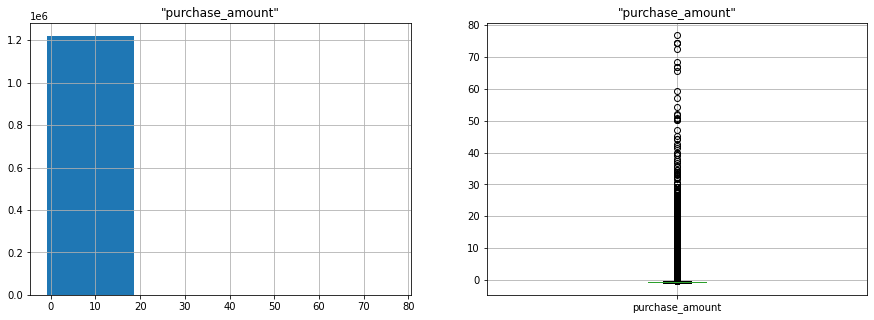

In [ ]:
# LPS & OSR: Se realiza histograma y boxplot para visualizar la distribución de los datos de la variable purchase_aumount. 

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
new_merchants_join["purchase_amount"].hist(bins=4)
plt.title('"purchase_amount"')
plt.subplot(1,2,2)
new_merchants_join.boxplot(column="purchase_amount")
plt.title('"purchase_amount"')

Gráficamente se puede evidencia que los datos estan distribuidos en un rango de aproximadamente entre -0.7 y 18.  Además, se puede evidenciar presencia de datos atípicos despues del cuartil 75. Adicionalmente,  se puede constatar que el 75% de los datos están por debajo de cero. 

**2.3.2 Variables cualitativas**

**Variables: Category_1, Category_2 y Category_3** **(Categorias anonimas)**

Text(0.5, 1.0, 'category_3')

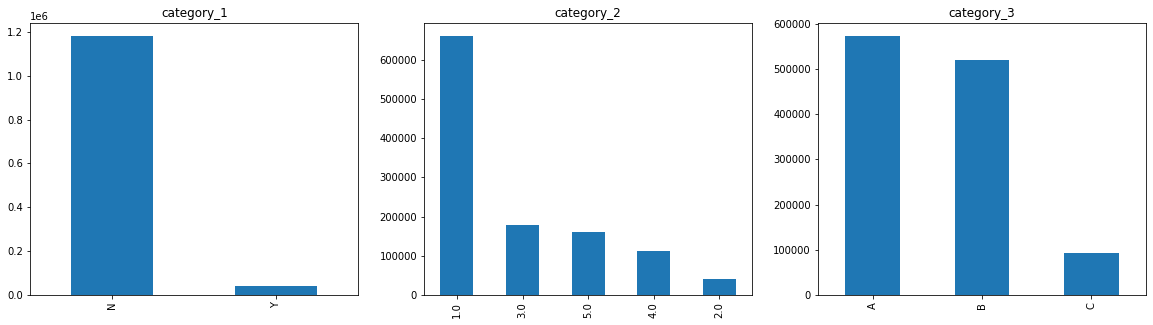

In [ ]:
# LPS & OSR: se realiza diagrama de barras para las variables category_1, category_2 y category_3 con el objetivo de revisar  la  distribución de los datos. 

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
pd.value_counts(new_merchants_join.category_1).plot(kind="bar")
plt.title('category_1')

plt.subplot(1,3,2)
pd.value_counts(new_merchants_join.category_2).plot(kind="bar")
plt.title('category_2')

plt.subplot(1,3,3)
pd.value_counts(new_merchants_join.category_3).plot(kind="bar")
plt.title('category_3')


Gráficiamente se puede observar que la variable **category_1** tiene un atributo dominante, inicialmnete se puede evidenciar que esta variable no aporta mucha variabilidad al conjunto de datos. 

Para variable **category_2** tiene una etiqueta dominante (1.0) que representa aproximadamente el 58% de los datos. Las demás etiquetas tienen una distribución uniforme entre ellas a excepción de la etiqueta (2.0) que tienen menos frecuencia. 

Considerando la variable **category_3** el 90% de sus datos estan distribuidos en la etique A y B.





Text(0.5, 1.0, 'authorized_flag')

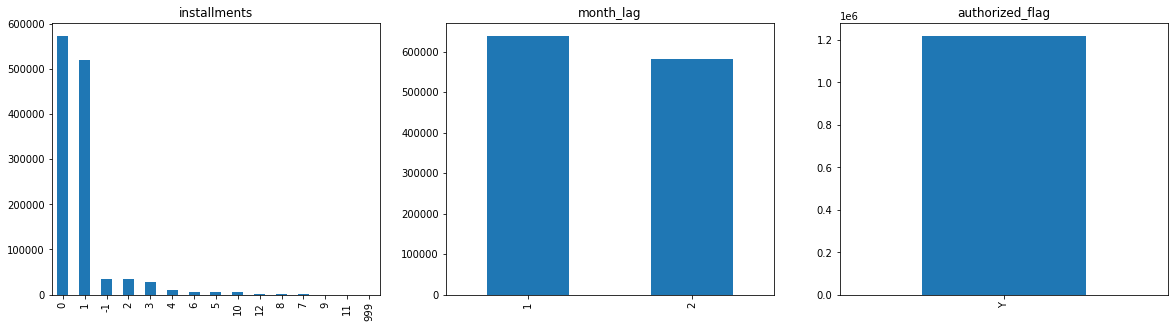

In [ ]:
# LPS & OSR: se realiza diagrama de barras para las variables installments, month_lag y authorized_flag con el objetivo de revisar  la  distribución de los datos.
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
pd.value_counts(new_merchants_join.installments).plot(kind="bar")
plt.title('installments')

plt.subplot(1,3,2)
pd.value_counts(new_merchants_join.month_lag).plot(kind="bar")
plt.title('month_lag')

plt.subplot(1,3,3)
pd.value_counts(new_merchants_join.authorized_flag).plot(kind="bar")
plt.title('authorized_flag')

Concerniente a la variable **installments** se puede visualizar que sus datos estan distribuidos en su mayoría entre las etiquetas 0 y 1, ahora bien, el resto de las etiquetas tienen menor frecuencia disminuyendo progresivamente. Es decir que los usuarios de tarjetas prefieren pagar sus compras a cortos plazos. 

En cuanto a la variable **month lag,** esta distribuida balanceadamente entre las etiquetas 1 y 2. Se puede concluir que los clientes de ELO generalmente tienen pocos meses de retraso. 

Con referencia a la variable **authorized_fag**, en el grafico se puede evidenciar que los datos están distribuidoros en la etiqueta Y, por ende, no aporta variabilidad a los datos. 


**Variables city_id, state_idy , merchant_id , merchant_category_Id y state_id y subsector_id**

In [ ]:
# LPS & OSR: se realiza el conteo de datos distintos de las variables (city_id,state_idy, merchant_id, merchant_category y state_id y subsector_id) con el objetivo de revisar que con cuantas caracteristicas de cada uno se cuenta. 
#LPS & OSR: se decide emplear este método dato que al tener tantas etiquetas, gráficamente no habría mucha información. 
print(new_merchants_join.card_id.name,":",len(new_merchants.card_id.unique()))
print(new_merchants_join.city_id.name,":",len(new_merchants.city_id.unique()))
print(new_merchants_join.merchant_id.name,":",len(new_merchants.merchant_id.unique()))
print(new_merchants_join.merchant_category_id.name,":",len(new_merchants.merchant_category_id.unique()))
print(new_merchants_join.state_id.name,":",len(new_merchants.state_id.unique()))
print(new_merchants_join.subsector_id.name,":",len(new_merchants.subsector_id.unique()))

card_id : 290001
city_id : 308
merchant_id : 226130
merchant_category_id : 314
state_id : 25
subsector_id : 41


Como se evidenció inicialmente la variable **card_id** tiene 290001 card IDS únicos. En cuanto la variable **city_id** las transacciones hechas por los usuarios de tarjetas de crédito están distribuidoras en 308 ciudades diferentes.  Referente a la variable **merchants_id**, se puede apreciar que las transacciones se hicieron en gran cantidad de comercios, 226130 en total.  Adicionalmente, la variable **merchant_category_id ** está distribuida en 314 etiquetas diferentes, es decir, que los usuarios de tarjeta de credito, hacen sus compras en diferentes sectores de comercio. 

También se puede constatar que la variable **state_id** tiene 25 datos únicos, dado que los datos fueron tomados en transacciones en la región de  Brasil se podria decir que las trasnacciones se realizarón en el 96% de los estados del País. 

Finalmente, la variable **subsector_id** tiene 41 datos únicos, lo cual es consecuente con los resultados de la variable merchant_category_id.




### 3 Dataset: **Historical transactions join**

Este conjunto de datos contiene la información transaccional de las compras de los caid_id en un periodo de tiempo de tres meses.

El dataset está conformado por 10 variables categoricas: caid_id,  authorized_flag, category_3, category_1, merchant_category_id, subsector_id, merchant_id, city_id, state_id y category_2. Adicionalmente tiene 3 variables númericas: month_lag, installments y purchase_amount y una variable tipo date: purchase_date.

In [ ]:
#LPS & OSR: Se persiste en memoria Cache el Dataframe historical_transaction. 
historical_transactions_join.cache()

DataFrame[card_id: string, authorized_flag: string, city_id: smallint, category_1: string, installments: smallint, category_3: string, merchant_category_id: smallint, merchant_id: int, month_lag: float, purchase_amount: float, purchase_date: date, Category_2: float, state_id: smallint, subsector_id: smallint]

In [ ]:
#LPS & OSR: Estas lineas de código ayudan a verificar que el Dataframe fue guardado en la memoria Cache. 
historical_transactions_join.is_cached

True

#### **3.1. Descripcion del Dataset**

**3.1.1 Cantidad de datos**

In [ ]:
##LPS & OSR imprimiendo el número de filas usando pypark SQL
filas =sqlCtx.sql("SELECT COUNT(card_id) as filas FROM historical_transactions_join")
filas.show()

+--------+
|   filas|
+--------+
|16782359|
+--------+



Inicialmente el  conjunto de datos cuenta con 16.782.359 muestras, que corresponden a las transacciones de 3 meses realizadas por los diferentes Card_ID (clientes) en los diferentes comercios aliados de ELO. 

In [ ]:
#LPS &OSR: Imprimiendo el número de columnas del data set
print("El Dataset historical_transactions_join tiene", len(historical_transactions_join.columns), "columnas.")

El Dataset historical_transactions_join tiene 14 columnas.


**3.2.2 Tipo de datos**

In [ ]:
# #LPS & OSR: Se imprime el esquema de las variables del dataset con el objetivo de comprobar el tipo de dato que adoptó cada variable
historical_transactions_join.printSchema()

root
 |-- card_id: string (nullable = true)
 |-- authorized_flag: string (nullable = true)
 |-- city_id: short (nullable = true)
 |-- category_1: string (nullable = true)
 |-- installments: short (nullable = true)
 |-- category_3: string (nullable = true)
 |-- merchant_category_id: short (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- month_lag: float (nullable = true)
 |-- purchase_amount: float (nullable = true)
 |-- purchase_date: date (nullable = true)
 |-- Category_2: float (nullable = true)
 |-- state_id: short (nullable = true)
 |-- subsector_id: short (nullable = true)



#### **3.2. Descripcion de variables**

Esta sección tiene como un objetivo realizar un análisis descriptivo de las variables contenidas en el conjunto de datos **Historical_transaction**, con propósito de conocer sus distribuciones y las principales medidas de tendencia central.

**3.2.1 Analisís Univariado**

**3.2.1.1 Variables cuantitativas**

**Installments (cuotas)**

In [ ]:
 #LPS & OSR: Se realiza el describe de al variable installments con el proposito de conocer el resumen de las estadisticas
installments= sqlCtx.sql("SELECT installments FROM historical_transactions_join")
installments.describe().show()

+-------+------------------+
|summary|      installments|
+-------+------------------+
|  count|          16782359|
|   mean|0.6384880099394846|
| stddev|2.6741054712672914|
|    min|                -1|
|    max|               999|
+-------+------------------+



La variable  **installments** tiene un promedio de 0,638 y está distribuida en un rango de datos entre -1 y 999. Cuenta con una alta dispersión. Se evidencia que se debe revisar los datos atipicos  ya que las etiqueta (999) cuotas no tienen sentido con el contexto del problema. 

+------------+-------+
|installments|  count|
+------------+-------+
|          -1| 104696|
|           0|8936714|
|           1|6698596|
|           2| 380371|
|           3| 306263|
|           4| 100237|
|           5|  65298|
|           6|  74177|
|           7|   6110|
|           8|  11637|
|           9|   3157|
|          10|  66186|
|          11|    465|
|          12|  28354|
|         999|     98|
+------------+-------+



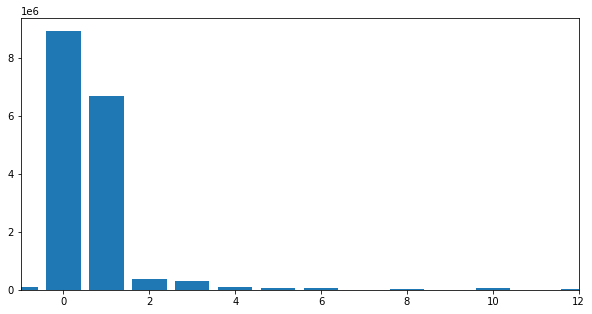

In [ ]:
#LPS & OSR: Se agrupan los valores de la variable installments para hacer un primer acercamiento a la distribución.
# se ordenan de menor a mayor. 

installments_count=historical_transactions_join.groupBy("installments").count()
installments_order=installments_count.orderBy("installments", ascending=True)
installments_order.show()
# Se convierten los valores a listas de panda con el objetivo de graficarlos con mayor facilidad
x_i=installments_order.toPandas()["installments"].values.tolist()
y_i=installments_order.toPandas()["count"].values.tolist()
# Se realiza un díagrama de barras con el propósito de visualizar las distribución de los datos. 
plt.figure(figsize=(10,5))
plt.bar(x_i,y_i)
plt.xlim(-1,12)
plt.show()



Se puede observar que la mayoría de datos de la variable **installments** variable estan concentrados entre  las etiquetas 0 y 1. Se puede concluir que la mayoria de usuarios de tarjeta de crédito optan por cancelar sus compras a menos de dos cuotas. 

**month_lag** **(Retraso en cuota de pago en meses)**

In [ ]:
#LPS & OSR: Se realiza el describe de la variable month_lag con el proposito de conocer el resumen de las estadísticas
month_lag= sqlCtx.sql("SELECT month_lag FROM historical_transactions_join")
month_lag.describe().show()

+-------+------------------+
|summary|         month_lag|
+-------+------------------+
|  count|          16782359|
|   mean|-4.435377648636881|
| stddev| 3.576113580176015|
|    min|             -13.0|
|    max|               0.0|
+-------+------------------+



El promedio de la variable **month_lag** es -4.43, y se encuentra en un rango de -13 a 0.  Con un coeficiente de dispersión del 80,6%. 

+---------+-------+
|month_lag|  count|
+---------+-------+
|     -2.0|2246065|
|     -1.0|2123642|
|      0.0|2042736|
|     -3.0|1795796|
|     -4.0|1519297|
|     -5.0|1357555|
|     -6.0|1171564|
|     -7.0|1010073|
|     -8.0| 809203|
|     -9.0| 695738|
|    -10.0| 609955|
|    -11.0| 565524|
|    -12.0| 445241|
|    -13.0| 389970|
+---------+-------+



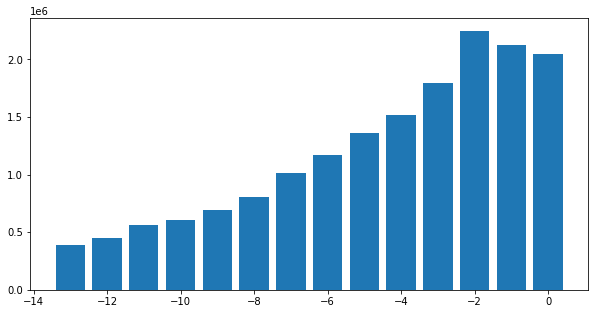

In [ ]:
#LPS & OSR: Se agrupan los valores de la variable month_lag  para hacer un primer acercamiento a la distribución.
# se ordenan de menor a mayor. 
month_lag_count=historical_transactions_join.groupBy("month_lag").count()
month_lag_count_order=month_lag_count.orderBy("count", ascending=False)
month_lag_count_order.show()
x_i=month_lag_count_order.toPandas()["month_lag"].values.tolist()
y_i=month_lag_count_order.toPandas()["count"].values.tolist()
plt.figure(figsize=(10,5))
plt.bar(x_i,y_i)
plt.show()

La distribución de la variable **month_lag** esta sesgada a la izquierda. Se puede observar que en la variable **month_lag** el valor con más frecuencia en la es -2. Adicionalmente, se puede observar a partir de la etiqueta -3 decrece la frecuencia a medida que decrecen gradualmente los valores de la variable. Se puede constatar que esta variable tiene unicamente datos en cero o  negativos.

**Purchase_amout** **(Monto de compra)**

In [ ]:
#LPS & OSR: Se emplea el sqlcontext para realizar un query que contenga unicamente los datos de la variable purchase amoung. Seguido de eso se realiza un describe para conocer las estadísticas.
purchase_amount=sqlCtx.sql("SELECT purchase_amount FROM historical_transactions_join")
purchase_amount.describe().show()
purchase_amount


+-------+-------------------+
|summary|    purchase_amount|
+-------+-------------------+
|  count|           16782359|
|   mean|0.15907445833937914|
| stddev| 1473.7583078068953|
|    min|         -0.7469078|
|    max|          6010604.0|
+-------+-------------------+



DataFrame[purchase_amount: float]

El promedio de la variable **purchase_amount** es 0,159 y se encuentra en un rango de -0,74 a  6010604. 

**3.2.1.2 Variables cualitativas** 


**Authorized_fla** **(autorización de la transacción)**

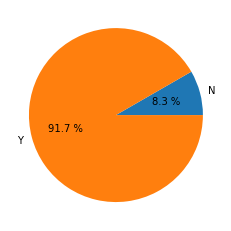

In [ ]:
##LPS & OSR: Se hace un agrupamiento por la variable authorized_fla  con el objtivo de contar la cantidad de datos por atributo.

authorized_fla_count=historical_transactions_join.groupBy("authorized_flag").count() 
authorized_fla_order=authorized_fla_count.orderBy("authorized_flag", ascending=True)
x=authorized_fla_order.toPandas()["authorized_flag"].values.tolist() #Se crea una lista apartir del dataframe para graficarlos.
y=authorized_fla_order.toPandas()["count"].values.tolist() 
plt.pie(y, labels=x,autopct="%0.1f %%") # muestra las frecuencias en porcentaje
plt.show()

Se puede observar que es una variable catégorica nominal, con la mayoria de los datos categorizados en "Y", representando  91,7% de los datos.

**card_id, city_id,  merchant_category_id, |merchant_id_unique**

In [ ]:
# #LPS & OSR: Se realiza la consulta a través del sql context para encontrar la cantidad de Card_ID diferentes en el dataset.

card_id = sqlCtx.sql("SELECT  COUNT(DISTINCT(card_id)) as Card_I_unique, COUNT(DISTINCT(city_id)) as City_I_unique , COUNT(DISTINCT(merchant_category_id)) as merchant_category_id_unique, COUNT(DISTINCT(merchant_id)) as merchant_id_unique FROM historical_transactions_join")
card_id.show() # mostrando el data set obtenido.


+-------------+-------------+---------------------------+------------------+
|Card_I_unique|City_I_unique|merchant_category_id_unique|merchant_id_unique|
+-------------+-------------+---------------------------+------------------+
|       179986|          308|                        323|                 0|
+-------------+-------------+---------------------------+------------------+



Como se evidenció inicialmente la variable **card_id_unique** tiene 179986 card IDS únicos. 

En cuanto la variable **city_id_unique** las transacciones hechas por los usuarios de tarjetas de crédito están distribuidoras en 308 ciudades diferentes. 

Adicionalmente, la variable **merchant_category_id_unique** está distribuida en 324 etiquetas diferentes, es decir, que los usuarios de tarjeta de credito compran productos clasificados en categorías muy variadas.

**category_1** **(Categoria anomina)**

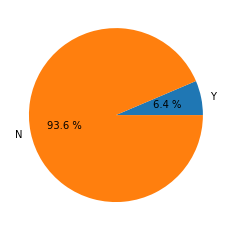

In [ ]:
##LPS & OSR: Se hace un agrupamiento por la variable Category_1  con el objtivo de contar la cantidad de datos por atributo.

category_1_count=historical_transactions_join.groupBy("category_1").count()
x=category_1_count.toPandas()["category_1"].values.tolist() #LPS &OSR: Se crea una lista apartir del dataframe para graficarlos.
y=category_1_count.toPandas()["count"].values.tolist()
plt.pie(y, labels=x,autopct="%0.1f %%") # LPS &OSR: crea el diagrama de torta  y muestra las frecuencias en porcentaje
plt.show()


Se puede visualizar  que  **category_1** es una variable catégorica nominal, con la mayoría de los datos categorizados en "N" representando un 93,6% de las muestras. 

**category_3** **(categoria anonima)**

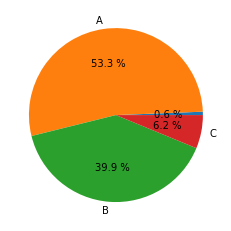

In [ ]:
###LPS & OSR: Se hace un agrupamiento por la variable Category_3  con el objtivo de contar la cantidad de datos por atributo.

category_3_count=historical_transactions_join.groupBy("category_3").count()
category_3_order=category_3_count.orderBy("category_3", ascending=True)
x=category_3_order.toPandas()["category_3"].values.tolist() # LPS&OSR: se convierte a lista con el objetivo de graficarlas
y=category_3_order.toPandas()["count"].values.tolist()
plt.pie(y, labels=x,autopct="%0.1f %%")#LPS&OSR;crea el diagrama de torta  y muestra las frecuencias en porcentaje
plt.show()

Como se puede visualizar en el gráfico de torta, **category_3** es una variable catégorica nominal, con el 53.3% de los datos categorizados en A . Adicionalmente se puede evidenciar que el pareto de las transacciones se encuentran consentrados entre la etiqueta  A y B. 


**Subsector_id**

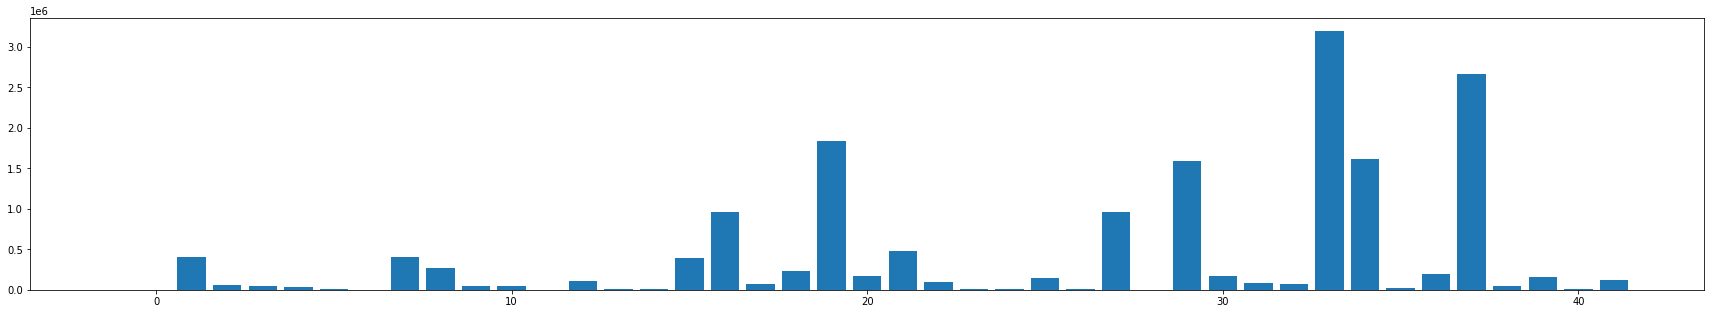

In [ ]:
###LPS & OSR: Se hace un agrupamiento por la variable Subsector con el objetivo de contar la cantidad de datos por atributo.

subsector_id_count=historical_transactions_join.groupBy("subsector_id").count()
subsector_id_count_order=subsector_id_count.orderBy("subsector_id", ascending=True)
x_s=subsector_id_count_order.toPandas()["count"].values.tolist()
y_s=subsector_id_count_order.toPandas()["subsector_id"].values.tolist()
plt.figure(figsize=(30,5))
plt.bar(y_s,x_s)
plt.show()

Como se puede evidenciar en la gráfica hay subsectores dominantes donde se puede observar que estan reunidas la mayoria de las muestras del dataset como son: subsector: 19, 29, 31 y  37. Generalmente los subsectores de compras son bastante variados. 

**State_Id**

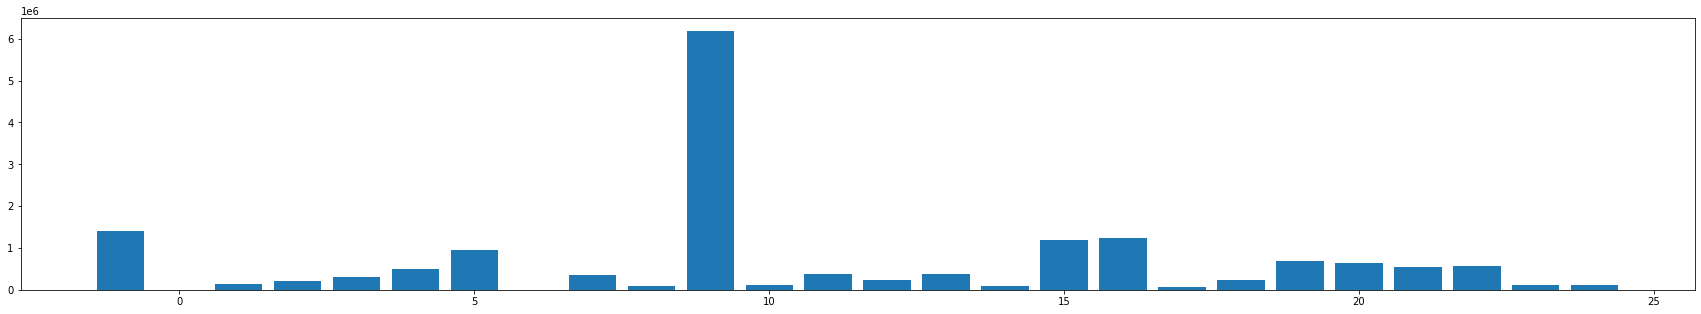

In [ ]:
###LPS & OSR: Se hace un agrupamiento por la variables tate_id con el objetivo de contar la cantidad de datos por atributo.
state_id_count=historical_transactions_join.groupBy("state_id").count()
state_id_count_order=state_id_count.orderBy("state_id", ascending=True)
x_s=state_id_count_order.toPandas()["count"].values.tolist()
y_s=state_id_count_order.toPandas()["state_id"].values.tolist()
plt.figure(figsize=(30,5))
plt.bar(y_s,x_s)
plt.show()

Con respecto a la variable **state_id**, la visualiación permite observar que las transacciones fueron hechas en diferentes estados del País, sin embargo,  el estado mas  marcado es aquel  etiquetado con 9; el cual tiene una frecuencia muy alta en comparación a los demás estados. 

También, se puede constatar que la variable state_id tiene 25 datos únicos, dado que los datos fueron tomados en transacciones en la región de Brasil se podria decir que las transacciones se realizarón en el 96% de los estados del País.

## **Construction del Dataset**

Teniendo que a partir de la etapa **Lectura de los Dataset** se obtuvieron 3 conjuntos de datos, es necesario construir un dataset que agrupe las variables obtenidas a partir de estos. 

Para la construcción del data set consolidado se realizarán las siguientes etapas:  

1. **Features Engineer Historical Transaction Join  y Features Engineer New Merchanst Join**  esta etapa consiste en la elaboración de features a partir del conjunto de datos Historical transaction join y New Merchants join , con el proposito de obtener variables nuevas que expliquen potencialmente la variable objetivo (Fidelidad). 

2. **Tratamiento de datos**, en esta etapa se realizará: 

* Análisis de correlacion y multicolinealidad
* Eliminación de variables.
* Identificación y eliminación de outliers.




### Features Engineer **Historical transactions**

In [ ]:
#LPS & OSR: Se crea una función llamada count_authorized_flag con el objetivo de convertir los valores Y en 1 y los valores N en 0 para posteriormente revisar el balance de la variable en cada card_id
def count_authorized_flag(authorized_flag):
	if authorized_flag == 'Y':
		return 1
	else:
		return 0

In [ ]:
#LPS & OSR: Se crea una función llamada count_category_1 con el objetivo de convertir los valores Y en 1 y los valores N  en 0.
def count_category_1(category_1):
	if category_1 == 'Y':
		return 1
	else:
		return 0

In [ ]:
#LPS & OSR: Se registran las funciones en el Sql spark context. 
sqlCtx.registerFunction("count_authorized_flag",count_authorized_flag)
sqlCtx.registerFunction("count_category_1",count_category_1)

<function __main__.count_category_1>

In [ ]:
#LPS & OSR: se hace una query con sql spark context donde se aplicarán las funciones que se crearon anteriormente.
historical_transactions_query = sqlCtx.sql("""SELECT card_id, count_authorized_flag(authorized_flag) as count_authorized_flag, city_id,
                                                      count_category_1(category_1) as count_category_1, 
                                                      month_lag, purchase_amount, installments, purchase_date, merchant_id, (datediff(current_date(),purchase_date)/30)+month_lag as  month_diff_hist
                                                      FROM historical_transactions_join""")

In [ ]:
#LPS & OSR: Se hace un casting de las variables del dataset ya que despues de aplicar la función registrada cambian los types. Este casting se hace hace  con el objetivo de clasificar las variables correctamente.
historical_transactions_query_int=historical_transactions_query.withColumn("count_authorized_flag",historical_transactions_query.count_authorized_flag.cast(ByteType())) \
                                                               .withColumn("count_category_1",historical_transactions_query.count_category_1.cast(ByteType()))\
                                                               .withColumn("month_lag",historical_transactions_query.month_lag.cast(IntegerType()))\
                                                               .withColumn("month_diff_hist",historical_transactions_query.month_diff_hist.cast(IntegerType()))

Con el objetivo de obtener potenciales variables que aporten a la correlación con la variable objetivo  se realizan agrupaciones por cada card_id de las variables cuantitativas del conjunto de datos **Historical_transaction_join.** 

Las principales agregaciones que se realizarán son : **avg, max y stddev**.

In [ ]:
# #LPS & OSR: se procede a hacer un agrupamiento de los valores a partir de la variable Caid_id
#las agregaciones que se hicieron en este código fueron experiementadas para que fueran las que más información le aportaran a la variable objetivo. 

historical_transactions_query_int_group_by= historical_transactions_query_int.groupby('card_id').agg((countDistinct("city_id")), \
                                                                                                     avg('count_authorized_flag'),\
                                                                                                     max('count_authorized_flag'),\
                                                                                                     stddev('count_authorized_flag'),\
                                                                                                     avg('count_category_1'), \
                                                                                                     max('count_category_1'), \
                                                                                                     sum('count_category_1'), \
                                                                                                     stddev('count_category_1'), \
                                                                                                     avg('purchase_amount'), \
                                                                                                     max('purchase_amount'), \
                                                                                                     sum('purchase_amount'), \
                                                                                                     stddev('purchase_amount'), \
                                                                                                     avg('installments'),\
                                                                                                     max('installments'),\
                                                                                                     sum('installments'),\
                                                                                                     stddev('installments'),\
                                                                                                     avg('month_lag'), \
                                                                                                     max('month_lag'), \
                                                                                                     stddev('month_lag'), \
                                                                                                     avg('month_diff_hist'), \
                                                                                                     max('month_diff_hist'), \
                                                                                                     stddev('month_diff_hist'), \
                                                                                                     max("purchase_date"),\
                                                                                                     min("purchase_date"))

Se decidió emplear el estadistico de la moda para las siguientes varibles, ya es el estadistico que potencialmente puede aportar más información en la  descripción de la variable objetivo.

1.   **subsector_id**
2.   **State_id**
3.   **Category_2**
4.   **category_3**

1.   **subsector_id**

In [ ]:
# #LPS & OSR: inicialmente se realiza un query con las variables caid_id y subsector id 
historical_transactions_mode_subsector_id = sqlCtx.sql("""SELECT card_id, subsector_id   
                                                      FROM historical_transactions_join""")

In [ ]:
# #LPS & OSR: se realiza un agrupamiento por caid_id con el conteo de subsectores
counts_subsector_id = historical_transactions_mode_subsector_id.groupBy(['card_id', 'subsector_id']).count().alias('counts')

In [ ]:
#LPS & OSR: con la variable counts_subsector_id se realiza un agrupamiento por caid_id, y se realiza un conjunto de funciones que nos permiten encontrar la moda de los subsectores en los caid_id (clientes)
result_subsector_id = (counts_subsector_id.groupBy('card_id').agg(max(struct(col('count'),col('subsector_id'))).alias('max')).select(col('card_id'), col('max.subsector_id')))

2.   **state_id**

In [ ]:
# #LPS & OSR: inicialmente se realiza un query con las variables caid_id y state_id
historical_transactions_mode_state_id = sqlCtx.sql("""SELECT card_id, state_id   
                                                      FROM historical_transactions_join""")

In [ ]:
## #LPS & OSR: : se realiza un agrupamiento por caid_id con el conteo de states.
counts_state_id = historical_transactions_mode_state_id.groupBy(['card_id', 'state_id']).count().alias('counts')

In [ ]:
#LPS & OSR: con la variable counts_state_id se realiza un agrupamiento por caid_id, y se realiza un conjunto de funciones que nos permiten encontrar la moda de los states en los caid_id (clientes)
result_state_id = (counts_state_id.groupBy('card_id').agg(max(struct(col('count'),col('state_id'))).alias('max')).select(col('card_id'), col('max.state_id')))

3.   **Category_2** **(categoria anonima)**

In [ ]:
# #LPS & OSR:se realiza un query con las variables caid_id y Category_2
historical_transactions_mode_Category_2 = sqlCtx.sql("""SELECT card_id, Category_2   
                                                      FROM historical_transactions_join""")

In [ ]:
## #LPS & OSR: : se realiza un agrupamiento por caid_id con el conteo de categoria2  
counts_Category_2 = historical_transactions_mode_Category_2.groupBy(['card_id', 'Category_2']).count().alias('counts')

In [ ]:
#LPS & OSR: con la variable counts_category_2_id se realiza un agrupamiento por caid_id, y se realiza un conjunto de funciones que nos permiten encontrar la moda de la categoria 2 en los caid_id (clientes)
result_Category_2 = (counts_Category_2.groupBy('card_id').agg(max(struct(col('count'),col('Category_2'))).alias('max')).select(col('card_id'), col('max.Category_2')))

4.   **category_3** **(categoria anonima)**

In [ ]:
#LPS & OSR:se realiza un query con las variables caid_id y Category_3
historical_transactions_mode_Category_3 = sqlCtx.sql("""SELECT card_id, category_3   
                                                      FROM historical_transactions_join""")

In [ ]:
## #LPS & OSR: : se realiza un agrupamiento por caid_id con el conteo de category_3
counts_Category_3 = historical_transactions_mode_Category_3.groupBy(['card_id', 'category_3']).count().alias('counts')

In [ ]:
#LPS & OSR:: con la variable counts_Category_3  se realiza un agrupamiento por caid_id, y se realiza un conjunto de funciones que nos permiten encontrar la moda de la categoria 3 en los caid_id (clientes)
result_Category_3 = (counts_Category_3.groupBy('card_id').agg(max(struct(col('count'),col('category_3'))).alias('max')).select(col('card_id'), col('max.category_3')))

**5. Merchant_id**

In [ ]:
#LPS & OSR:se realiza un query con las variables caid_id y merchant_id
historical_transactions_mode_merchant_id = sqlCtx.sql("""SELECT card_id,  merchant_id  
                                                      FROM historical_transactions_join""")

In [ ]:
## #LPS & OSR: : se realiza un agrupamiento por caid_id con el conteo de merchant_id
counts_merchant_id = historical_transactions_mode_merchant_id.groupBy(['card_id', 'merchant_id']).count().alias('counts')

In [ ]:
#LPS & OSR:: con la variable counts_merchants_id se realiza un agrupamiento por caid_id, y se realiza un conjunto de funciones que nos permiten encontrar la moda de la categoria 3 en los caid_id (clientes)

result_merchant_id = (counts_merchant_id.groupBy('card_id').agg(max(struct(col('count'),col('merchant_id'))).alias('max')).select(col('card_id'), col('max.merchant_id')))

Creación del dataset **DF_historical_pd**

Este conjunto de datos es el resultado de la unión del dataset **DF_join** (obtenido a partir de la agrupación de las variables cuantitativas) con los features de las varibles cualitativas. 

In [ ]:
##LPS & OSR Se realiza un primer join de las variables que fueron tratadas anterior mente, usando la variable clave card_id
DF_join=result_subsector_id.join(result_state_id, ["card_id"]).join(result_Category_2, ["card_id"]).join(result_Category_3, ["card_id"])

In [ ]:
# #LPS & OSRSe  construye la tabla comprendida con el dataset DF.join unido con el dataset historical_transactions_query_int_group_by usando la variable clave card_id
DF_historical=DF_join.join(historical_transactions_query_int_group_by, ["card_id"])

In [ ]:
##LPS & OSR Se convierte el dataframe en sqlcontext a un dataframe en  pandas
DF_historical_pd = DF_historical.toPandas()

In [ ]:
#LPS & OSR: se guarda el nuevo data set de pandas en un archivo cvs en la carpeta de archivos locales. 
DF_historical_pd.to_csv("DF_historical.csv")

Como resultado de esta etapa se obtiene un dataset llamado "DF_historical" que contiene la agregación de las variables del dataset **Historical_transations_join.**  

### Features Engineer **New Merchants** 

In [ ]:
# LSP & OSR: Se realiza el primer informe de datos del dataframe new_merchants_join.
new_merchants_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1219685 entries, 0 to 1219684
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   authorized_flag       1219685 non-null  object 
 1   card_id               1219685 non-null  object 
 2   city_id               1219685 non-null  int64  
 3   category_1            1219685 non-null  object 
 4   installments          1219685 non-null  int64  
 5   category_3            1185001 non-null  object 
 6   merchant_category_id  1219685 non-null  int64  
 7   merchant_id           1203415 non-null  object 
 8   month_lag             1219685 non-null  int64  
 9   purchase_amount       1219685 non-null  float64
 10  purchase_date         1219685 non-null  object 
 11  category_2            1150634 non-null  float64
 12  state_id              1219685 non-null  int64  
 13  subsector_id          1219685 non-null  int64  
dtypes: float64(2), int64(6), object(6)

In [ ]:
#LSP & OSR: Se realiza un casting de la variable purchase_date con el objetivo de manipularla con el tipo de dato date.
new_merchants_join["purchase_date"]=new_merchants_join["purchase_date"].astype('datetime64[ns]')

In [ ]:
# LSP &OSR: Se crea la variable month con el objetivo de conocer la diferenica entre la fecha de compra y la fecha actual
#LSP & OSR: La variable esta dada en meses
new_merchants_join['month_diff'] = ((datetime.datetime.today() - new_merchants_join['purchase_date']).dt.days)//30
#LSP &OSR: Esta linea de codigo le suma la variable month_lag
new_merchants_join['month_diff'] += new_merchants_join['month_lag']

In [ ]:
# LSP &OSR: Se identifican las variables cualitativas del dataset y se hace un casting para que obtengan el tipo de dato: Category
new_merchants_join["city_id"]=new_merchants_join["city_id"].astype('category')
new_merchants_join["category_3"] = new_merchants_join["category_3"].astype('category')
new_merchants_join["merchant_category_id"] = new_merchants_join["merchant_category_id"].astype('category')
new_merchants_join["category_2"] = new_merchants_join["category_2"].astype('category')
new_merchants_join["state_id"] = new_merchants_join["state_id"].astype('category')
new_merchants_join["subsector_id"] = new_merchants_join["subsector_id"].astype('category')

In [ ]:
# LPS &OSR: Se sustituyen los valores de la variable authorized flag con el objetivo de que las etiquetas sean explicadas por 0 y 1. 
new_merchants_join['authorized_flag']=new_merchants_join['authorized_flag'].apply(lambda x: 1 if x=='Y' else 0)

In [ ]:
# LPS & OSR: Se sustituyen los valores de la variable card_id con el objetivo de que las etiquetas sean explicadas por 0 y 1. 
new_merchants_join['category_1']=new_merchants_join['category_1'].apply(lambda x: 1 if x=='Y' else 0)

In [ ]:
#LPS & OSR: Este código agrupa las variables cuantitativas en 4 funciones de agregación: mean, max, std y sum.
#LPS & OSR: Adicionalmmente a las variables cualitativas las agrupa con el estadistico moda.
new_merchants_join_GB=new_merchants_join.groupby('card_id', as_index=False).agg({
                                                                                'city_id': "nunique",\
                                                                                'authorized_flag': (np.mean,np.max, np.std),\
                                                                                'category_1': (np.max,  np.std),\
                                                                                'purchase_amount': (np.mean,np.max,  np.std, np.sum),\
                                                                                'installments': (np.mean,np.max,  np.std),\
                                                                                'month_lag': (np.mean,np.max, np.std),\
                                                                                'month_diff': (np.mean,np.max,  np.std),\
                                                                                'purchase_date': (np.max, np.min),\
                                                                                'category_2':lambda x: stats.mode(x)[0][0],\
                                                                                'category_3':lambda x: stats.mode(x)[0][0],\
                                                                                'subsector_id':lambda x: stats.mode(x)[0][0],\
                                                                                'state_id':lambda x: stats.mode(x)[0][0],\
                                                                                'merchant_id':lambda x: stats.mode(x)[0][0],\
                                                                                })

In [ ]:
#LPS & OSR: Estas lineas de código permite nombrar las columnas del data set new_merchants_join_GB 
new_merchants_join_GB.columns = ["_".join(pair) for pair in new_merchants_join_GB.columns]

In [ ]:
#LPS & OSR: Se verifica la información del dataset new_merchants_join_GB
new_merchants_join_GB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179986 entries, 0 to 179985
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   card_id_               179986 non-null  object        
 1   city_id_nunique        179986 non-null  int64         
 2   authorized_flag_mean   179986 non-null  float64       
 3   authorized_flag_amax   179986 non-null  int64         
 4   authorized_flag_std    153199 non-null  float64       
 5   category_1_amax        179986 non-null  int64         
 6   category_1_std         153199 non-null  float64       
 7   purchase_amount_mean   179986 non-null  float64       
 8   purchase_amount_amax   179986 non-null  float64       
 9   purchase_amount_std    153199 non-null  float64       
 10  purchase_amount_sum    179986 non-null  float64       
 11  installments_mean      179986 non-null  float64       
 12  installments_amax      179986 non-null  int6

In [ ]:
#LPS & OSR: En estas lineas de código se hace un casting de las variables obtenidas de la agrupación de las variables cualitativas, el objetivo es convertirlas en tipo object
new_merchants_join_GB['category_2_<lambda>'] = new_merchants_join_GB['category_2_<lambda>'].astype('object')
new_merchants_join_GB['category_3_<lambda>'] = new_merchants_join_GB['category_3_<lambda>'].astype('object')
new_merchants_join_GB['subsector_id_<lambda>'] = new_merchants_join_GB['subsector_id_<lambda>'].astype('object')
new_merchants_join_GB['state_id_<lambda>'] = new_merchants_join_GB['state_id_<lambda>'].astype('object')
new_merchants_join_GB['merchant_id_<lambda>'] = new_merchants_join_GB['merchant_id_<lambda>'].astype('object')

In [ ]:
#LPS & OSR: Se verifica las dimensiones del data set new_merchants_join_GB.shape
new_merchants_join_GB.shape

(179986, 27)

In [ ]:
#LPS & OSR: Se renombra la variable card_id_ por card_id
new_merchants_join_GB.rename(columns={'card_id_': 'card_id'}, inplace=True)

### **Unificación de Datasets**

Una vez se ha realizado el tratamiento de los datos se procede a unificar los data set resultantes.

Inicialmente se uniran los dataset **new_merchants_join_GB y train_join**

In [ ]:
#LPS & OSR: Este código unifica con un inner join los conjuntos de datos New_merchants_join_GB y train_join.
DF_New_Train= new_merchants_join_GB.merge(train_join , how='inner' ,on='card_id')

In [ ]:
# LPS & OSR: Se hace un casting de las variables features provenientes del data set train ya que al hacer el join pierde el tipo de dato: category.
DF_New_Train['feature_1'] = DF_New_Train['feature_1'].astype('category')
DF_New_Train['feature_2'] = DF_New_Train['feature_2'].astype('category')
DF_New_Train['feature_3'] = DF_New_Train['feature_3'].astype('category')

In [ ]:
# LPS & OSR: Se hace un casting de las variables cualitativas category_2, category_3, subsector_id y state_id, el tipo de dato obtenido despues del casting es object
DF_historical_pd['Category_2'] = DF_historical_pd['Category_2'].astype('object')
DF_historical_pd['category_3'] = DF_historical_pd['category_3'].astype('object')
DF_historical_pd['subsector_id'] = DF_historical_pd['subsector_id'].astype('object')
DF_historical_pd['state_id'] = DF_historical_pd['state_id'].astype('object')

In [ ]:
#LPS & OSR: Este código unifica con un inner join los conjuntos de DF_historical_pd y DF_New_Train
DF_VF= DF_historical_pd.merge(DF_New_Train , how='inner' ,on='card_id')

Una vez unificados los dataset se complementa el conjunto de datos resultante con las siguientes columnas: 

* Diff_max_min_hist
* Diff_max_min_new
* Ratio_purchase_amount

In [ ]:
#LPS & OSR: Este código crea dos nuevas columnas, que explican  la diferencia entre la fecha máxima de compra vs la mínima, para su respectivo data set
DF_VF["Diff_max_min_hist"] = (DF_VF["max(purchase_date)"] -DF_VF["min(purchase_date)"]).dt.days 
DF_VF["Diff_max_min_new"] = (DF_VF["purchase_date_amax"] - DF_VF["purchase_date_amin"]).dt.days            

In [ ]:
#LPS & OSR: Este código crea una columna que explica el ratio entre la suma del monto de compra de  new merchants vs la suma del monto de compra de historical transaction
DF_VF['ratio_purchase_amount']=DF_VF['purchase_amount_sum']/DF_VF['sum(purchase_amount)']

In [ ]:
#LPS & OSR: Este código otorga la información del dataset final
DF_VF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179986 entries, 0 to 179985
Data columns (total 64 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   card_id                             179986 non-null  object        
 1   subsector_id                        179986 non-null  object        
 2   state_id                            179986 non-null  object        
 3   Category_2                          167173 non-null  object        
 4   category_3                          179889 non-null  object        
 5   count(city_id)                      179986 non-null  int64         
 6   avg(count_authorized_flag)          179986 non-null  float64       
 7   max(count_authorized_flag)          179986 non-null  int8          
 8   stddev_samp(count_authorized_flag)  179986 non-null  float64       
 9   avg(count_category_1)               179986 non-null  float64       
 10  max(coun

Finalmente, de esta etapa se obtiene un conjunto de datos **DF_VF**, el cual será empleado para trabajar las siguientes etapas del proyecto. 

## **Tratamiento de datos**

En esta sesión se realizara toda la preparación de datos del dataset **DF_VF.**

Por lo tanto se establecieron 3 etapas: 

* Verificación de Correlación y multicolinealidad
* Eliminación de variables 
* Eliminación de outliers

### **1.Correlaciones y multicolinealidad**

En esta etapa se evaluará la correlación entre las características del conjunto de datos **DF_VF.**

In [ ]:
#LPS & OSR: Este  codigo selecciona las variables númericas del conjunto de datos DF_VF
DF_VF['target']=DF_VF['target'].replace(np.min(DF_VF['target']), 0)
numeric_features = DF_VF.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()

In [ ]:
#LPS &OSR Este codigo calcula la correlación entre las variables númericas del DF_VF  y los conserva en un dataframe
DF_correlacion=pd.DataFrame(DF_VF[numeric_features].corr().abs().unstack().sort_values(ascending=False).drop_duplicates())
DF_correlacion.reset_index(inplace=True)
DF_correlacion.rename(columns={'level_0': 'Var_1', 'level_1': 'Var_2', 0: 'Correlacion'}, inplace=True)

In [ ]:
#LPS &OSR: Se verifican las correlaciones mayores a 0.8.
DF_correlacion[DF_correlacion['Correlacion']>0.8]

,Var_1,Var_2,Correlacion
0,count(city_id),count(city_id),1.000000
1,sum(purchase_amount),max(purchase_amount),0.999976
2,stddev_samp(purchase_amount),avg(purchase_amount),0.999810
3,stddev_samp(purchase_amount),max(purchase_amount),0.997889
4,sum(purchase_amount),stddev_samp(purchase_amount),0.997857
5,max(month_diff_hist),avg(month_diff_hist),0.997552
6,avg(purchase_amount),max(purchase_amount),0.996539
7,avg(purchase_amount),sum(purchase_amount),0.996504
8,month_diff_mean,avg(month_diff_hist),0.990796
9,month_diff_mean,month_diff_amax,0.990545


In [ ]:
#LPS & OSR: Este código guarda en una serie los nombres de las variables cuya correlación es alta entre ellas
features_high_corr=pd.Series(list(set(DF_correlacion[DF_correlacion['Correlacion']>0.8]['Var_1']).intersection(set(DF_correlacion[DF_correlacion['Correlacion']>0.8]['Var_2']))))

In [ ]:
# LPS & OSR: Se eliminan las variables con alta correlación entre ellas. 
DF_VF.drop(columns=list(features_high_corr), inplace=True)

In [ ]:
DF_VF

,card_id,subsector_id,state_id,Category_2,category_3,avg(count_authorized_flag),max(count_authorized_flag),stddev_samp(count_authorized_flag),avg(count_category_1),max(count_category_1),...,merchant_id_<lambda>,first_active_month,feature_1,feature_2,feature_3,target,elapsed_time,Diff_max_min_hist,Diff_max_min_new,ratio_purchase_amount
0,C_ID_003fb4967b,19,21,5.0,A,1.000000,1,0.000000,0.000000,0,...,M_ID_6b7c68efb4,2017-05-01,3,2,1,-0.078485,276,231,19,0.240232
1,C_ID_007a00cf2f,12,4,4.0,B,0.939394,1,0.242306,0.090909,1,...,M_ID_0167043535,2017-02-01,1,1,0,0.014108,365,371,37,-0.076830
2,C_ID_00937bfff7,29,9,1.0,A,0.819355,1,0.385971,0.006452,1,...,M_ID_277c855b2e,2016-09-01,3,1,1,1.063681,518,371,52,0.026501
3,C_ID_011f4aedfe,37,2,3.0,A,0.936937,1,0.243442,0.000000,0,...,M_ID_039a351fe6,2017-03-01,2,2,0,-1.530249,337,196,55,0.074636
4,C_ID_012a14d878,37,9,1.0,B,0.977273,1,0.150756,0.022727,1,...,M_ID_124bc5f024,2017-12-01,2,1,0,1.293800,62,71,20,0.207604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179981,C_ID_fea922c700,33,16,1.0,C,1.000000,1,0.000000,0.000000,0,...,M_ID_40243ab21f,2017-08-01,2,2,0,-1.194355,184,157,22,0.143679
179982,C_ID_fec1f536e3,8,-1,NaN,B,1.000000,1,0.000000,0.916667,1,...,M_ID_5565d59158,2017-11-01,2,2,0,1.148358,92,63,0,0.062785
179983,C_ID_fed209dce8,19,9,1.0,A,0.850000,1,0.366348,0.000000,0,...,M_ID_11c5425ed1,2017-08-01,3,2,1,-1.762044,184,87,33,0.596351
179984,C_ID_feff5c885b,19,22,4.0,A,1.000000,1,0.000000,0.000000,0,...,M_ID_009769833d,2017-04-01,2,2,0,-2.593230,306,295,0,0.123035


**Verification de la multicolinealidad**

In [ ]:
#LPS &OSR: Este código crea un dataframe que muestra la correlación entre las variables  del dataset DF_VF
numeric_features = DF_VF.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()
DF_correlacion_verification=pd.DataFrame(DF_VF[numeric_features].corr().abs().unstack().sort_values(ascending=False).drop_duplicates())
DF_correlacion_verification.reset_index(inplace=True)
DF_correlacion_verification.rename(columns={'level_0': 'Var_1', 'level_1': 'Var_2', 0: 'Correlacion'}, inplace=True)

In [ ]:
#LPS & OSR: Este código muestra las variables que tienen una correlación por encima de 0.80
DF_correlacion_verification[DF_correlacion_verification['Correlacion']>0.8]

,Var_1,Var_2,Correlacion
0,avg(count_authorized_flag),avg(count_authorized_flag),1.000000
1,stddev_samp(month_lag),Diff_max_min_hist,0.948183
2,category_1_amax,category_1_std,0.919779
3,max(installments),stddev_samp(installments),0.896114
4,installments_amax,installments_std,0.873509
5,avg(count_authorized_flag),stddev_samp(count_authorized_flag),0.849488
6,max(count_category_1),stddev_samp(count_category_1),0.845196


In [ ]:
#LSP & OSR: Se guardan en una serie las variables que presentan alta correlación. 
features_high_corr_verification=pd.Series(list(set(DF_correlacion_verification[DF_correlacion_verification['Correlacion']>0.8]['Var_1']).union(set(DF_correlacion_verification[DF_correlacion_verification['Correlacion']>0.8]['Var_2']))))

In [ ]:
features_high_corr_verification

0                  max(count_category_1)
1          stddev_samp(count_category_1)
2                      Diff_max_min_hist
3                       installments_std
4             avg(count_authorized_flag)
5                         category_1_std
6              stddev_samp(installments)
7     stddev_samp(count_authorized_flag)
8                      max(installments)
9                        category_1_amax
10                stddev_samp(month_lag)
11                     installments_amax
dtype: object

In [ ]:
#LSP & OSR: Se eliminan las variables que presentaron multicolinealidad del dataframe DF_VF
DF_VF.drop(columns=list(features_high_corr_verification), inplace=True)

In [ ]:
#LSP & OSR: Se verifica la dimensión
DF_VF.shape

(179986, 43)

In [ ]:
#LPS & OSR: Este código crea  un dataframe que varifica nuevamente la correlación, se hace con el proposito de corroborar que no exista multicolinealidad
numeric_features = DF_VF.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()
DF_correlacion=pd.DataFrame(DF_VF[numeric_features].corr().abs().unstack().sort_values(ascending=False).drop_duplicates())
DF_correlacion.reset_index(inplace=True)
DF_correlacion.rename(columns={'level_0': 'Var_1', 'level_1': 'Var_2', 0: 'Correlacion'}, inplace=True)

In [ ]:
#LPS & OSR:Se imprime las variables con correlación mayor a 0.8 
DF_correlacion[DF_correlacion['Correlacion']>0.8]

,Var_1,Var_2,Correlacion
0,avg(count_category_1),avg(count_category_1),1.0


### **2. Eliminacion de variables**

Partiendo del contexto entregado por el análisis descriptivo, se procede a eliminar variables que se identificaron como poco aportantes para describir la variable objetivo. 

Este proceso reduce la dimensionalidad eliminando 13 columnas. 

In [ ]:
#LPS&OSR: Se elimminan variables que aportan poca variabilidad al conjunto de datos. 
DF_VF.drop(columns=['subsector_id', 'subsector_id_<lambda>', 'state_id', 'state_id_<lambda>', 'Category_2', 'category_2_<lambda>', \
                    'category_3', 'category_3_<lambda>', 'max(purchase_date)', 'min(purchase_date)', 'purchase_date_amax', 'purchase_date_amin', 'first_active_month'],\
                  inplace=True)

### **3. Identificación y eliminacion de outliers**

Con el objetivo de identificar y eliminar los datos atípicos presentes en el dataset **DF_VF** se implementará la metodología **LocalOutlierFactor**. 

Para esto nos apoyamos de tres actividades principales: 

* Imputación de datos por medio de un Pipeline
* Graficar la distribución de las variables cuantitativas.
* Implementación del algoritmo LocalOutlierFactor. 

In [ ]:
#LPS&OSR: Se imprime la información del dataset DF_VF
DF_VF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179986 entries, 0 to 179985
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   card_id                       179986 non-null  object  
 1   max(count_authorized_flag)    179986 non-null  int8    
 2   avg(count_category_1)         179986 non-null  float64 
 3   sum(count_category_1)         179986 non-null  int64   
 4   max(purchase_amount)          179986 non-null  float32 
 5   avg(installments)             179986 non-null  float64 
 6   sum(installments)             179986 non-null  int64   
 7   max(month_lag)                179986 non-null  int32   
 8   stddev_samp(month_diff_hist)  179986 non-null  float64 
 9   city_id_nunique               179986 non-null  int64   
 10  authorized_flag_mean          179986 non-null  float64 
 11  authorized_flag_amax          179986 non-null  int64   
 12  authorized_flag_std           

In [ ]:
#LPS & OSR = Se agrupan en una lista las variables cuantitativa y en otra lista las variables cualitativas del dataset DF_VF
numeric_features = DF_VF.select_dtypes(include=['float', 'int', 'int8']).columns.to_list()
categorical_features = DF_VF.select_dtypes(include=['category']).columns.to_list()

In [ ]:
#LPS & OSR: Este código realiza un pipiline que contiene los siguientes pasos: 
# Para las variables númericas realiza una imputación de los datos con el estadistico mediana
# Para las variables categoricas se realiza una imputación de los datos con el estadistico moda. 
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median'))
                        ])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='most_frequent'))
     
                        ])

preprocessor = ColumnTransformer(
                transformers=[
                            ('numeric', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                    ]) 

In [ ]:
#LPS &OSR: Se ajusta el pipiline a el dataset DF_VF
pipe = Pipeline([("preprocessor", preprocessor)])
pipe.fit(DF_VF)
preprocessed_data = pipe["preprocessor"].transform(DF_VF)
preprocessed_data 

array([[1.        , 0.        , 0.        , ..., 3.        , 2.        ,
        1.        ],
       [1.        , 0.09090909, 3.        , ..., 1.        , 1.        ,
        0.        ],
       [1.        , 0.00645161, 1.        , ..., 3.        , 1.        ,
        1.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 3.        , 2.        ,
        1.        ],
       [1.        , 0.        , 0.        , ..., 2.        , 2.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 5.        , 1.        ,
        1.        ]])

In [ ]:
#LPS &OSR: Se crea un dataset con los datos obtenidos despues del procesamiento de los datos en el pipiline
DF_VF_Pipe=pd.DataFrame(data=preprocessed_data, columns= numeric_features+categorical_features)

In [ ]:
#LPS & OSR: Se concatenan los datos del dataframe DF_VF_Pipe con las variables caid_id y merchant_id<lambda> y se crea el dataframe DF_VF
DF_VF= pd.concat([DF_VF[['card_id', 'merchant_id_<lambda>']], DF_VF_Pipe], axis=1)

In [ ]:
# LPS &OSR: Se visualizan las primeras columnas del dataframe DF_VF
DF_VF.head(2)

,card_id,merchant_id_<lambda>,max(count_authorized_flag),avg(count_category_1),sum(count_category_1),avg(installments),sum(installments),max(month_lag),stddev_samp(month_diff_hist),city_id_nunique,...,month_lag_std,month_diff_mean,month_diff_std,target,elapsed_time,Diff_max_min_new,ratio_purchase_amount,feature_1,feature_2,feature_3
0,C_ID_003fb4967b,M_ID_6b7c68efb4,1.0,0.000000,0.0,0.000000,0.0,-1.0,0.518875,2.0,...,0.000000,51.333333,0.57735,-0.078485,276.0,19.0,0.240232,3.0,2.0,1.0
1,C_ID_007a00cf2f,M_ID_0167043535,1.0,0.090909,3.0,2.424242,80.0,0.0,0.452267,4.0,...,0.316228,51.000000,0.00000,0.014108,365.0,37.0,-0.076830,1.0,1.0,0.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

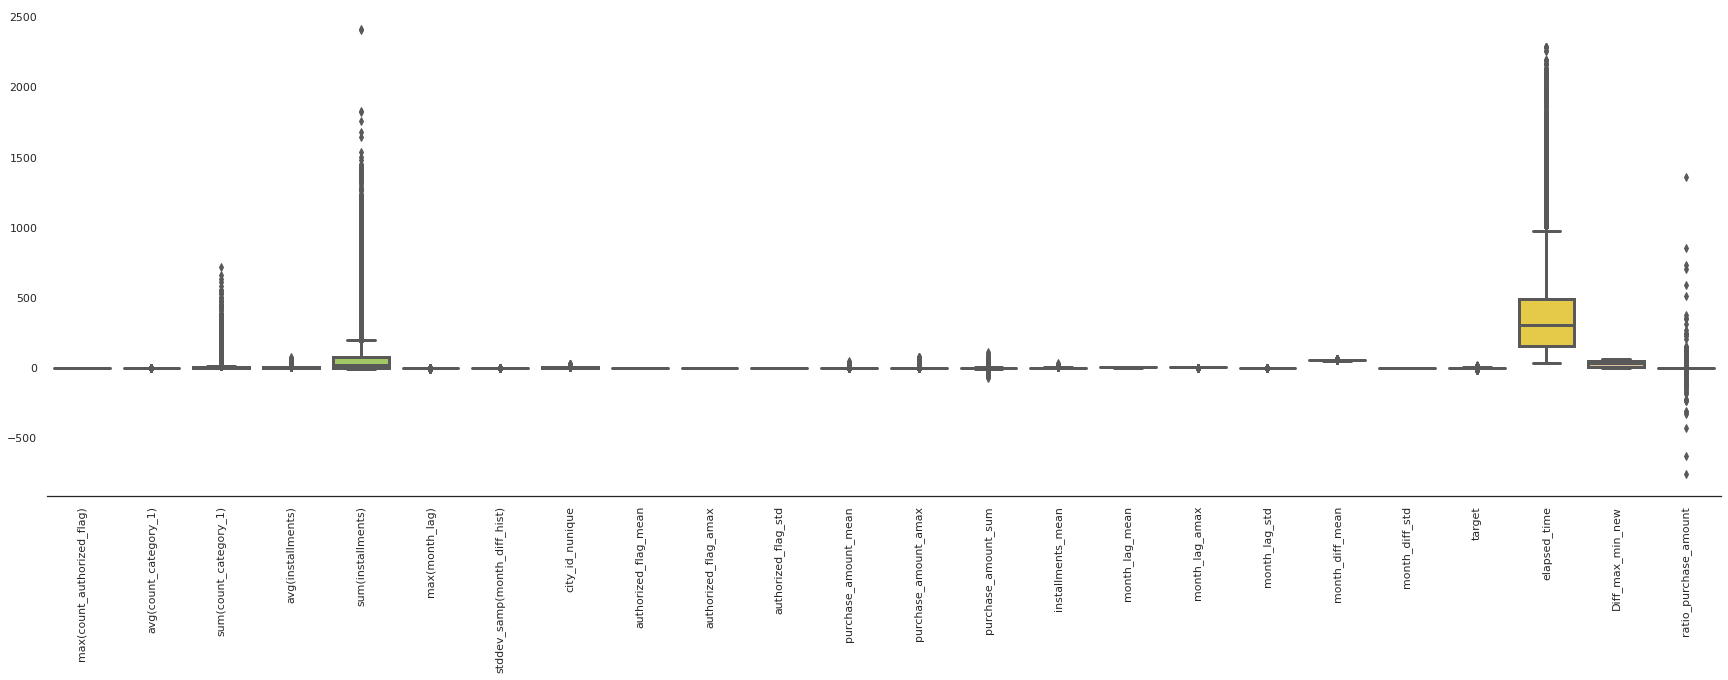

In [ ]:
# LPS & OSR: Este codigo visualiza la distribución de las variables cualitativas. 
data= DF_VF[numeric_features]

sns.set(rc={'figure.figsize':(30,9)}) 
sns.set(style="white") 
sns.boxplot(data = data, linewidth = 3, palette="Set2", fliersize = 5) 
sns.despine(left=True)
plt.xticks(rotation=90)

Con respecto al gráfico anterior se puede evidenciar la presencia de datos  atípicos en las variables: sum(count_category_1), sum(installments), elapsed_time y ratio_purchase_amount.

Las demás variables en el gráfico se evidencian con distribuciones menos dispersas a las variables anteriormente mencionadas. 

In [ ]:
#LPS& OSR: Este código estancia y ajusta el algortimo LocalOutLiarFactor

LOF = LocalOutlierFactor(n_neighbors = 3, algorithm = 'auto', metric = 'euclidean') 
Filtrado = LOF.fit_predict(DF_VF[numeric_features]) # Se realiza la predicción de los datos atípicos
NOF = LOF.negative_outlier_factor_ # Detecta los valores positivos y negativos (residuos). Si los valores son grandes, entonces son valores no atípicos y por lo general, son valores cercanos a -1.
                                    # Si los valores son positivos y grandes y cercanos a 1, entonces son valores atípicos. La opción negative_outlier_dactor_ calcula dichos valores por 
                                    # la media de la relación entre la densidad local de una muestra y las de sus vecinos más cercanos.

radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min()) # radio de detección de datos atípicos
ground_truth = np.ones(len(DF_VF[numeric_features]), dtype = int) # Se recomienda para luego comparar que datos es o no atípico (genera un vector de 1 o -1)
n_errors = (Filtrado != ground_truth).sum() # número de datos atípicos

In [ ]:
#LPS & OSR: Estas lineas de código filtran y localizan las variables donde no hay datos atípicos
pos = np.where(Filtrado == ground_truth) 
pos = np.asarray(pos)
pos = np.hstack(pos)
DF_VF= DF_VF.loc[pos, :]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

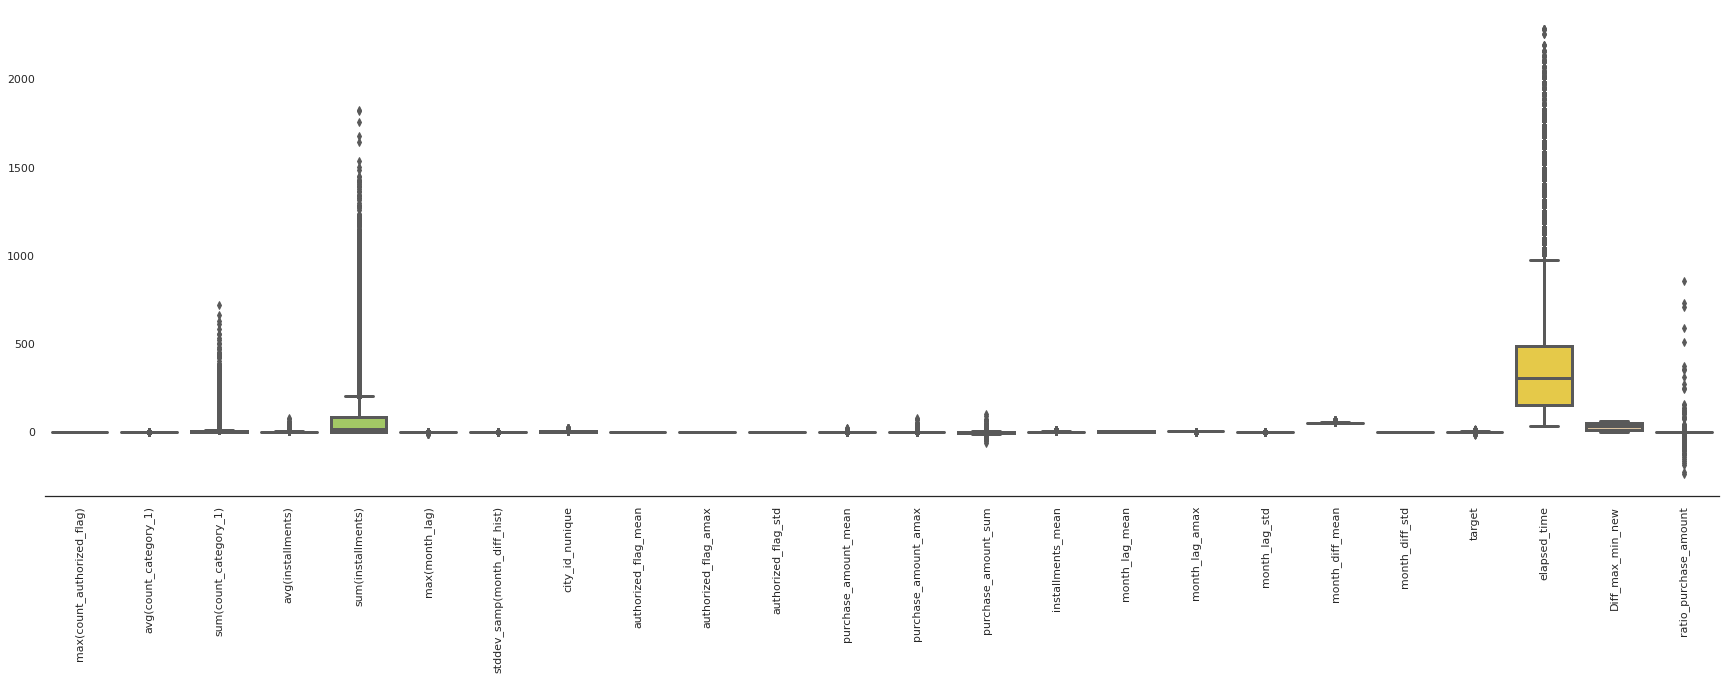

In [ ]:
#LPS &OSR: Se realiza nuevamente la visualización para verificar el comportamiento de los datos, despues de la eliminación de datos atípicos. 
data= DF_VF[numeric_features]
sns.set(rc={'figure.figsize':(30,9)}) 
sns.set(style="white") 
sns.boxplot(data = data, linewidth = 3, palette="Set2", fliersize = 5) 
sns.despine(left=True)
plt.xticks(rotation=90)

In [ ]:
#LPS &OSR: Se imprime información del dataset DF_VF sin datos atipicos. 
DF_VF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168781 entries, 0 to 179985
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   card_id                       168781 non-null  object 
 1   merchant_id_<lambda>          168781 non-null  object 
 2   max(count_authorized_flag)    168781 non-null  float64
 3   avg(count_category_1)         168781 non-null  float64
 4   sum(count_category_1)         168781 non-null  float64
 5   avg(installments)             168781 non-null  float64
 6   sum(installments)             168781 non-null  float64
 7   max(month_lag)                168781 non-null  float64
 8   stddev_samp(month_diff_hist)  168781 non-null  float64
 9   city_id_nunique               168781 non-null  float64
 10  authorized_flag_mean          168781 non-null  float64
 11  authorized_flag_amax          168781 non-null  float64
 12  authorized_flag_std           168781 non-nul

In [ ]:
#LPS &OSR: Se realiza el casting a las variables feature. 
DF_VF["feature_1"]=DF_VF["feature_1"].astype('category')
DF_VF["feature_2"]=DF_VF["feature_2"].astype('category')
DF_VF["feature_3"]=DF_VF["feature_3"].astype('category')

Como resultado de este proceso se eliminan 11396 filas y se obtienen un Dataframe con 168590 filas. Por lo tanto, el 6,3% de las filas fueron eliminadas ya que contenian datos atípicos. 

In [ ]:
# LPS & OSR: Se exporta a formato CVS el DataFrame DB_VF
DF_VF.to_csv("00_BBDD.csv")

In [ ]:
#LPS &OSR: Se comprime dentro de un archivo gz.
DF_VF.to_csv('00_DB.gz', compression='gzip')

## Clustering Dataset **Merchants**

El objetivo de esta sesión es  verificar si los cluster obtenidos a partir del conjunto de datos **merchants**, tienen un impacto positivo en el desempeño de los modelos.

Para esto se realizaron 6 iteraciones: 

1. Iteración sin cluster
2. Iteration k means (k=8) Inertia
3. Iteration k means (k=3) Davies bouldin
4. Iteration K means (K=2) Silhouette
5. Iteration GMM (k=18) Davies bouldin
6. Iteration GMM (k=22) AIC et BIC



In [ ]:
# LPS &OSR se crea un Dataframe que contenga los merchant_id unicos del Dataframe DF_VF
merchant_id_DF=pd.DataFrame(data=DF_VF['merchant_id_<lambda>'].unique(), columns=['merchant_id'])
merchant_id_DF.head(2)

,merchant_id
0,M_ID_6b7c68efb4
1,M_ID_0167043535


In [ ]:
#LPS &OSR: se guarda en un csv el dataframe resultante, estos datos se usarán en la creación de clusters en el colab creación de clusters merchants
merchant_id_DF.to_csv('merchant_id_DF.csv', index=False,header=True)

### **1. Iteration sin clusters**

Esta primera iteración no tiene asociado ningún tipo de cluster y se realiza para tener una base de comparación entre los modelos. 

In [ ]:
# LPS & OSR: Se revisa la información del dataset DF_VF
DF_VF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168781 entries, 0 to 179985
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   card_id                       168781 non-null  object  
 1   merchant_id_<lambda>          168781 non-null  object  
 2   max(count_authorized_flag)    168781 non-null  float64 
 3   avg(count_category_1)         168781 non-null  float64 
 4   sum(count_category_1)         168781 non-null  float64 
 5   avg(installments)             168781 non-null  float64 
 6   sum(installments)             168781 non-null  float64 
 7   max(month_lag)                168781 non-null  float64 
 8   stddev_samp(month_diff_hist)  168781 non-null  float64 
 9   city_id_nunique               168781 non-null  float64 
 10  authorized_flag_mean          168781 non-null  float64 
 11  authorized_flag_amax          168781 non-null  float64 
 12  authorized_flag_std           

In [ ]:
# LPS &OSR: Se crea una copia del dataframe DF_VF y se elimina la columna target
DF_VF_sin_target=DF_VF.copy()
DF_VF_sin_target.drop(columns=['target'], inplace=True)

In [ ]:
# LPS &OSR: Se crea dos listas una para los nombres de las columnas númericas y otra para las columnas categoricas
numeric_features = DF_VF_sin_target.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()
categorical_features = DF_VF_sin_target.select_dtypes(include=['category']).columns.to_list()

In [ ]:
#LPS&OSR: Se realiza un pipe line que tiene los siguientes pasos: 
# 1. escala las variables númericas
# 2. Hace un onehotencoder para las variables  categoricas 
# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('scaler', StandardScaler())
                        ])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                        steps=[
                            
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                        ])

preprocessor = ColumnTransformer(
                transformers=[
                            ('numeric', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                    ]) 

In [ ]:
#LPS &OSR: se asigna el pipeline
pipe_scaler_onehot = Pipeline([("preprocessor", preprocessor)])

In [ ]:
#LPS &OSR se ajusta el pipiline a los datos y se transforman los datos. 
pipe_scaler_onehot.fit(DF_VF_sin_target)
preprocessed_data = pipe_scaler_onehot["preprocessor"].transform(DF_VF_sin_target)
preprocessed_data 

array([[ 0.        , -0.48445914, -0.33237594, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.03108091, -0.16901818, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , -0.44787242, -0.27792335, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.        ,  4.71390304,  0.26660252, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , -0.48445914, -0.33237594, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , -0.48445914, -0.33237594, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
#LPS &OSR: Se asignan los datos resultado del pipiline a la variable X y la serie de la variable target se le asigna a la variable Y
X= preprocessed_data 
Y=DF_VF['target']      

#LPS &OSR: Se hace un split de datos otorgando un 80% para train y 20% para test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [ ]:
# LPS & OSR: Se crea un modelo de regresión lineal simple y se ajusta con los datos 
LR = LinearRegression()
LR.fit(X_train, Y_train) 
Y_pred = LR.predict(X_test)

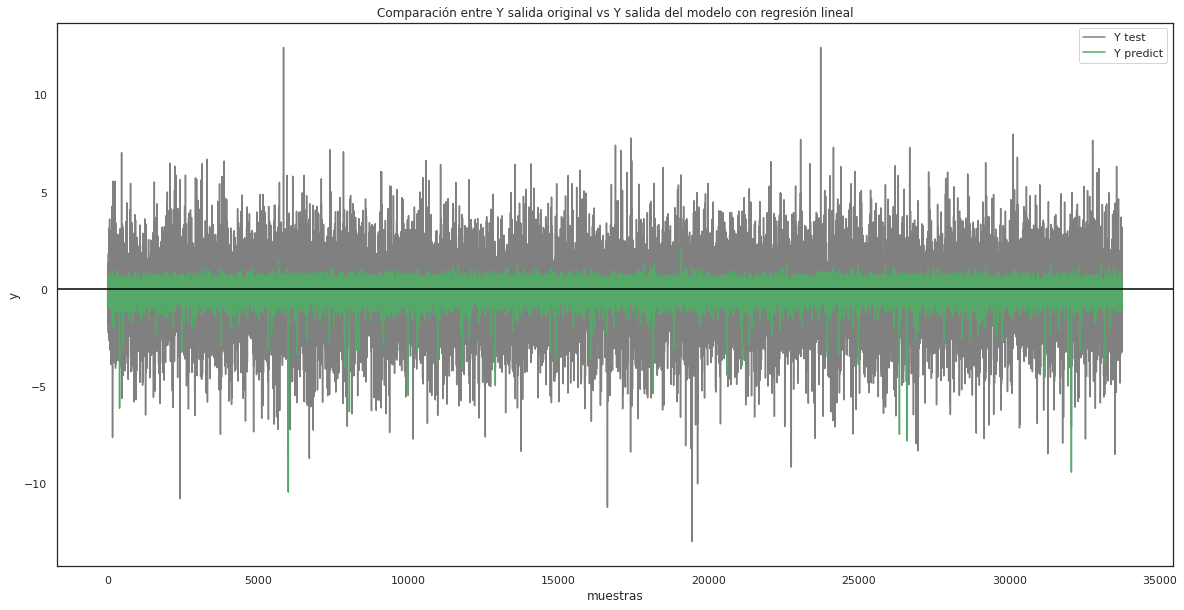

In [ ]:
#LPS &OSR: Se gráfica las prediciones del modelo resultante. 
fig = plt.figure(figsize=(20,10))
line_1 = plt.plot(np.arange(len(Y_test)), Y_test, color = 'gray', label='Y test') 
line_2 = plt.plot(np.arange(len(Y_test)), Y_pred, color = 'g', label='Y predict') 
plt.axhline(0, color="black")
plt.legend()
plt.title('Comparación entre Y salida original vs Y salida del modelo con regresión lineal') 
plt.xlabel('muestras') 
plt.ylabel('y') 

plt.show() 

In [ ]:
#LPS &OSR: Se imprimen los resultados de las metricas de error para la primera iteración
print('R2',r2_score(Y_test, Y_pred))
print('RMSE',mean_squared_error(Y_test, Y_pred, squared=False))

R2 0.08243476302123365
RMSE 1.4699718755846065


### **2. Iteration k means (k=8) Inertia**

In [ ]:
#LPS &OSR: Se hace la lectura del archivo que contiene las clases obtenidas del cluster K means (K=8) inertia
merchants_cluster_kmeans=pd.read_csv("ELO/DF_Merchants_Kmeans_k8_Entropia.csv", sep=",")
merchants_cluster_kmeans.head(2)

,Unnamed: 0,merchant_id,Cluster
0,0,M_ID_000025127f,0
1,1,M_ID_0000699140,0


In [ ]:
#LPS &OSR: Este código elimina una columan sobrante del dataframe Merchants_cluster_kmeans
merchants_cluster_kmeans.drop(columns=['Unnamed: 0'],inplace=True)
merchants_cluster_kmeans.head(2)

,merchant_id,Cluster
0,M_ID_000025127f,0
1,M_ID_0000699140,0


In [ ]:
#LPS &OSR: Este código renombra las columnas merchant_id y Cluster para posteriormente hacer un join con el dataframe DF_VF
#LPS &OSR: Se crea un dataframe llamado DF_VF_kmeans_8_Inertia que contiene la información de DF_VF + las clases otorgadas por el cluster
merchants_cluster_kmeans.rename(columns ={'merchant_id':'merchant_id_<lambda>'}, inplace=True)
merchants_cluster_kmeans.rename(columns ={'Cluster':'Cluster_K_means_8_Inertia'}, inplace=True)
DF_VF_kmeans_8_Inertia=DF_VF.merge(merchants_cluster_kmeans, how='left', on='merchant_id_<lambda>')

In [ ]:
#LPS &OSR: Se verifica la información del DF.
DF_VF_kmeans_8_Inertia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168781 entries, 0 to 168780
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   card_id                       168781 non-null  object  
 1   merchant_id_<lambda>          168781 non-null  object  
 2   max(count_authorized_flag)    168781 non-null  float64 
 3   avg(count_category_1)         168781 non-null  float64 
 4   sum(count_category_1)         168781 non-null  float64 
 5   avg(installments)             168781 non-null  float64 
 6   sum(installments)             168781 non-null  float64 
 7   max(month_lag)                168781 non-null  float64 
 8   stddev_samp(month_diff_hist)  168781 non-null  float64 
 9   city_id_nunique               168781 non-null  float64 
 10  authorized_flag_mean          168781 non-null  float64 
 11  authorized_flag_amax          168781 non-null  float64 
 12  authorized_flag_std           

In [ ]:
#LPS &OSR: Se hace un casting de la variable que contiene las clases del cluster
#LPS &OSR: Las clases del cluster se convierten en dummies. 
DF_VF_kmeans_8_Inertia['Cluster_K_means_8_Inertia']=DF_VF_kmeans_8_Inertia['Cluster_K_means_8_Inertia'].astype('category')
Cluster_K_means_8_Inertia= pd.get_dummies(DF_VF_kmeans_8_Inertia['Cluster_K_means_8_Inertia'])

In [ ]:
#LPS &OSR: Se agrega al dataframe la variable target.
Cluster_K_means_8_Inertia= pd.concat([Cluster_K_means_8_Inertia, DF_VF_kmeans_8_Inertia['target']], axis=1)

In [ ]:
#LPS &OSR: Se calcula la correlación de la variable target con las clases obtenidas en el cluster. 
DF_correlation_Kmeans_8_Inertia=pd.DataFrame(Cluster_K_means_8_Inertia.corrwith(Cluster_K_means_8_Inertia["target"]), columns =['Target'])
DF_correlation_Kmeans_8_Inertia.drop(index=('target'), inplace=True)

In [ ]:
#LPS &OSR: Se imprimen las correlaciones
DF_correlation_Kmeans_8_Inertia

,Target
0.0,-0.010611
1.0,-0.003281
2.0,-0.004277
3.0,0.005679
4.0,0.004135
5.0,-0.001863
6.0,0.010955
7.0,0.014004


Se puede constatar que ninguna clase de esta iteración tiene correlación con la variable objetivo target. 

In [ ]:
#LPS &OSR: Se crea una copia del Dataframe y se elimina la columan target. 
DF_VF_sin_target_kmeans_8_Inertia=DF_VF_kmeans_8_Inertia.copy()
DF_VF_sin_target_kmeans_8_Inertia.drop(columns=['target'], inplace=True)

In [ ]:
# LPS &OSR: Se crea dos listas una para los nombres de las columnas númericas y otra para las columnas categoricas
numeric_features = DF_VF_sin_target_kmeans_8_Inertia.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()
categorical_features = DF_VF_sin_target_kmeans_8_Inertia.select_dtypes(include=['category']).columns.to_list()
categorical_features

['feature_1', 'feature_2', 'feature_3', 'Cluster_K_means_8_Inertia']

In [ ]:
#LPS&OSR: Se realiza un pipe line que tiene los siguientes pasos: 
# 1. escala las variables númericas
# 2. Hace un onehotencoder para las variables  categoricas 
# 3. hace imputación en las variables categoricas con las estrategia most_frecuent_
# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('scaler', StandardScaler())
                        ])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                        ])

preprocessor = ColumnTransformer(
                transformers=[
                            ('numeric', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                    ]) 

In [ ]:
# LPS &OSR: Se asigna el pipeline a la variable 
pipe_scaler_onehot_clusters = Pipeline([("preprocessor", preprocessor)])

In [ ]:
#LPS&OSR: Se asigna ajusta el pipeline y se transforman los datos. 
pipe_scaler_onehot_clusters.fit(DF_VF_sin_target_kmeans_8_Inertia)
preprocessed_data = pipe_scaler_onehot_clusters["preprocessor"].transform(DF_VF_sin_target_kmeans_8_Inertia)

In [ ]:
#LPS &OSR: Se asignan los datos resultado del pipiline a la variable X y la serie de la variable target se le asigna a la variable Y
X= preprocessed_data 
Y=DF_VF['target']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)
# LPS & OSR: se hace el split de los datos, tanto para entrenamiento como para test. Se decide realizar una particion 80%-20% para train y test respectivamente.

In [ ]:
# LPS & OSR: Se crea un modelo de regresión lineal simple y se ajusta con los datos 
LR = LinearRegression()
LR.fit(X_train, Y_train) 
Y_pred = LR.predict(X_test)

In [ ]:
#LPS &OSR: Se imprimen las métricas de error. 
print('R2',r2_score(Y_test, Y_pred))
print('RMSE',mean_squared_error(Y_test, Y_pred, squared=False))

R2 0.08238416082988109
RMSE 1.470012408273524


**Conclusión Iteration k means (k=8) Inertia:** El modelo no tuvo un desempaño mejor incluyendo las clases resultantes del modelo  de clustering

### **3. Iteration k means (k=3) Davies bouldin**

In [ ]:
#LPS &OSR: Se hace la lectura del archivo que contiene las clases obtenidas del cluster K means (K=3) David bouldin
DF_Merchants_Kmeans_k3_DB=pd.read_csv("ELO/DF_Merchants_Kmeans_k3_DB.csv", sep=",")
DF_Merchants_Kmeans_k3_DB.head(2)

,Unnamed: 0,merchant_id,Cluster_k3_DB
0,0,M_ID_000025127f,1
1,1,M_ID_0000699140,1


In [ ]:
#LPS &OSR: Este código elimina una columna sobrante del dataframe Merchants_cluster_kmeans_K3_DB

DF_Merchants_Kmeans_k3_DB.drop(columns=['Unnamed: 0'],inplace=True)
DF_Merchants_Kmeans_k3_DB.head(2)

,merchant_id,Cluster_k3_DB
0,M_ID_000025127f,1
1,M_ID_0000699140,1


In [ ]:
#LPS &OSR: Este código renombra las columnas merchant_id y Cluster para posteriormente hacer un join con el dataframe DF_VF
#LPS &OSR: Se crea un dataframe llamado DF_VF_kmeans_k3_DB que contiene la información de DF_VF + las clases otorgadas por el cluster
DF_Merchants_Kmeans_k3_DB.rename(columns ={'merchant_id':'merchant_id_<lambda>'}, inplace=True)
DF_VF_kmeans_k3_DB=DF_VF.merge(DF_Merchants_Kmeans_k3_DB, how='left', on='merchant_id_<lambda>')

In [ ]:
#LPS &OSR: Se verifica la información del DF.
DF_VF_kmeans_k3_DB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168781 entries, 0 to 168780
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   card_id                       168781 non-null  object  
 1   merchant_id_<lambda>          168781 non-null  object  
 2   max(count_authorized_flag)    168781 non-null  float64 
 3   avg(count_category_1)         168781 non-null  float64 
 4   sum(count_category_1)         168781 non-null  float64 
 5   avg(installments)             168781 non-null  float64 
 6   sum(installments)             168781 non-null  float64 
 7   max(month_lag)                168781 non-null  float64 
 8   stddev_samp(month_diff_hist)  168781 non-null  float64 
 9   city_id_nunique               168781 non-null  float64 
 10  authorized_flag_mean          168781 non-null  float64 
 11  authorized_flag_amax          168781 non-null  float64 
 12  authorized_flag_std           

In [ ]:
#LPS &OSR: Se hace un casting de la variable que contiene las clases del cluster
#LPS &OSR: Las clases del cluster se convierten en dummies.
DF_VF_kmeans_k3_DB['Cluster_k3_DB']=DF_VF_kmeans_k3_DB['Cluster_k3_DB'].astype('category')
Cluster_K_means_k3_DB= pd.get_dummies(DF_VF_kmeans_k3_DB['Cluster_k3_DB'])

In [ ]:
#LPS &OSR: Se agrega al dataframe la variable target.
Cluster_K_means_k3_DB= pd.concat([Cluster_K_means_k3_DB, DF_VF_kmeans_k3_DB['target']], axis=1)

In [ ]:
#LPS &OSR: Se calcula la correlación de la variable target con las clases obtenidas en el cluster. 
DF_correlation_Kmeans_k3_DB=pd.DataFrame(Cluster_K_means_k3_DB.corrwith(Cluster_K_means_k3_DB["target"]), columns =['Target'])

In [ ]:
#LPS &OSR: Se imprimen las correlaciones
DF_correlation_Kmeans_k3_DB.drop(index=('target'), inplace=True)
DF_correlation_Kmeans_k3_DB

,Target
0.0,0.009488
1.0,0.005359
2.0,-0.005415


En esta iteración se puede constatar que ninguna clase obtenida en este cluster tiene correlación con la variable objetivo (target)

In [ ]:
#LPS &OSR: Se crea una copia del Dataframe y se elimina la columna target. 
DF_VF_sin_target_kmeans_k3_DB=DF_VF_kmeans_k3_DB.copy()
DF_VF_sin_target_kmeans_k3_DB.drop(columns=['target'], inplace=True)

In [ ]:
# LPS &OSR: Se crea dos listas una para los nombres de las columnas númericas y otra para las columnas categóricas
numeric_features = DF_VF_sin_target_kmeans_k3_DB.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()
categorical_features = DF_VF_sin_target_kmeans_k3_DB.select_dtypes(include=['category']).columns.to_list()
categorical_features

['feature_1', 'feature_2', 'feature_3', 'Cluster_k3_DB']

In [ ]:
#LPS&OSR: Se realiza un pipe line que tiene los siguientes pasos: 
# 1. escalan las variables númericas
# 2. Hace un onehotencoder para las variables  categóricas 
# 3. hace imputación en las variables categóricas con las estrategia most_frecuent_
# Transformaciones para las variables numéricas

numeric_transformer = Pipeline(
                        steps=[
                            ('scaler', StandardScaler())
                        ])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                        ])

preprocessor = ColumnTransformer(
                transformers=[
                            ('numeric', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                    ]) 

In [ ]:
# LPS &OSR: Se asigna el pipeline a la variable 
pipe_scaler_onehot_clusters = Pipeline([("preprocessor", preprocessor)])

In [ ]:
#LPS&OSR: Se asigna ajusta el pipeline y se transforman los datos
pipe_scaler_onehot_clusters.fit(DF_VF_sin_target_kmeans_k3_DB)
preprocessed_data = pipe_scaler_onehot_clusters["preprocessor"].transform(DF_VF_sin_target_kmeans_k3_DB)

In [ ]:
# LPS & OSR: se hace el split de los datos, tanto para entrenamiento como para test. Se decide realizar una particion 80%-20% para train y test respectivamente.
X= preprocessed_data 
Y=DF_VF['target']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

In [ ]:
# LPS & OSR: Se crea un modelo de regresión lineal limple y se ajusta con los datos 
LR = LinearRegression()
LR.fit(X_train, Y_train) 
Y_pred = LR.predict(X_test)

In [ ]:
#LPS &OSR: Se imprimen las métricas de error
print('R2',r2_score(Y_test, Y_pred))
print('RMSE',mean_squared_error(Y_test, Y_pred, squared=False))

R2 0.08233750566193287
RMSE 1.4700497783804485


**Conclusión Iteration k means (k=3) Davies bouldin**: El modelo no tuvo un desempaño mejor incluyendo las clases resultantes del modelo de clustering

### **4. Iteration k means (k=2) Silhouette**

In [ ]:
#LPS &OSR: Se hace la lectura del archivo que contiene las clases obtenidas del cluster K means (K=3) Silhouette
Merchants_Kmeans_k2_SLH=pd.read_csv("ELO/DF_Merchants_Kmeans_k2_SLH.csv", sep=",")
Merchants_Kmeans_k2_SLH.head(2)

,Unnamed: 0,merchant_id,Cluster_k2_SLH
0,0,M_ID_000025127f,0
1,1,M_ID_0000699140,0


In [ ]:
#LPS &OSR: Este código elimina una columna sobrante del dataframe Merchants_cluster_kmeans_K2_SLH
Merchants_Kmeans_k2_SLH.drop(columns=['Unnamed: 0'],inplace=True)
Merchants_Kmeans_k2_SLH.head(2)

,merchant_id,Cluster_k2_SLH
0,M_ID_000025127f,0
1,M_ID_0000699140,0


In [ ]:
#LPS &OSR: Este código renombra las columnas merchant_id y Cluster para posteriormente hacer un join con el dataframe DF_VF
#LPS &OSR: Se crea un dataframe llamado DF_VF_kmeans_8_Inertia que contiene la información de DF_VF + las clases otorgadas por el cluster
Merchants_Kmeans_k2_SLH.rename(columns ={'merchant_id':'merchant_id_<lambda>'}, inplace=True)
DF_VF_Kmeans_k2_SLH=DF_VF.merge(Merchants_Kmeans_k2_SLH, how='left', on='merchant_id_<lambda>')

In [ ]:
#LPS &OSR: Se hace un casting de la variable que contiene las clases del cluster
#LPS &OSR: Las clases del cluster se convierten en dummies. 
DF_VF_Kmeans_k2_SLH['Cluster_k2_SLH']=DF_VF_Kmeans_k2_SLH['Cluster_k2_SLH'].astype('category')
Cluster_Kmeans_k2_SLH= pd.get_dummies(DF_VF_Kmeans_k2_SLH['Cluster_k2_SLH'])

In [ ]:
#LPS &OSR: Se agrega al dataframe la variable target.
Cluster_Kmeans_k2_SLH= pd.concat([Cluster_Kmeans_k2_SLH, DF_VF_Kmeans_k2_SLH['target']], axis=1)

In [ ]:
#LPS &OSR: Se calcula la correlación de la variable target con las clases obtenidas en el cluster. 
DF_correlation_Kmeans_k2_SLH=pd.DataFrame(Cluster_Kmeans_k2_SLH.corrwith(Cluster_Kmeans_k2_SLH["target"]), columns =['Target'])
DF_correlation_Kmeans_k2_SLH.drop(index=('target'), inplace=True)
DF_correlation_Kmeans_k2_SLH

,Target
0.0,0.011352
1.0,-0.005415


Se puede contatar que ninguna clase tiene correlación con la variable objetivo target. 

In [ ]:
#LPS &OSR: Se crea una copia del Dataframe y se elimina la columna target. 
DF_VF_sin_target_Kmeans_k2_SLH=DF_VF_Kmeans_k2_SLH.copy()
DF_VF_sin_target_Kmeans_k2_SLH.drop(columns=['target'], inplace=True)

In [ ]:
# LPS &OSR: Se crean dos listas una para los nombres de las columnas númericas y otra para las columnas categ+oricas
numeric_features = DF_VF_sin_target_Kmeans_k2_SLH.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()
categorical_features = DF_VF_sin_target_Kmeans_k2_SLH.select_dtypes(include=['category']).columns.to_list()
categorical_features

['feature_1', 'feature_2', 'feature_3', 'Cluster_k2_SLH']

In [ ]:
#LPS&OSR: Se realiza un pipe line que tiene los siguientes pasos: 
# 1. escalan las variables númericas
# 2. Hace un onehotencoder para las variables  categoricas 
# 3. hace imputación en las variables categoricas con las estrategia most_frecuent_
# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('scaler', StandardScaler())
                        ])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                        ])

preprocessor = ColumnTransformer(
                transformers=[
                            ('numeric', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                    ]) 

In [ ]:
# LPS &OSR: Se asigna el pipeline 
pipe_scaler_onehot_clusters = Pipeline([("preprocessor", preprocessor)])

In [ ]:
#LPS&OSR: Se asigna ajusta el pipeline y se transforman los datos. 
pipe_scaler_onehot_clusters.fit(DF_VF_sin_target_Kmeans_k2_SLH)
preprocessed_data = pipe_scaler_onehot_clusters["preprocessor"].transform(DF_VF_sin_target_Kmeans_k2_SLH)

In [ ]:
# LPS & OSR: se hace el split de los datos, tanto para entrenamiento como para test. Se decide realizar una particion 80%-20% para train y test respectivamente
X= preprocessed_data 
Y=DF_VF['target']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)


In [ ]:
# LPS & OSR: Se crea un modelo de regresión lineal limple y se ajusta con los datos 
LR = LinearRegression()
LR.fit(X_train, Y_train) 
Y_pred = LR.predict(X_test)

In [ ]:
print('R2',r2_score(Y_test, Y_pred))
print('RMSE',mean_squared_error(Y_test, Y_pred, squared=False))

R2 0.08231554781232642
RMSE 1.470067365967963


**Conclusión Iteration K means(k=22) Silhoutte:** El modelo no tuvo un desempaño mejor incluyendo las clases resultantes del modelo de clustering.

### **5. Iteration GMM (k=18) Davies Bouldin**

In [ ]:
#LPS &OSR: Se hace la lectura del archivo que contiene las clases obtenidas del cluster K means (K=18) Davies Bouldin
Merchants_GMM_k18_DB=pd.read_csv("ELO/DF_Merchants_GMM_k18_DB.csv", sep=",")
Merchants_GMM_k18_DB.head(2)

,Unnamed: 0,merchant_id,Cluster_k18_GMM_DB
0,0,M_ID_000025127f,8
1,1,M_ID_0000699140,2


In [ ]:
#LPS &OSR: Este codigo elimina una columan sobrante del dataframe Merchants_GMM_k18_DB
Merchants_GMM_k18_DB.drop(columns=['Unnamed: 0'],inplace=True)
Merchants_GMM_k18_DB.head(2)

,merchant_id,Cluster_k18_GMM_DB
0,M_ID_000025127f,8
1,M_ID_0000699140,2


In [ ]:
#LPS &OSR: Este código renombra las columnas merchant_id y Cluster para posteriormente hacer un join con el dataframe DF_VF
#LPS &OSR: Se crea un dataframe llamado DF_VF_kmeans_8_Inertia que contiene la información de DF_VF + las clases otorgadas por el cluster
Merchants_GMM_k18_DB.rename(columns ={'merchant_id':'merchant_id_<lambda>'}, inplace=True)
DF_VF_GMM_k18_DB=DF_VF.merge(Merchants_GMM_k18_DB, how='left', on='merchant_id_<lambda>')

In [ ]:
#LPS &OSR: Se hace un casting de la variable que contiene las clases del cluster
#LPS &OSR: Las clases del cluster se convierten en dummies. 
DF_VF_GMM_k18_DB['Cluster_k18_GMM_DB']=DF_VF_GMM_k18_DB['Cluster_k18_GMM_DB'].astype('category')
Cluster_k18_GMM_DB= pd.get_dummies(DF_VF_GMM_k18_DB['Cluster_k18_GMM_DB'])

In [ ]:
#LPS &OSR: Se agrega al dataframe la variable target.
Cluster_k18_GMM_DB= pd.concat([Cluster_k18_GMM_DB, DF_VF_GMM_k18_DB['target']], axis=1)

In [ ]:
#LPS &OSR: Se calcula la correlación de la variable target con las clases obtenidas en el cluster. 
DF_correlation_k18_GMM_DB=pd.DataFrame(Cluster_k18_GMM_DB.corrwith(Cluster_k18_GMM_DB["target"]), columns =['Target'])
DF_correlation_k18_GMM_DB.drop(index=('target'), inplace=True)
DF_correlation_k18_GMM_DB

,Target
0.0,0.000993
1.0,0.009850
2.0,-0.002818
3.0,-0.000664
4.0,0.022466
5.0,0.004779
6.0,-0.002032
7.0,0.001277
8.0,-0.005912
9.0,-0.000789


Se puede contatar que ninguna clase tiene correlación con la variable objetivo target. 

In [ ]:
#LPS &OSR: Se crea una copia del Dataframe y se elimina la columna target. 
DF_VF_sin_target_GMM_k18_DB=DF_VF_GMM_k18_DB.copy()
DF_VF_sin_target_GMM_k18_DB.drop(columns=['target'], inplace=True)

In [ ]:
# LPS &OSR: Se crean dos listas una para los nombres de las columnas númericas y otra para las columnas categóricas
numeric_features = DF_VF_sin_target_GMM_k18_DB.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()
categorical_features = DF_VF_sin_target_GMM_k18_DB.select_dtypes(include=['category']).columns.to_list()
categorical_features

['feature_1', 'feature_2', 'feature_3', 'Cluster_k18_GMM_DB']

In [ ]:
#LPS&OSR: Se realiza un pipe line que tiene los siguientes pasos: 
# 1. escalan las variables númericas
# 2. Hace un onehotencoder para las variables  categoricas 
# 3. hace imputación en las variables categoricas con las estrategia most_frecuent_
# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('scaler', StandardScaler())
                        ])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                        ])

preprocessor = ColumnTransformer(
                transformers=[
                            ('numeric', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                    ]) 

In [ ]:
# LPS &OSR: Se asigna el pipeline 
pipe_scaler_onehot_clusters = Pipeline([("preprocessor", preprocessor)])

In [ ]:
#LPS&OSR: Se asigna ajusta el pipeline y se transforman los datos. 
pipe_scaler_onehot_clusters.fit(DF_VF_sin_target_GMM_k18_DB)
preprocessed_data = pipe_scaler_onehot_clusters["preprocessor"].transform(DF_VF_sin_target_GMM_k18_DB)

In [ ]:
X= preprocessed_data 
Y=DF_VF['target']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)
# LPS & OSR: se hace el split de los datos, tanto para entrenamiento como para test. Se decide realizar una particion 80%-20% para train y test respectivamente.

In [ ]:
# LPS & OSR: Se crea un modelo de regresión lineal limple y se ajusta con los datos 
LR = LinearRegression()
LR.fit(X_train, Y_train) 
Y_pred = LR.predict(X_test)

In [ ]:
#LPS &OSR: Se imprimen las métricas de error.
print('R2',r2_score(Y_test, Y_pred))
print('RMSE',mean_squared_error(Y_test, Y_pred, squared=False))

R2 0.08266773055969923
RMSE 1.4697852526309505


**Conclusión Iteration GMM(k=18) Davies Bouldin:** El modelo no tuvo un desempaño mejor incluyendo las clases resultantes del modelo

### **6. Iteration GMM (k=22 ) AIC et BIC**

In [ ]:
#LPS &OSR: Se hace la lectura del archivo que contiene las clases obtenidas del cluster GMM (K=22) AIC et BIC
Merchants_GMM_k22_AIC_BIC=pd.read_csv("ELO/DF_Merchants_GMM_k22_AIC_BIC.csv", sep=",")
Merchants_GMM_k22_AIC_BIC.head(2)

,Unnamed: 0,merchant_id,Cluster_k22_GMM_AIC_BIC
0,0,M_ID_000025127f,8
1,1,M_ID_0000699140,15


In [ ]:
#LPS &OSR: Este código elimina una columna sobrante del dataframe Merchants_GMM_K22_AIC_BIC
Merchants_GMM_k22_AIC_BIC.drop(columns=['Unnamed: 0'],inplace=True)
Merchants_GMM_k22_AIC_BIC.head(2)

,merchant_id,Cluster_k22_GMM_AIC_BIC
0,M_ID_000025127f,8
1,M_ID_0000699140,15


In [ ]:
#LPS &OSR: Este código renombra las columnas merchant_id y Cluster para posteriormente hacer un join con el dataframe DF_VF
#LPS &OSR: Se crea un dataframe llamado DF_VF_kmeans_8_Inertia que contiene la información de DF_VF + las clases otorgadas por el cluster
Merchants_GMM_k22_AIC_BIC.rename(columns ={'merchant_id':'merchant_id_<lambda>'}, inplace=True)
DF_VF_GMM_k22_AIC_BIC=DF_VF.merge(Merchants_GMM_k22_AIC_BIC, how='left', on='merchant_id_<lambda>')

In [ ]:
#LPS &OSR: Se hace un casting de la variable que contiene las clases del cluster
#LPS &OSR: Las clases del cluster se convierten en dummies. 
DF_VF_GMM_k22_AIC_BIC['Cluster_k22_GMM_AIC_BIC']=DF_VF_GMM_k22_AIC_BIC['Cluster_k22_GMM_AIC_BIC'].astype('category')
Cluster_k22_GMM_AIC_BIC= pd.get_dummies(DF_VF_GMM_k22_AIC_BIC['Cluster_k22_GMM_AIC_BIC'])

In [ ]:
#LPS &OSR: Se agrega al dataframe la variable target.
Cluster_k22_GMM_AIC_BIC= pd.concat([Cluster_k22_GMM_AIC_BIC, DF_VF_GMM_k22_AIC_BIC['target']], axis=1)

In [ ]:
#LPS &OSR: Se calcula la correlación de la variable target con las clases obtenidas en el cluster. 
DF_correlation_k22_GMM_AIC_BIC=pd.DataFrame(Cluster_k22_GMM_AIC_BIC.corrwith(Cluster_k22_GMM_AIC_BIC["target"]), columns =['Target'])
DF_correlation_k22_GMM_AIC_BIC.drop(index=('target'), inplace=True)
DF_correlation_k22_GMM_AIC_BIC

,Target
0.0,0.004152
1.0,0.010671
2.0,-0.001982
3.0,-0.004812
4.0,-0.002032
5.0,0.022466
6.0,-0.002260
7.0,0.005413
8.0,-0.009749
9.0,0.002419


Se puede contatar que ninguna clase tiene correlación con la variable objetivo target. 

In [ ]:
#LPS &OSR: Se crea una copia del Dataframe y se elimina la columna target. 
DF_VF_sin_target_GMM_k22_AIC_BIC=DF_VF_GMM_k22_AIC_BIC.copy()
DF_VF_sin_target_GMM_k22_AIC_BIC.drop(columns=['target'], inplace=True)

In [ ]:
# LPS &OSR: Se crean dos listas una para los nombres de las columnas númericas y otra para las columnas categoricas
numeric_features = DF_VF_sin_target_GMM_k22_AIC_BIC.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()
categorical_features = DF_VF_sin_target_GMM_k22_AIC_BIC.select_dtypes(include=['category']).columns.to_list()
categorical_features

['feature_1', 'feature_2', 'feature_3', 'Cluster_k22_GMM_AIC_BIC']

In [ ]:
#LPS&OSR: Se realiza un pipe line que tiene los siguientes pasos: 
# 1. escalan las variables númericas
# 2. Realiza un onehotencoder para las variables  categoricas 
# 3. Elabora imputación en las variables categóricas con las estrategia most_frecuent_
# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('scaler', StandardScaler())
                        ])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                        ])

preprocessor = ColumnTransformer(
                transformers=[
                            ('numeric', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                    ]) 

In [ ]:
# LPS &OSR: Se asigna el pipeline 
pipe_scaler_onehot_clusters = Pipeline([("preprocessor", preprocessor)])

In [ ]:
#LPS&OSR: Se asigna ajusta el pipeline y se transforman los datos. 
pipe_scaler_onehot_clusters.fit(DF_VF_sin_target_GMM_k22_AIC_BIC)
preprocessed_data = pipe_scaler_onehot_clusters["preprocessor"].transform(DF_VF_sin_target_GMM_k22_AIC_BIC)

In [ ]:
X= preprocessed_data 
Y=DF_VF['target']      

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)
# LPS & OSR: se hace el split de los datos, tanto para entrenamiento como para test. Se decide realizar una particion 80%-20% para train y test respectivamente.

In [ ]:
# LPS & OSR: Se crea un modelo de regresión lineal simple y se ajusta con los datos 
LR = LinearRegression()
LR.fit(X_train, Y_train) 
Y_pred = LR.predict(X_test)

In [ ]:
#LPS &OSR: Se imprimen las métricas de error.
print('R2',r2_score(Y_test, Y_pred))
print('RMSE', mean_squared_error(Y_test, Y_pred, squared=False))

R2 0.08276702341607634
RMSE 1.4697057050503104


**Conclusión Iteration GMM(k=22) AIC et BIC:** El modelo no tuvo un desempaño mejor incluyendo las clases resultantes del modelo de clustering

 # **Análitica Descriptiva**

Partiendo del conjunto de datos construido anteriormente, se realiza un analisis descriptivo con el objetivo de obtener una base de conocimiento que puede ser el fundamento para posteriores análisis. De este modo, buscamos interpretar los datos de forma correcta para obtener perspectivas que construyan conocimiento para el objetivo del proyecto. 

### **Descarga de paquetes**

In [ ]:
# Descarga de paquetes de las librerias
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline                    
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [ ]:
# Descarga de archivos desde repositorio de github
!git clone https://github.com/LuisPortela/ELO.git #LPS & OSR: se clona el repostorio que alberga el documento json para hacer la lectura de datos directamente 
import zipfile                                     #           del API de kaggel
import os
import pandas as pd
os.environ['KAGGLE_CONFIG_DIR'] = "/content/ELO"

fatal: destination path 'ELO' already exists and is not an empty directory.


### **Lectura de datos**

In [ ]:
#LPS &OSR: Lectura del Dataset 00_BBDD, dataset proveniente de etapa de tratamiento de datos. 
ELO_BBDD = pd.read_csv('ELO/00_DB.gz', compression='gzip', header=0, sep=',')

In [ ]:
#LPS &OSR: Se visualizan inicialmente las dos primeras filas del dataset
ELO_BBDD.head(2)

,Unnamed: 0,card_id,merchant_id_<lambda>,max(count_authorized_flag),avg(count_category_1),sum(count_category_1),avg(installments),sum(installments),max(month_lag),stddev_samp(month_diff_hist),...,month_lag_amax,month_lag_std,month_diff_std,target,elapsed_time,Diff_max_min_new,ratio_purchase_amount,feature_1,feature_2,feature_3
0,0,C_ID_003fb4967b,M_ID_6b7c68efb4,1.0,0.000000,0.0,0.000000,0.0,-1.0,0.000000e+00,...,2.0,0.000000,0.0,-0.078485,276.0,19.0,0.240232,3.0,2.0,1.0
1,1,C_ID_007a00cf2f,M_ID_0167043535,1.0,0.090909,3.0,2.424242,80.0,0.0,5.393276e-15,...,2.0,0.316228,0.0,0.014108,365.0,37.0,-0.076830,1.0,1.0,0.0


In [ ]:
#LPS & OSR: Se imprime la información del data set.
ELO_BBDD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167758 entries, 0 to 167757
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    167758 non-null  int64  
 1   card_id                       167758 non-null  object 
 2   merchant_id_<lambda>          167758 non-null  object 
 3   max(count_authorized_flag)    167758 non-null  float64
 4   avg(count_category_1)         167758 non-null  float64
 5   sum(count_category_1)         167758 non-null  float64
 6   avg(installments)             167758 non-null  float64
 7   sum(installments)             167758 non-null  float64
 8   max(month_lag)                167758 non-null  float64
 9   stddev_samp(month_diff_hist)  167758 non-null  float64
 10  city_id_nunique               167758 non-null  float64
 11  authorized_flag_mean          167758 non-null  float64
 12  authorized_flag_amax          167758 non-nul

El conjunto de datos cuenta con 28 caracteristicas. No hay presencia de datos nulos

In [ ]:
#LPS &OSR: Se eliminan las columnas merchant_id_<lambda> y Unname: 0. 
ELO_BBDD.drop(columns=['merchant_id_<lambda>',"Unnamed: 0"], inplace=True)

In [ ]:
#LPS &OSR: Se realiza el casting de las variables feature con el objetivo de asignarles el tipo: category: 
ELO_BBDD['feature_1']=ELO_BBDD['feature_1'].astype('category')
ELO_BBDD['feature_2']=ELO_BBDD['feature_2'].astype('category')
ELO_BBDD['feature_3']=ELO_BBDD['feature_3'].astype('category')

In [ ]:
#LPS & OSR: Se seleccionan las variables númericas del conjunto de datos. 
numeric_features = ELO_BBDD.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()

### **1. Analisis univariable**

#### **1.1.Variables Cuantitativas**

**1.1.1 Variable avg(count_category_1)**



La variable **avg(count_category_1)** representa el promedio los valores de la variable anonimizada category_1 del dataset **Historical_transation**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable avg(count_category_1) con el objetivo de conocer sus principales estadísticos. 
ELO_BBDD['avg(count_category_1)'].describe()

count    167758.000000
mean          0.085563
std           0.176506
min           0.000000
25%           0.000000
50%           0.000000
75%           0.082192
max           1.000000
Name: avg(count_category_1), dtype: float64

La variable **avg(count_category_1)** tiene una media de 0.085 y se encuentra en un rango entre 0 y 1. Además, 50% de los datos están etiquetados con 0.  

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


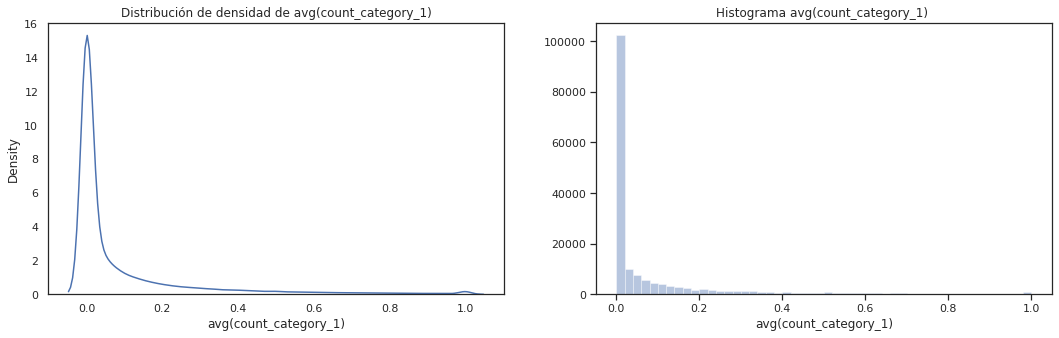

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable avg(count_category_1) 
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD['avg(count_category_1)']).set(title='Distribución de densidad de avg(count_category_1)')
ax1= fig.add_subplot(122)
sns.set_theme(style="ticks")
sns.distplot(ELO_BBDD['avg(count_category_1)'], kde=False, rug=False).set(title='Histograma avg(count_category_1) ')
plt.show()

La distribución de la variable **avg(count_category_1)** tiene un distribución similar a la distribución logarítmica y tiene un sesgo hacia la derecha. Adicionalmente, se puede observar una alta concentración de datos entre el rango de 0 a 0,08. Igualmente se puede visualizar presencia de datos atípicos. Se puede concluir que la mayoria de usuarios de la tarjeta de crédito se encuentran clasificados en la categoría 0. 

**1.1.2 Variable sum(count_category_1)**

La variable **sum(count_category_1)** representa la suma los valores de la variable anonimizada category_1 del dataset **Historical_transation**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable sum(count_category_1) con el objetivo de conocer sus principales estadísticos.
ELO_BBDD['sum(count_category_1)'].describe()

count    167758.000000
mean          6.128358
std          18.407274
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max         720.000000
Name: sum(count_category_1), dtype: float64

La variable **Sum(count_category_1)** tiene una media de 6.1283 y se encuentra en un rango entre 0 y 720. El 50% de los datos estan etiquetados con 0. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


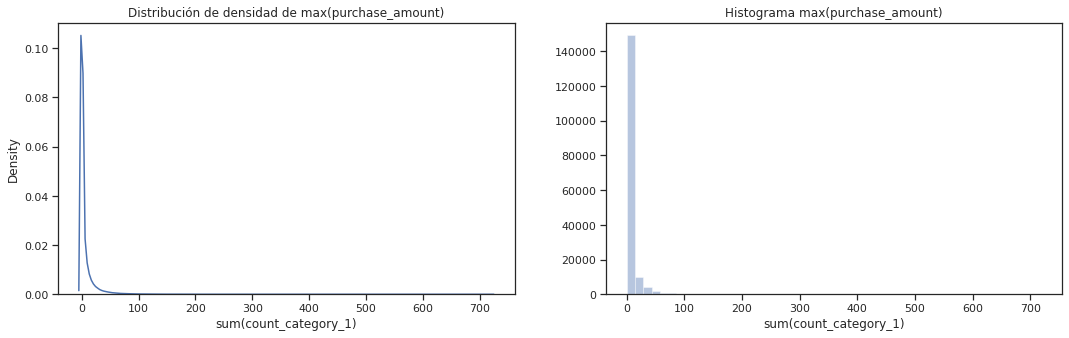

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable sum(count_category_1) 

fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD['sum(count_category_1)']).set(title='Distribución de densidad de max(purchase_amount)')
ax1= fig.add_subplot(122)
sns.distplot(ELO_BBDD['sum(count_category_1)'], kde=False, rug=False).set(title='Histograma max(purchase_amount)')
plt.show()

La distribución de la variable **sum(count_category_1)** tiene un distribución similar a la distribución logarítmica y tiene un sesgo hacia la derecha. Adicionalmente se puede observar una alta concentración de datos entre el rango de 0 a 60.  Se puede concluir que la mayoria de usuarios estan clasificados con unicamente con la etiqueta cero, ya que la suma de sus etiquetas no cambia su clasificación. 

 **1.1.3 Variable avg(installments)**

La variable **avg(installments)** representa el promedio de la cantidad de cuotas de las compras registradas en el dataset **Historical_transation**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable avg(installments) con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['avg(installments)'].describe()

count    167758.000000
mean          0.846634
std           1.098383
min          -0.111111
25%           0.003413
50%           1.000000
75%           1.338028
max          79.307692
Name: avg(installments), dtype: float64

La variable **avg(installments)** tiene una media de 0.84 y se encuentra en un rango entre -0.111 y 79,30. El 50% de los datos estan etiquetados entre el rango de números menor o igual a 1. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


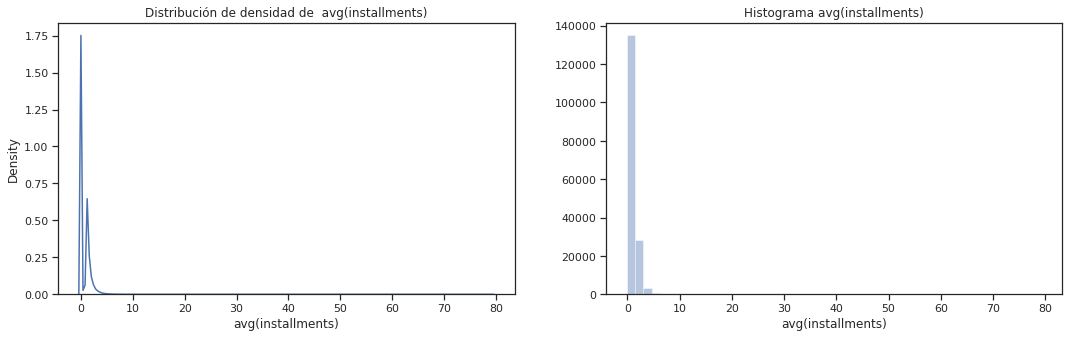

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable  avg(installments)
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD[ 'avg(installments)']).set(title='Distribución de densidad de  avg(installments)')
ax1= fig.add_subplot(122)

sns.distplot(ELO_BBDD[ 'avg(installments)'], kde=False, rug=False).set(title='Histograma avg(installments)')
plt.show()

La distribución de la variable **avg(installments)** tiene un sesgo hacia la derecha. Adicionalmente, se puede observar una alta concentración de datos entre el rango de 0 a 3 aproximadammente. Se puede concluir que la mayoria de usuarios de la tarjeta de crédito deciden pagar sus compras en periodos cortos. Tambien se evidencia que entre más aumenta la cantidad de cuotas menor es su frecuencia. 



**1.1.4 Variable sum(installments)**

La variable **sum(installments)** representa la suma de la cantidad de cuotas de las compras registradas en el dataset **Historical_transation**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable sum(installments) con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['sum(installments)'].describe()

count    167758.000000
mean         61.211167
std         104.082455
min          -2.000000
25%           1.000000
50%          18.000000
75%          82.000000
max        1828.000000
Name: sum(installments), dtype: float64

La variable **sum(installments)** tiene una media de 61.21 y se encuentra en un rango entre -2 y 1828. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


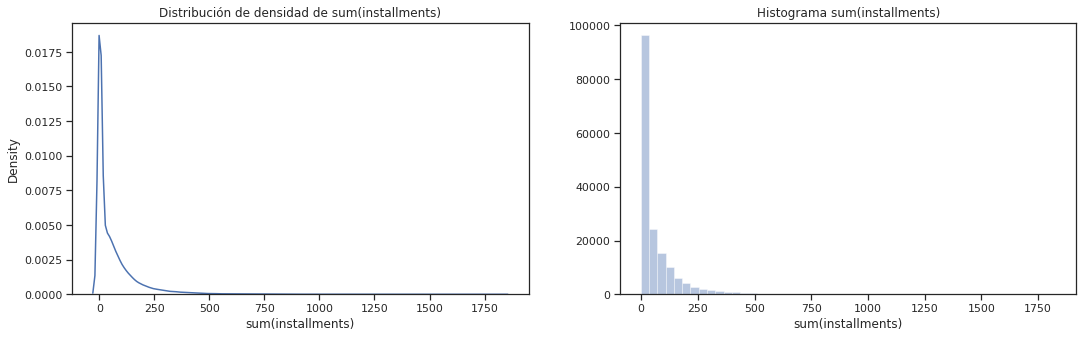

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable  sum(installments)
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD['sum(installments)']).set(title='Distribución de densidad de sum(installments)')
ax1= fig.add_subplot(122)

sns.distplot(ELO_BBDD[ 'sum(installments)'], kde=False, rug=False).set(title='Histograma sum(installments)')
plt.show()

La distribución de la variable sum(installments)tiene un sesgo hacia la derecha. Adicionalmente se puede observar una alta concentración de datos entre el rango de 0 a 250 aproximadammente. Se puede concluir que mientras menor sea la suma de las cuotas mayor es la frecuencia.

**1.1.5 Variable max(month_lag)**

La variable **max(mount_lag)** representa el valor máximo del mes de retraso a la fecha de referencia

In [ ]:
#LPS &OSR: Se realiza el describe de la variable max(month_lag) con el objetivo de conocer sus principales estadísticos.
ELO_BBDD['max(month_lag)'].describe()

count    167758.000000
mean         -0.127350
std           0.520846
min         -11.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.000000
Name: max(month_lag), dtype: float64

La variable **max(month_lag)** tiene una media de -0.1273 y se encuentra en un rango entre -11 y 0. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


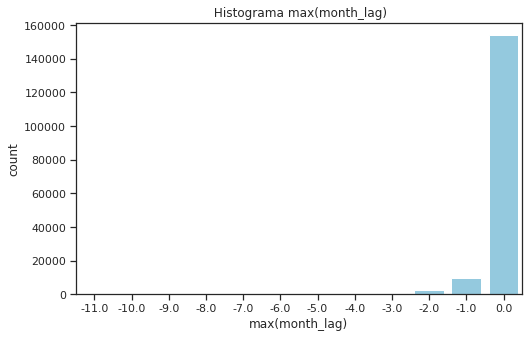

In [ ]:
#LPS & OSR: Se gráfica la de barras para la variable max(month_log) 
fig= plt.figure(figsize=(8,5))
sns.countplot(ELO_BBDD['max(month_lag)'],color="Skyblue").set(title=' Histograma max(month_lag)')
plt.show()

Con respecto al gráfico se puede observar una alta concentración de datos entre la etiqueta de 0, adicionalmente tiene valores iguales o menores a cero.  Se puede concluir que mientras menor sea el **max(month_log)** menor es la frecuencia, es decir, que la mayoria de usuarios de tarjeta de crédito pagan sus compras sin meses de retraso. 

**1.1.6 stddev_samp(month_diff_hist)**

La variable **stddev_samp(month_diff_hist)** representa la desviación estandar de la diferencia entre la fecha actual y las fechas de compras efectuadas por un caid en el dataset **Historical_transactions**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable stddev_samp(month_diff_hist) con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['stddev_samp(month_diff_hist)'].describe()

count    167758.000000
mean          0.212412
std           0.139565
min           0.000000
25%           0.120386
50%           0.234987
75%           0.314696
max           0.781736
Name: stddev_samp(month_diff_hist), dtype: float64

La variable stddev_samp(month_diff_hist) tiene una media de 0,2124 y se encuentra en un rango entre 0 y 0.78. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


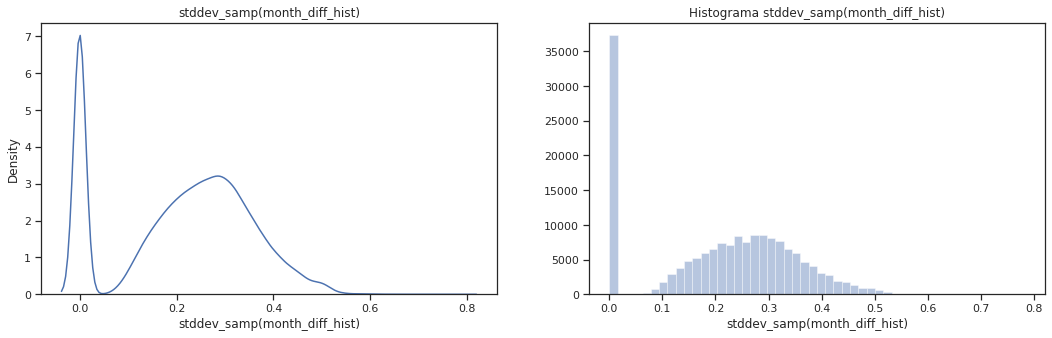

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable stddev_samp(month_diff_hist)
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD[ 'stddev_samp(month_diff_hist)']).set(title='stddev_samp(month_diff_hist)')
ax1= fig.add_subplot(122)
sns.distplot(ELO_BBDD['stddev_samp(month_diff_hist)'], kde=False, rug=False).set(title='Histograma stddev_samp(month_diff_hist)')
plt.show()

La distribución de la variable tiene un comportamiento bimodal, con un pico en cero y otro en aproximadamente 0,28. Los usuarios cuyo valor etiqueta es 0  corresponden a los usuarios que no tienen diferencias en las fechas de compras. Por otro lado, los usuarios que si registran diferencias entre las fechas de compra tienen una desviación estantar entre 0,1 y 0,5 aproximadamente.  

**1.1.7 purchase amount mean**

La variable **purchase_amount_mean** representa el monto de compra promedio de un card_id en el dataset **New_merchants**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable purchase_amount_mean  con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['purchase_amount_mean'].describe()

count    167758.000000
mean         -0.553394
std           0.354184
min          -0.746893
25%          -0.693114
50%          -0.643942
75%          -0.541045
max          23.680881
Name: purchase_amount_mean, dtype: float64

La variable **Purchase amount mean** tiene un promedio de -0,5533, con un rango entre 0,746 y 23,6. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


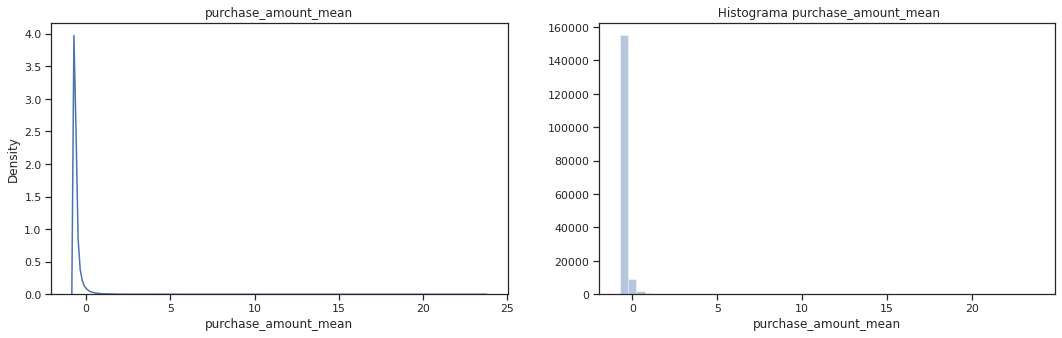

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable  purchase_amount_mean
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD['purchase_amount_mean']).set(title= 'purchase_amount_mean')
ax1= fig.add_subplot(122)
sns.distplot(ELO_BBDD[ 'purchase_amount_mean'], kde=False, rug=False).set(title=' Histograma purchase_amount_mean')
plt.show()

La distribución de la variable **purchase_amount_mean** tiene un sesgo hacia la derecha. Adicionalmente se puede observar una alta concentración de datos negativos. Se puede concluir que la mayoria de usuarios de la tarjeta de crédito en registran montos por debajo de cero. 

**1.1.8 purchase_amount_amax**




La variable **purchase_amount_amax** representa el monto de compra máximo de un card_id en el dataset **New_merchants**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable purchase_amount_amax  con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['purchase_amount_amax'].describe()

count    167758.000000
mean         -0.207249
std           1.143963
min          -0.746893
25%          -0.648649
50%          -0.520451
75%          -0.212415
max          76.682904
Name: purchase_amount_amax, dtype: float64

La variable **purchase_amount_amax** tiene una media de -0.2072 y se encuentra en un rango entre -0.74 y 76. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


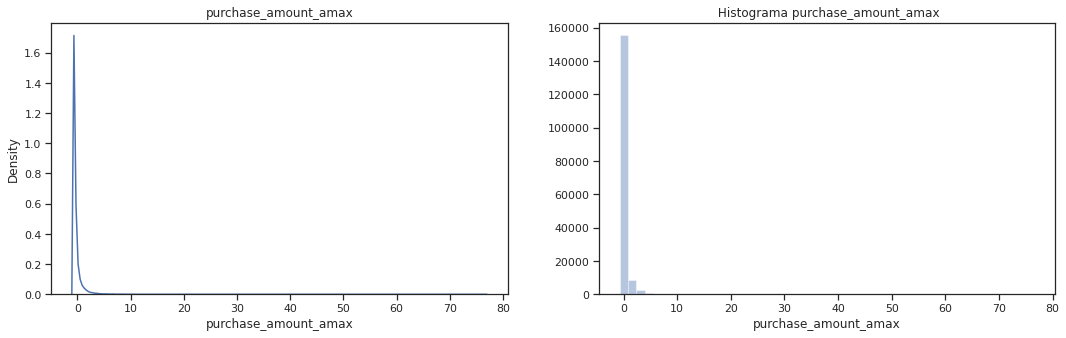

In [ ]:
# #LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable  purchase_amount_amax
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD[ 'purchase_amount_amax']).set(title= 'purchase_amount_amax')
ax1= fig.add_subplot(122)
sns.distplot(ELO_BBDD[ 'purchase_amount_amax'], kde=False, rug=False).set(title=' Histograma purchase_amount_amax')
plt.show()

La distribución de la variable **purchase_amount_amax** tiene un distribución 
similar a la distribución logarítmica y tiene un sesgo hacia la derecha. Adicionalmente se puede observar una alta concentración de datos esta en la etiqueta 0. Se puede concluir que la mayoria de usuarios de tarjetas de crédito no han realizado transacciones en el periodo de tiempo en el que se recopilaron los datos de New_merchants

**1.1.9 purchase_amount_sum**

La variable **purchase_amount_sum** representa la suma de los monto de compra de un card_id en el dataset **New_merchants**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable purchase_amount_amax  con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['purchase_amount_sum'].describe()

count    167758.000000
mean         -3.832808
std           4.080732
min         -63.907274
25%          -5.308288
50%          -2.754022
75%          -1.290958
max          98.189975
Name: purchase_amount_sum, dtype: float64

La variable **Purchase_amount_sum** tiene un promedio de -3,83, con un rango entre -63,90 y 98,1. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


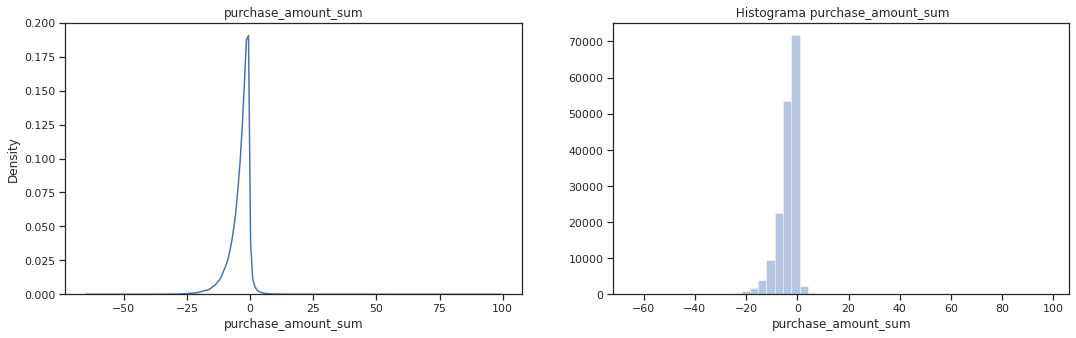

In [ ]:
# LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variablepurchase_amount_sum
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD[ 'purchase_amount_sum']).set(title= 'purchase_amount_sum')
ax1= fig.add_subplot(122)

sns.distplot(ELO_BBDD[ 'purchase_amount_sum'], kde=False, rug=False).set(title=' Histograma purchase_amount_sum')
plt.show()

La distribución de la variable purchase_amount_sum tiene un sesgo hacia la izquierda. Adicionalmente se puede observar una alta concentración de datos negativos. 

**1.1.10 installments_mean**

La variable **installments_mean** representa el promedio de la cantidad de cuotas de las compras efectuadas por un card_id en el dataset **New_merchants**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable  Installments_mean  con el objetivo de conocer sus principales estadísticos.
ELO_BBDD['installments_mean'].describe()

count    167758.000000
mean          0.727637
std           1.048083
min          -1.000000
25%           0.000000
50%           0.500000
75%           1.000000
max          12.000000
Name: installments_mean, dtype: float64

La variable **Installments_mean** tiene un promedio de 0,727, con un rango entre -1 y 12. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


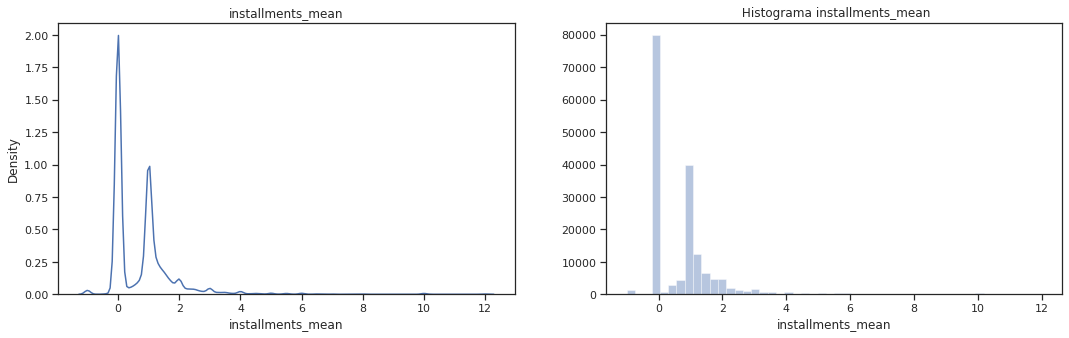

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable installments_mean
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD[ 'installments_mean']).set(title= 'installments_mean')
ax1= fig.add_subplot(122)
sns.distplot(ELO_BBDD[ 'installments_mean'], kde=False, rug=False).set(title=' Histograma installments_mean')
plt.show()

La distribución de la variable **Installments_mean** tiene un comportamiento bimodal, con un pico en cero y otro en aproximadamente 1,3. 
Se evidencia que la mayoria de usuarios prefieren pagar sus compras a cero cuotas.  Por otro lado, los usuarios que deciden pagar sus compras a cuotas, no optan por hacer compras a muchas cuotas.

**1.1.11 month_lag_mean**

La variable **mount_lag_means** representa el valor promedio del mes de retraso a la fecha de referencia en el dataset **New_merchants**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable month_lag_mean con el objetivo de conocer sus principales estadísticos.
ELO_BBDD['month_lag_mean'].describe()

count    167758.000000
mean          1.475657
std           0.326447
min           1.000000
25%           1.250000
50%           1.500000
75%           1.700000
max           2.000000
Name: month_lag_mean, dtype: float64

La variable **month_lag_mean** tiene un promedio de 1,47, con un rango entre 1 y 2. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


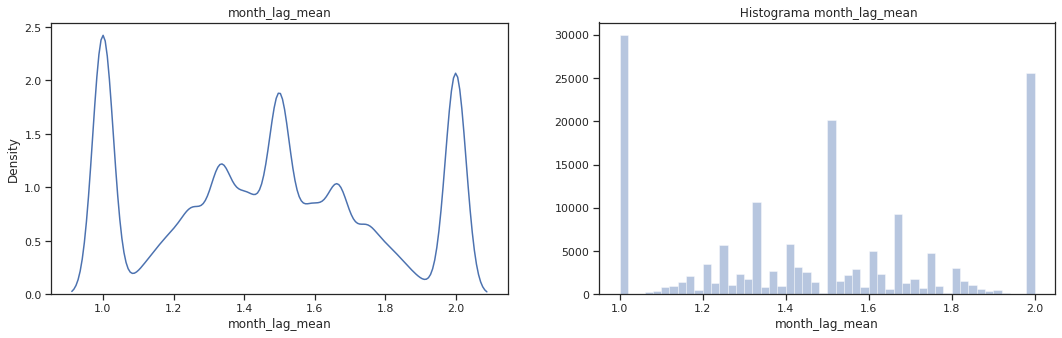

In [ ]:
 #LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variablemonth_lag_mean
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD[ 'month_lag_mean']).set(title= 'month_lag_mean')
ax1= fig.add_subplot(122)

sns.distplot(ELO_BBDD[ 'month_lag_mean'], kde=False, rug=False).set(title=' Histograma month_lag_mean')
plt.show()

Para variable **month_lag_mean** proveniete de la agreación del conjunto de **datos New_merchants** se puede evidenciar en el grafico de densidad que hay 3 puntos donde hay mayor densidad de los datos: 1, 1,5 y 5. Adicionalmente en la distribución del gráfico se observa un comportamiento simetrico. 

**1.1.12 month_lag_amax**

La variable **mount_lag_max** representa el valor máximo del mes de retraso a la fecha de referencia en el dataset **New_merchants**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable purchase_amount_amax  con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['month_lag_amax'].describe()

count    167758.000000
mean          1.821618
std           0.382835
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: month_lag_amax, dtype: float64

La variable **month_lag_amax** tiene un promedio de 1,82, con un rango entre 1 y 2. Adicionalente mas del 75% de los datos estan distribuidos en la etiqueta 2. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


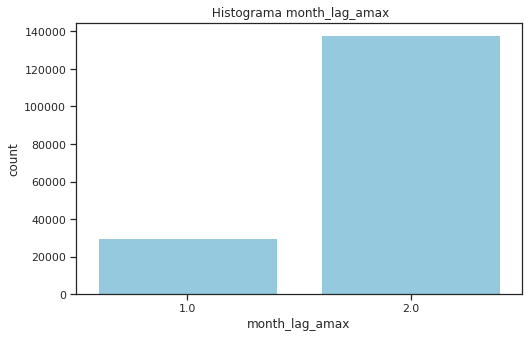

In [ ]:
#LPS & OSR: Se gráfica la de barras para la variable month_lag_amax
fig= plt.figure(figsize=(8,5))
sns.countplot(ELO_BBDD['month_lag_amax'],color="Skyblue").set(title=' Histograma month_lag_amax')
plt.show()

Con respecto a la variable **month_lag_amax** se puede evidenciar que la mayoria de datos estan concentrados en la etiqueta 2. 

**1.1.13 month_lag_std**

La variable **mount_lag_std** representa el valor de la desviación estandar de los meses de retraso a la fecha de referencia en el dataset **New_merchants**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable purchase_amount_amax  con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['month_lag_std'].describe()

count    167758.000000
mean          0.414910
std           0.211777
min           0.000000
25%           0.408248
50%           0.500000
75%           0.527046
max           0.707107
Name: month_lag_std, dtype: float64

La variable **month_lag_std** tiene un promedio de 0,41, con un rango entre 0 y 0,7071. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


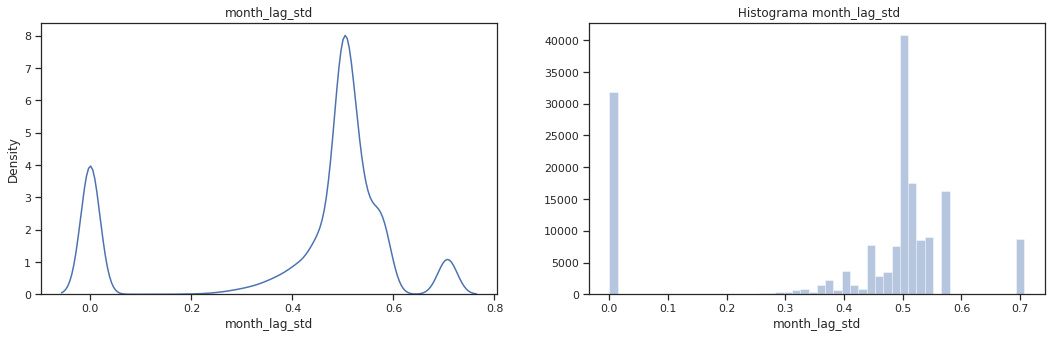

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variablemonth_lag_std
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD[ 'month_lag_std']).set(title= 'month_lag_std')
ax1= fig.add_subplot(122)

sns.distplot(ELO_BBDD[ 'month_lag_std'], kde=False, rug=False).set(title=' Histograma month_lag_std')
plt.show()

Por lo que se refiere a la distribución de la **variable month_lag_std**  tiene un sesgo hacia la izquierda. Adicionalmmente la mayoria de datos estan distribuidos en el rango de 0,4 a 0,6, asimismo, cuenta con dos puntos con una concentración notoria de usuarios, como son: 0 y 0,7. Se puede concluir que los usuarios marcados con cero, posiblemente no hayan realizado más de una compra o en ninguna de sus compras tienen meses de retrado. Asimismo, se puede observar que los usuarios generalmente tienen una desviación estandar en los meses de retraso cercana a 0.5. 

**1.1.14 month_diff_std**

La variable **month_diff_std** representa la desviación estandar de las diferencias de la fecha actual entre las fechas de compra en el dataset **New_merchants.**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable purchase_amount_amax  con el objetivo de conocer sus principales estadísticos.
ELO_BBDD['month_diff_std'].describe()

count    167758.000000
mean          0.061595
std           0.151294
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.414214
Name: month_diff_std, dtype: float64

La variable **month_diff_std**  tiene una media de 0,0615 y un tiene un rango entre 0 y 1,46. Por otro lado, el 75% de los datos estan etiquetados con 0. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


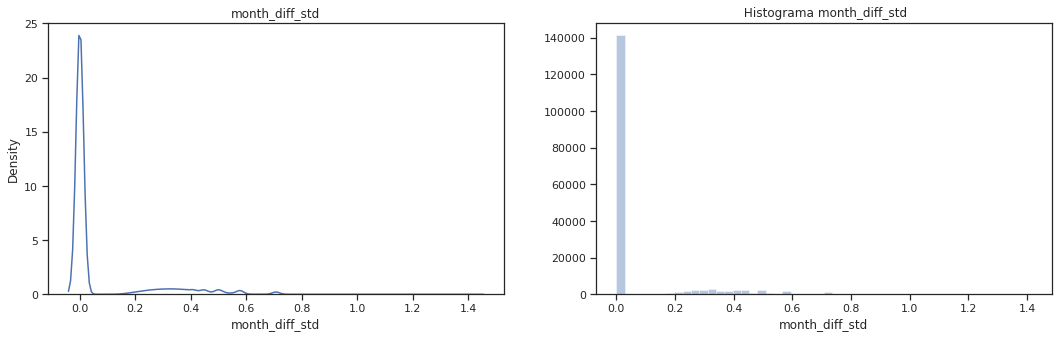

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable month_diff_std
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD['month_diff_std']).set(title= 'month_diff_std')
ax1= fig.add_subplot(122)
sns.distplot(ELO_BBDD['month_diff_std'], kde=False, rug=False).set(title=' Histograma month_diff_std')
plt.show()

Inicialmente se puede evidenciar que la variable **month_diff_std** está distribuida en sus gran mayoría en el valor cero. Asimismo, los demás valores no tienen frecuencias potencialmente considerables.  Se puede concluir que la mayoria de transacciones realizadas por los usuarios de tarjeta en el conjunto de datos New_merchants solo ha realizado una compra y por ende no hay variación entre las  fechas de sus compras. 

**1.1.15 target**

Laa variable **target**, es un score calculado para medir la lealtad de los titulares de la tarjeta de crédito. 

In [ ]:
#LPS &OSR: Se realiza el describe de la variable target con el objetivo de conocer sus principales estadísticos.
ELO_BBDD['target'].describe()

count    167758.000000
mean         -0.119358
std           1.512581
min         -17.492640
25%          -0.847826
50%          -0.050817
75%           0.657477
max          14.855160
Name: target, dtype: float64

La variable **target**  tiene una media de de -0.11 y esta distribuida en un rango de -17.49 a 14.85. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


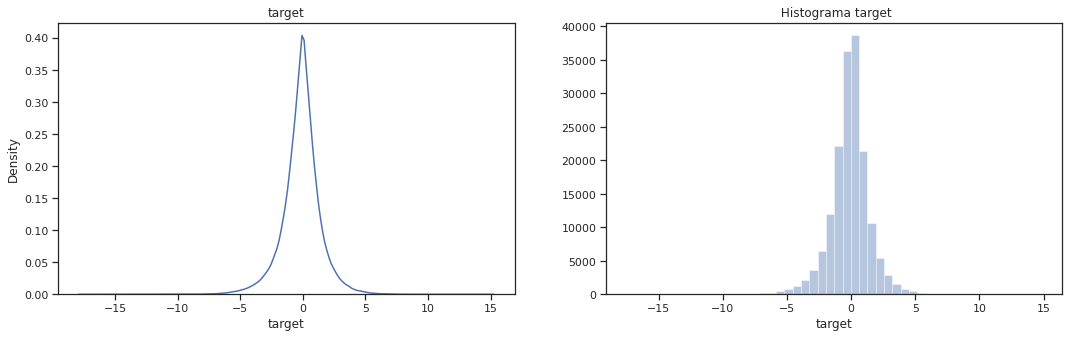

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variable target
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD['target']).set(title= 'target')
ax1= fig.add_subplot(122)
sns.distplot(ELO_BBDD['target'], kde=False, rug=False).set(title=' Histograma target')
plt.show()

La variable **target**, es un score calculado para medir la lealtad de los titulares de la tarjeta de credito. Se evidencia que esta variable tiene en su dominio tanto valores negativos como positivos.

Sin embargo, esta distribucion cuenta con una fuerte presencia de datos atipicos que se encuentran bilateralamente distribuidos en la variable.
En igual medida, graficamente, se logra deducir una forma leptokurtica, lo que permite inferir que la mayoria de los datos se encuentran cercanos a la media.

**1.1.16 elapsed_time**

La variable **elapsed_time** explica el tiempo transcurido entre la fecha más activacion de activación menos el first_active_month de cada caid_id unico contenido en el dataset **train**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable target con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['elapsed_time'].describe()

count    167758.000000
mean        369.009234
std         286.212554
min          31.000000
25%         153.000000
50%         306.000000
75%         488.000000
max        2284.000000
Name: elapsed_time, dtype: float64

La variable **elapsed_time**  tiene una media de de 369 y esta distribuida en un rango de 31 a 2284.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


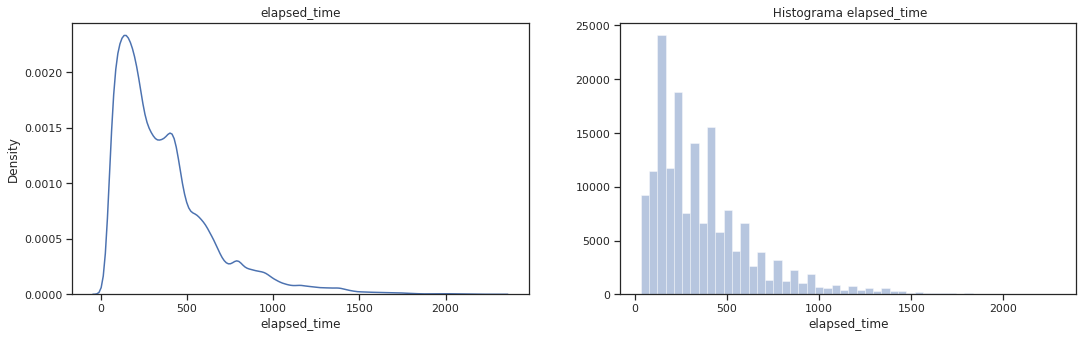

In [ ]:
##LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variabl elapsed_time
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD['elapsed_time']).set(title= 'elapsed_time')
ax1= fig.add_subplot(122)

sns.distplot(ELO_BBDD['elapsed_time'], kde=False, rug=False).set(title=' Histograma elapsed_time')
plt.show()

La  variable **elapsed** tiene un distribución similar a la distribución logarítmica y tiene un sesgo hacia la derecha. Del mismo modo, se puede observar que unicamente tiene valores en el dominio de números positivos. Adicionamente puede apreciar que el rango de antiguedad entre la primera activación y la fecha más reciente es amplio. También, se puede visualizar que la mayoría de clientes tienen menos de 300 días de antiguedad. Finalmente se puede constatar que mientras mís días de activación menor es la frecuencia, es decir, que hay mas clientes nuevos que antiguos.

**1.1.17 Diff_max_min_new**

La variable **Diff_max_min_new** representa la diferencia entre las fechas de  compras registradas por un usuario de tarjeta de crédito en en el dataset New_merchants.

In [ ]:
#LPS &OSR: Se realiza el describe de la variable target con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['Diff_max_min_new'].describe()

count    167758.000000
mean         29.571424
std          19.865249
min           0.000000
25%          10.000000
50%          33.000000
75%          47.000000
max          61.000000
Name: Diff_max_min_new, dtype: float64

La variable **Diff_max_min_new**  tiene una media de de 29,57 y esta distribuida en un rango de 0 a 61.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


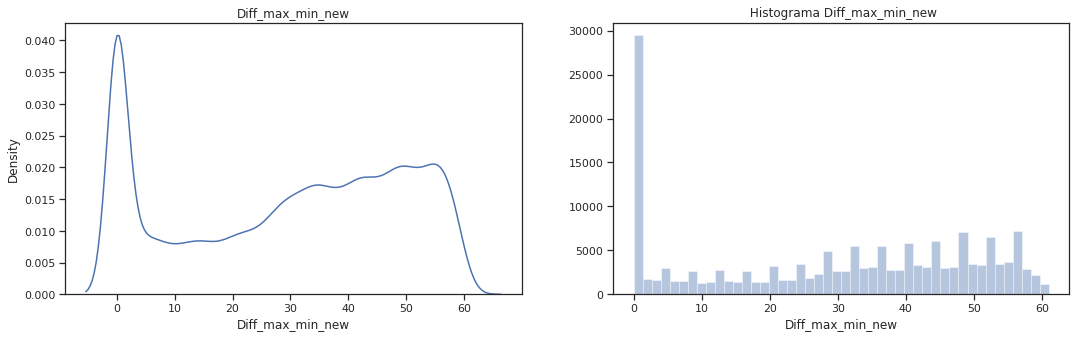

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variabl Diff_max_min_new
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD['Diff_max_min_new']).set(title= 'Diff_max_min_new')
ax1= fig.add_subplot(122)
sns.distplot(ELO_BBDD['Diff_max_min_new'], kde=False, rug=False).set(title=' Histograma Diff_max_min_new')
plt.show()

La distribución de la variable tiene un comportamiento bimodal, con un pico en cero . Se puede concluir que la mayoria de usuarios no tienen diferencias en las fechas de sus compras registradas en en el dataset New_merchants. Adicionalmente se puede evidenciar que las usuarios que tienen días de diferencia en sus compras tienen una distribución uniforme con un crecimiento gradual moderado. 

**1.1.18 ratio_purchase_amount**

La variable **ratio_purchuse_amount** representa la tasa de crecimiento entre la suma de las compras efectuadas por un card_id en el dataset New_mechants sobre las compras efectuadas en el datase Historical_transation.

In [ ]:
#LPS &OSR: Se realiza el describe de la variable target con el objetivo de conocer sus principales estadísticos.
ELO_BBDD['ratio_purchase_amount'].describe()

count    167758.000000
mean          0.164403
std           4.749311
min        -239.403742
25%           0.029826
50%           0.072703
75%           0.169232
max         853.939352
Name: ratio_purchase_amount, dtype: float64

La variable **ratio_purchase_amount:**  tiene una media de de 0,16 y esta distribuida en un rango de -239.40 a 853.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


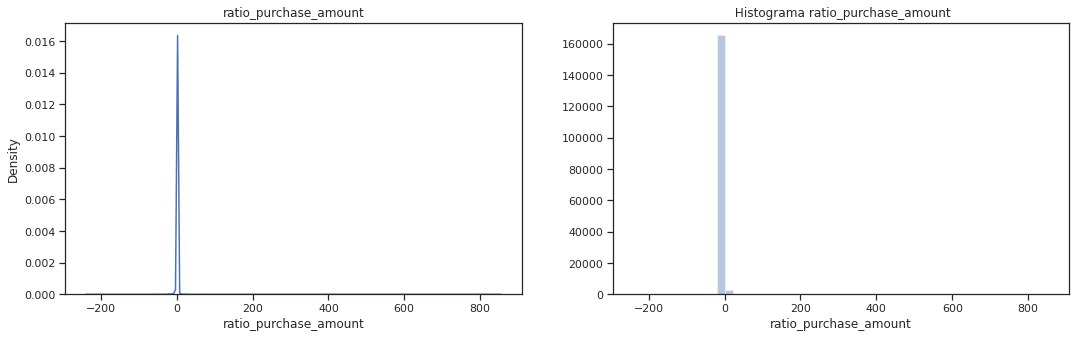

In [ ]:
#LPS & OSR: Se gráfica la distribución de densidad y el histograma para la variabl city_id_nunique
fig= plt.figure(figsize=(18,5))
ax1= fig.add_subplot(121)
sns.set_theme(style="ticks")
sns.kdeplot(ELO_BBDD['ratio_purchase_amount']).set(title= 'ratio_purchase_amount')

ax1= fig.add_subplot(122)
sns.distplot(ELO_BBDD['ratio_purchase_amount'], kde=False, rug=False).set(title=' Histograma ratio_purchase_amount')
sns.set_theme(style="ticks")

plt.show()

Con respecto a la varible **ratio_purchase_amount** esta distribución cuenta con una fuerte presencia de datos atipicos que se encuentran bilateralamente distribuidos en la variable. La variable esta distribuida en su mayoría en rangos positivos, es decir, que la mayoría de usuarios aumentaros los montos de compras en New_merchants con respecto a Historical transaction.

**1.1.19 city_id_nunique**

La variable **city_id_nunique** representa el número de ciudades diferentes en los cuales un card_id efectuó una compra en el periodo de datos contenidos en el dataset **New_merchants**

In [ ]:
#LPS &OSR: Se realiza el describe de la variable city_id_nunique con el objetivo de conocer sus principales estadisticos.
ELO_BBDD['city_id_nunique'].describe()

count    167758.000000
mean          2.294764
std           1.594427
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          23.000000
Name: city_id_nunique, dtype: float64

La variable **city_id_nunique** tiene una media de de 2,29 y esta distribuida en un rango de 1 a 23.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


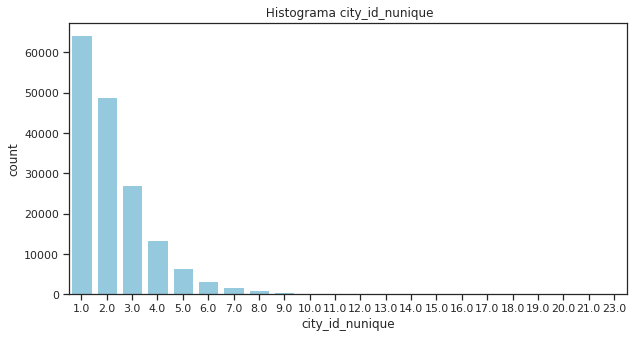

In [ ]:
#LPS & OSR: Se gráfica la de barras para la variable city_id_nunique
fig= plt.figure(figsize=(10,5))
sns.countplot(ELO_BBDD['city_id_nunique'],color="Skyblue").set(title=' Histograma city_id_nunique')
plt.show()

Para variable la **city_id_nunique** según el diagrama de barras se evidencía que la frecuencia de usuarios disminuye a medida que la variable aumenta. Adicionallmente se evidencia  que la mayoria de personas han hecho sus compras a lo sumo en 2 ciudades.  También se puede destacar que hay presencia de datos atípicos. 

#### **1.2 Variables Cualitativas**

Las variables **feature_i** representan categorías anonimizadas dentro del conjunto de datos **Train**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


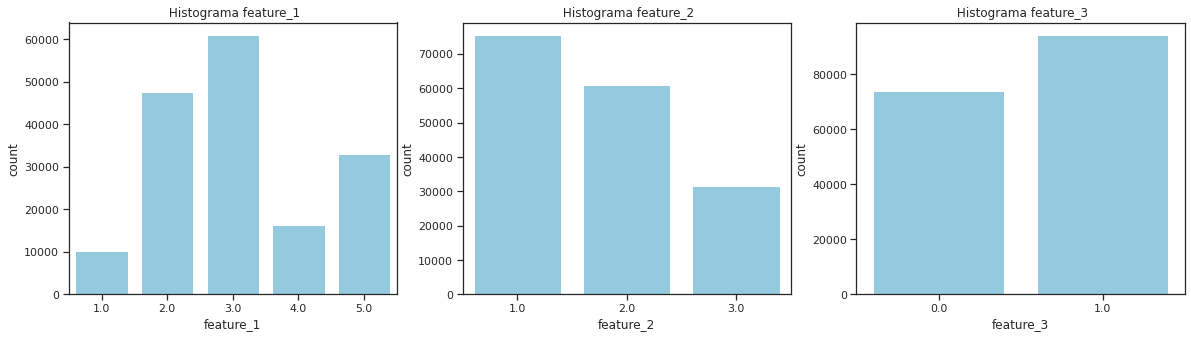

In [ ]:
#LPS & OSR: Se gráfica la de barras para la variables feature_i
fig= plt.figure(figsize=(20,5))


ax1= fig.add_subplot(131)
sns.countplot(ELO_BBDD['feature_1'],color="Skyblue").set(title=' Histograma feature_1')
ax1= fig.add_subplot(132)
sns.countplot(ELO_BBDD['feature_2'],color="Skyblue").set(title=' Histograma feature_2')
ax1= fig.add_subplot(133)
sns.countplot(ELO_BBDD['feature_3'],color="Skyblue").set(title=' Histograma feature_3')


plt.show()

Los graficos evidencian que aunque las variables tienen atributos con diferentes frecuencias, no se presenta una predominancia importante en un atributo por lo cual inicialmente se puede considerar que las variables pueden aportar información importante para describir la variable objetivo target.

Se puede visualizar en que en la variable feature_1 el atributo con más frecuencia es 3. Tambien se puede observar que aproximadamente el 64% de los clientes esta distribuido entre los atributos 3 y 2. Adicionalmente se puede apreciar que la frecuencia de los demás atributos va decreciendo gradualmente.

En la variable feature_2 se puede evidenciar que el atributo que tiene más frecuencia es el 1, con aproximadamente 43,5% de los clientes, junto con el atributo 2 conforman el pareto de los clientes. 

Para el feature_3 los datos entan distribuidos muy equitativamente sin embargo el abributo predimante es el atributo 1 con el 59% de los clientes. 

###  **2. Analisis multivariable**

**2.1 Distribución de target por features**

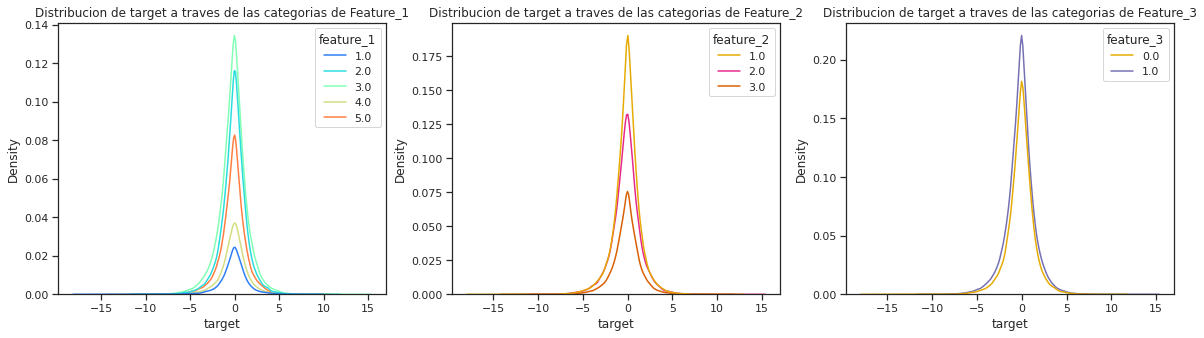

In [ ]:
#LSP &OSR Se gráfica las de distribución target a través de las categorías feature_1
plt.figure(figsize=(20,5))
plt.subplot(131)
sns.kdeplot(x ='target',data = ELO_BBDD, hue = 'feature_1',palette='rainbow')
plt.title('Distribucion de target a traves de las categorias de Feature_1')
plt.subplot(132)
sns.kdeplot(x ='target',data = ELO_BBDD,hue = 'feature_2',palette='Dark2_r')
plt.title('Distribucion de target a traves de las categorias de Feature_2')
plt.subplot(133)
sns.kdeplot(x ='target',data = ELO_BBDD,hue = 'feature_3',palette='Dark2_r')
plt.title('Distribucion de target a traves de las categorias de Feature_3')
plt.show()

Se puede concluir a partir de los graficos de densidad de la variable target respecto a los niveles de los distintos  featuresi  con  i=1,2,3 , que estas características, las cuales son propias del tipo de tarjeta de crédito, no se logran discriminar el comportamiento de la variable respuesta.

Esto se constata en la medida que la densidad de la distribucion target para cada uno de los niveles de cada  features_i  muestra el mismo comportamiento, solo que con mayor o menor densidad.

**2.2 Correlación de variables cuantitavias con Target**

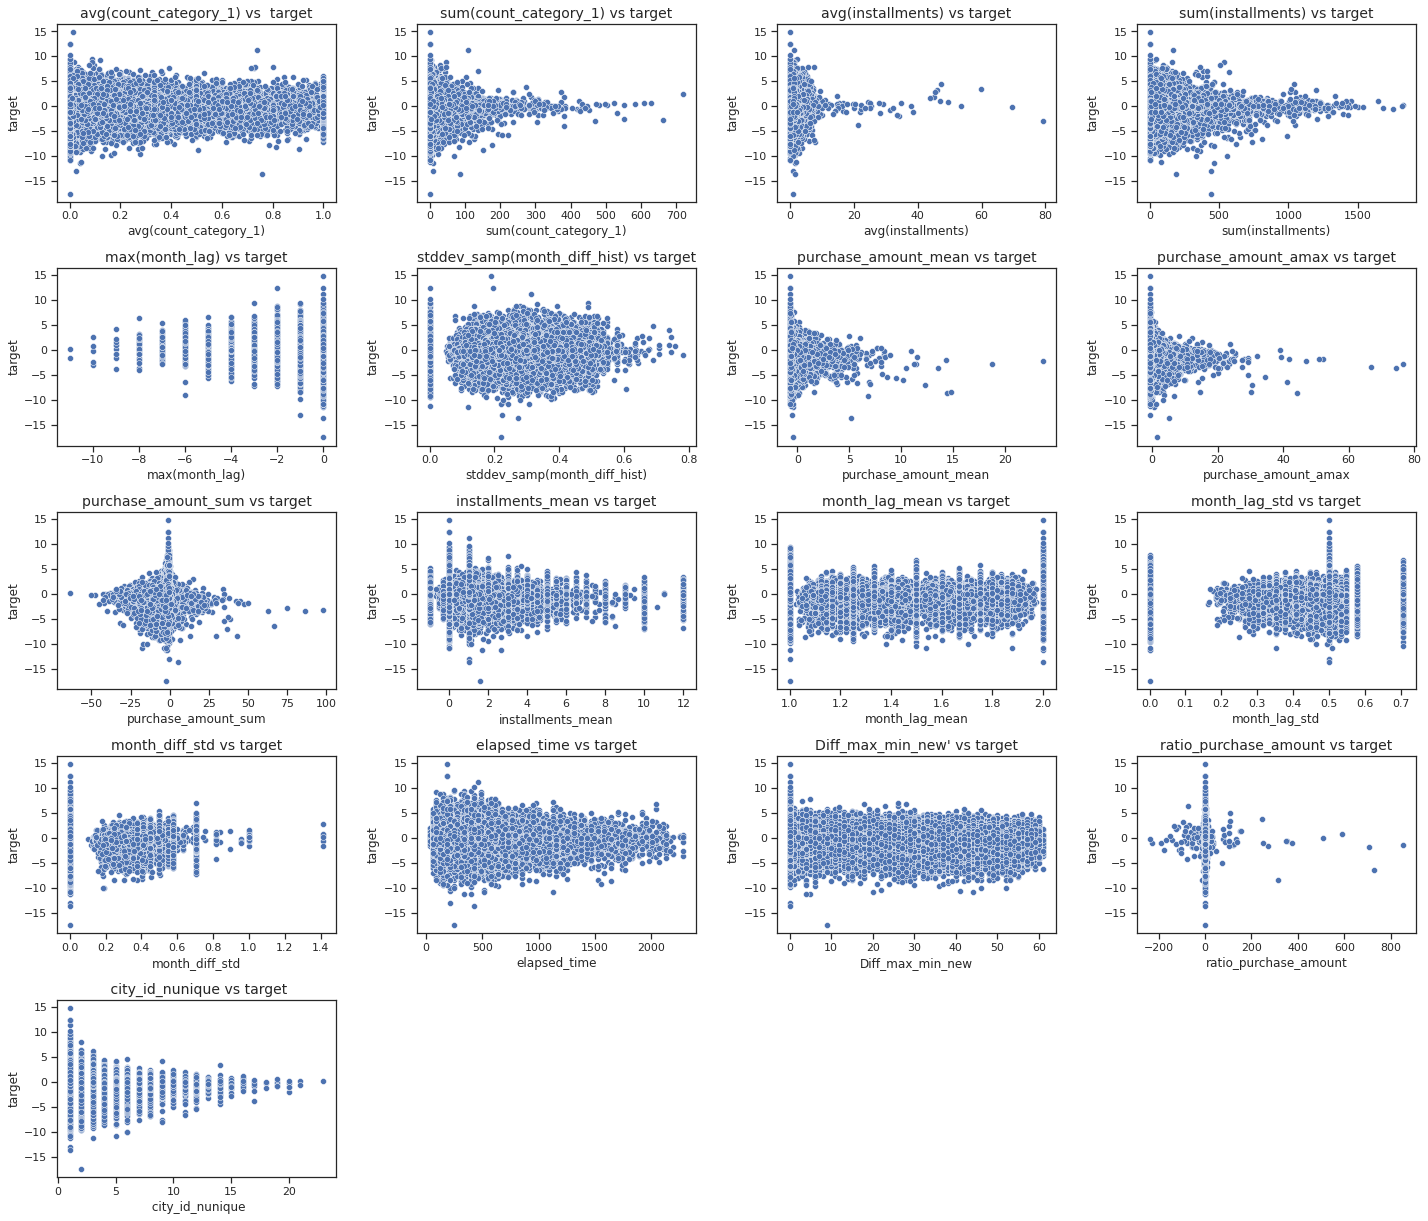

In [ ]:
#LPS &OSR : Se realiza la correlación de cada variable cuantitativa del dataset vs la variable target, con el objetivo de encontrar patrones en la distribución de los datos. 
plt.figure(figsize=(20,20))

plt.subplot(641)
sns.scatterplot(data=ELO_BBDD, x='avg(count_category_1)', y="target")
plt.title("avg(count_category_1) vs  target", size=14)
plt.xlabel('avg(count_category_1)', size=12)
plt.ylabel("target", size=12)

plt.subplot(642)
sns.scatterplot(data=ELO_BBDD, x='sum(count_category_1)', y="target")
plt.title("sum(count_category_1) vs target", size=14)
plt.xlabel('sum(count_category_1)', size=12)
plt.ylabel("target", size=12)


plt.subplot(643)
sns.scatterplot(data=ELO_BBDD, x='avg(installments)', y="target")
plt.title("avg(installments) vs target", size=14)
plt.xlabel('avg(installments)', size=12)
plt.ylabel("target", size=12)

plt.subplot(644)
sns.scatterplot(data=ELO_BBDD, x='sum(installments)', y="target")
plt.title("sum(installments) vs target", size=14)
plt.xlabel('sum(installments)', size=12)
plt.ylabel("target", size=12)

plt.subplot(645)
sns.scatterplot(data=ELO_BBDD, x='max(month_lag)', y="target")
plt.title('max(month_lag) vs target', size=14)
plt.xlabel('max(month_lag)', size=12)
plt.ylabel("target", size=12)

plt.subplot(646)
sns.scatterplot(data=ELO_BBDD, x='stddev_samp(month_diff_hist)', y="target")
plt.title("stddev_samp(month_diff_hist) vs target", size=14)
plt.xlabel('stddev_samp(month_diff_hist)', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,7)
sns.scatterplot(data=ELO_BBDD, x='purchase_amount_mean', y="target")
plt.title("purchase_amount_mean vs target", size=14)
plt.xlabel('purchase_amount_mean', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,8)
sns.scatterplot(data=ELO_BBDD, x='purchase_amount_amax', y="target")
plt.title("purchase_amount_amax vs target", size=14)
plt.xlabel('purchase_amount_amax', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,9)
sns.scatterplot(data=ELO_BBDD, x='purchase_amount_sum', y="target")
plt.title("purchase_amount_sum vs target", size=14)
plt.xlabel('purchase_amount_sum', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,10)
sns.scatterplot(data=ELO_BBDD, x='installments_mean', y="target")
plt.title("installments_mean vs target", size=14)
plt.xlabel('installments_mean', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,11)
sns.scatterplot(data=ELO_BBDD, x='month_lag_mean', y="target")
plt.title("month_lag_mean vs target", size=14)
plt.xlabel('month_lag_mean', size=12)
plt.ylabel("target", size=12)


plt.subplot(6,4,12)
sns.scatterplot(data=ELO_BBDD, x='month_lag_std', y="target")
plt.title("month_lag_std vs target", size=14)
plt.xlabel('month_lag_std', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,13)
sns.scatterplot(data=ELO_BBDD, x='month_diff_std', y="target")
plt.title("month_diff_std vs target", size=14)
plt.xlabel('month_diff_std', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,14)
sns.scatterplot(data=ELO_BBDD, x='elapsed_time', y="target")
plt.title("elapsed_time vs target", size=14)
plt.xlabel('elapsed_time', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,15)
sns.scatterplot(data=ELO_BBDD, x='Diff_max_min_new', y="target")
plt.title("Diff_max_min_new' vs target", size=14)
plt.xlabel('Diff_max_min_new', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,16)
sns.scatterplot(data=ELO_BBDD, x='ratio_purchase_amount', y="target")
plt.title("ratio_purchase_amount vs target", size=14)
plt.xlabel('ratio_purchase_amount', size=12)
plt.ylabel("target", size=12)

plt.subplot(6,4,17)
sns.scatterplot(data=ELO_BBDD, x='city_id_nunique', y="target")
plt.title(" city_id_nunique vs target", size=14)
plt.xlabel(' city_id_nunique', size=12)
plt.ylabel("target", size=12)
plt.tight_layout()

plt.show()

A partir de los distintos diagramas de dispersion realizados entre la variable target y las caracteristicas cuantitativas, se logran inferir las siguentes conclusiones

1. La caracteristicas no explicativas: se logra evidenciar que las variables avg(count_category_1), stddev_samp(mount_diff_hist),month_lag_mean, installmentment_mean, mount_lag_std, ratio_purchase_amount y Diff_max_min_min no están relacionadas con la variable de respuesta, dado que la muestras se distribuyen horizontalemnte a traves del diagrama de dispersion.

2. La relacion de variables potencialemente explicativas: se constata un comportamiento bastante particular en el resto de las variables cuantitativas (a excepcion de las variables mencionadas en el antreliteral),  ya que la relacion entre estas variables no es lineal, sino que tiene una forma de embudo. A menores valores de la  variable−regresora_i , la variable respuesta toma aproximadamente el mismo valor (en magnitud) , y a medida que los valores de la  variable−regresora_i  aumenta, los valores de target convergen a 0. Esto implica que para los valores de target positivos, a medida que la variable regresora incremente, estos valores decrecen. De forma opuesta, para los valores de target negativos, a medida de que  variable−regresorai  aumenta, los valores de target tienden a crecer, hasta aproximandose a 0.

Este comportamiento es lo que crea la forma de embudo.

**2.3 Matriz de correlación**

In [ ]:
#LPS &OSR Se realiza la matriz de correlación para las variables cualitativas del dataset
#LPS &OSR se crea una copia del dataset inicial
ELO_BBDD_V2=ELO_BBDD.copy()
#LSP &OSR se eliminan algunas caracteristicas del dataset
ELO_BBDD_V2.drop(columns=['max(count_authorized_flag)','authorized_flag_mean','authorized_flag_amax','authorized_flag_std'], inplace=True)
#LPS &OSR:Se crea la matriz de correlación por el metodo pearson
corr_df = ELO_BBDD_V2.corr(method='pearson')

display(corr_df)

,avg(count_category_1),sum(count_category_1),avg(installments),sum(installments),max(month_lag),stddev_samp(month_diff_hist),city_id_nunique,purchase_amount_mean,purchase_amount_amax,purchase_amount_sum,installments_mean,month_lag_mean,month_lag_amax,month_lag_std,month_diff_std,target,elapsed_time,Diff_max_min_new,ratio_purchase_amount
avg(count_category_1),1.000000,0.567535,0.420401,0.205204,0.006997,-0.063030,-0.039691,0.148019,0.073235,0.130027,0.341890,0.004540,-0.059878,-0.011767,-0.038631,-0.001505,-0.047936,-0.110522,0.002534
sum(count_category_1),0.567535,1.000000,0.188877,0.512426,0.048414,0.036131,0.081332,0.082131,0.103874,-0.016974,0.190945,-0.005621,-0.000902,-0.003098,0.001840,-0.010299,0.007547,0.015349,-0.005593
avg(installments),0.420401,0.188877,1.000000,0.444465,-0.018688,-0.083968,0.003391,0.235330,0.159104,0.150162,0.540334,0.005485,-0.027825,0.002578,-0.031944,0.037721,-0.068114,-0.060159,0.007909
sum(installments),0.205204,0.512426,0.444465,1.000000,0.073216,0.077820,0.222855,0.136157,0.223883,-0.091529,0.332734,-0.008450,0.051704,0.023098,0.024011,-0.000503,0.028744,0.127802,-0.008693
max(month_lag),0.006997,0.048414,-0.018688,0.073216,1.000000,-0.064948,0.086354,-0.029060,0.021101,-0.100013,-0.000162,-0.058100,0.042183,0.057803,0.037616,-0.046258,-0.076317,0.157665,-0.004295
stddev_samp(month_diff_hist),-0.063030,0.036131,-0.083968,0.077820,-0.064948,1.000000,-0.025798,-0.011353,-0.026465,0.033090,-0.065510,0.010806,-0.028298,-0.025386,0.045678,-0.028939,0.392714,-0.045677,-0.007459
city_id_nunique,-0.039691,0.081332,0.003391,0.222855,0.086354,-0.025798,1.000000,0.007749,0.222225,-0.600366,0.018746,-0.000011,0.243857,0.075800,0.132796,-0.122367,-0.101159,0.482211,0.011200
purchase_amount_mean,0.148019,0.082131,0.235330,0.136157,-0.029060,-0.011353,0.007749,1.000000,0.698053,0.333023,0.390849,0.000670,-0.024372,0.019277,-0.021372,-0.129253,-0.008948,-0.038916,0.035017
purchase_amount_amax,0.073235,0.103874,0.159104,0.223883,0.021101,-0.026465,0.222225,0.698053,1.000000,0.175397,0.252508,-0.000896,0.083479,0.038716,0.037090,-0.152101,-0.066105,0.171119,0.016906
purchase_amount_sum,0.130027,-0.016974,0.150162,-0.091529,-0.100013,0.033090,-0.600366,0.333023,0.175397,1.000000,0.170493,0.003537,-0.269588,-0.094493,-0.166246,0.105225,0.118961,-0.547042,-0.011122


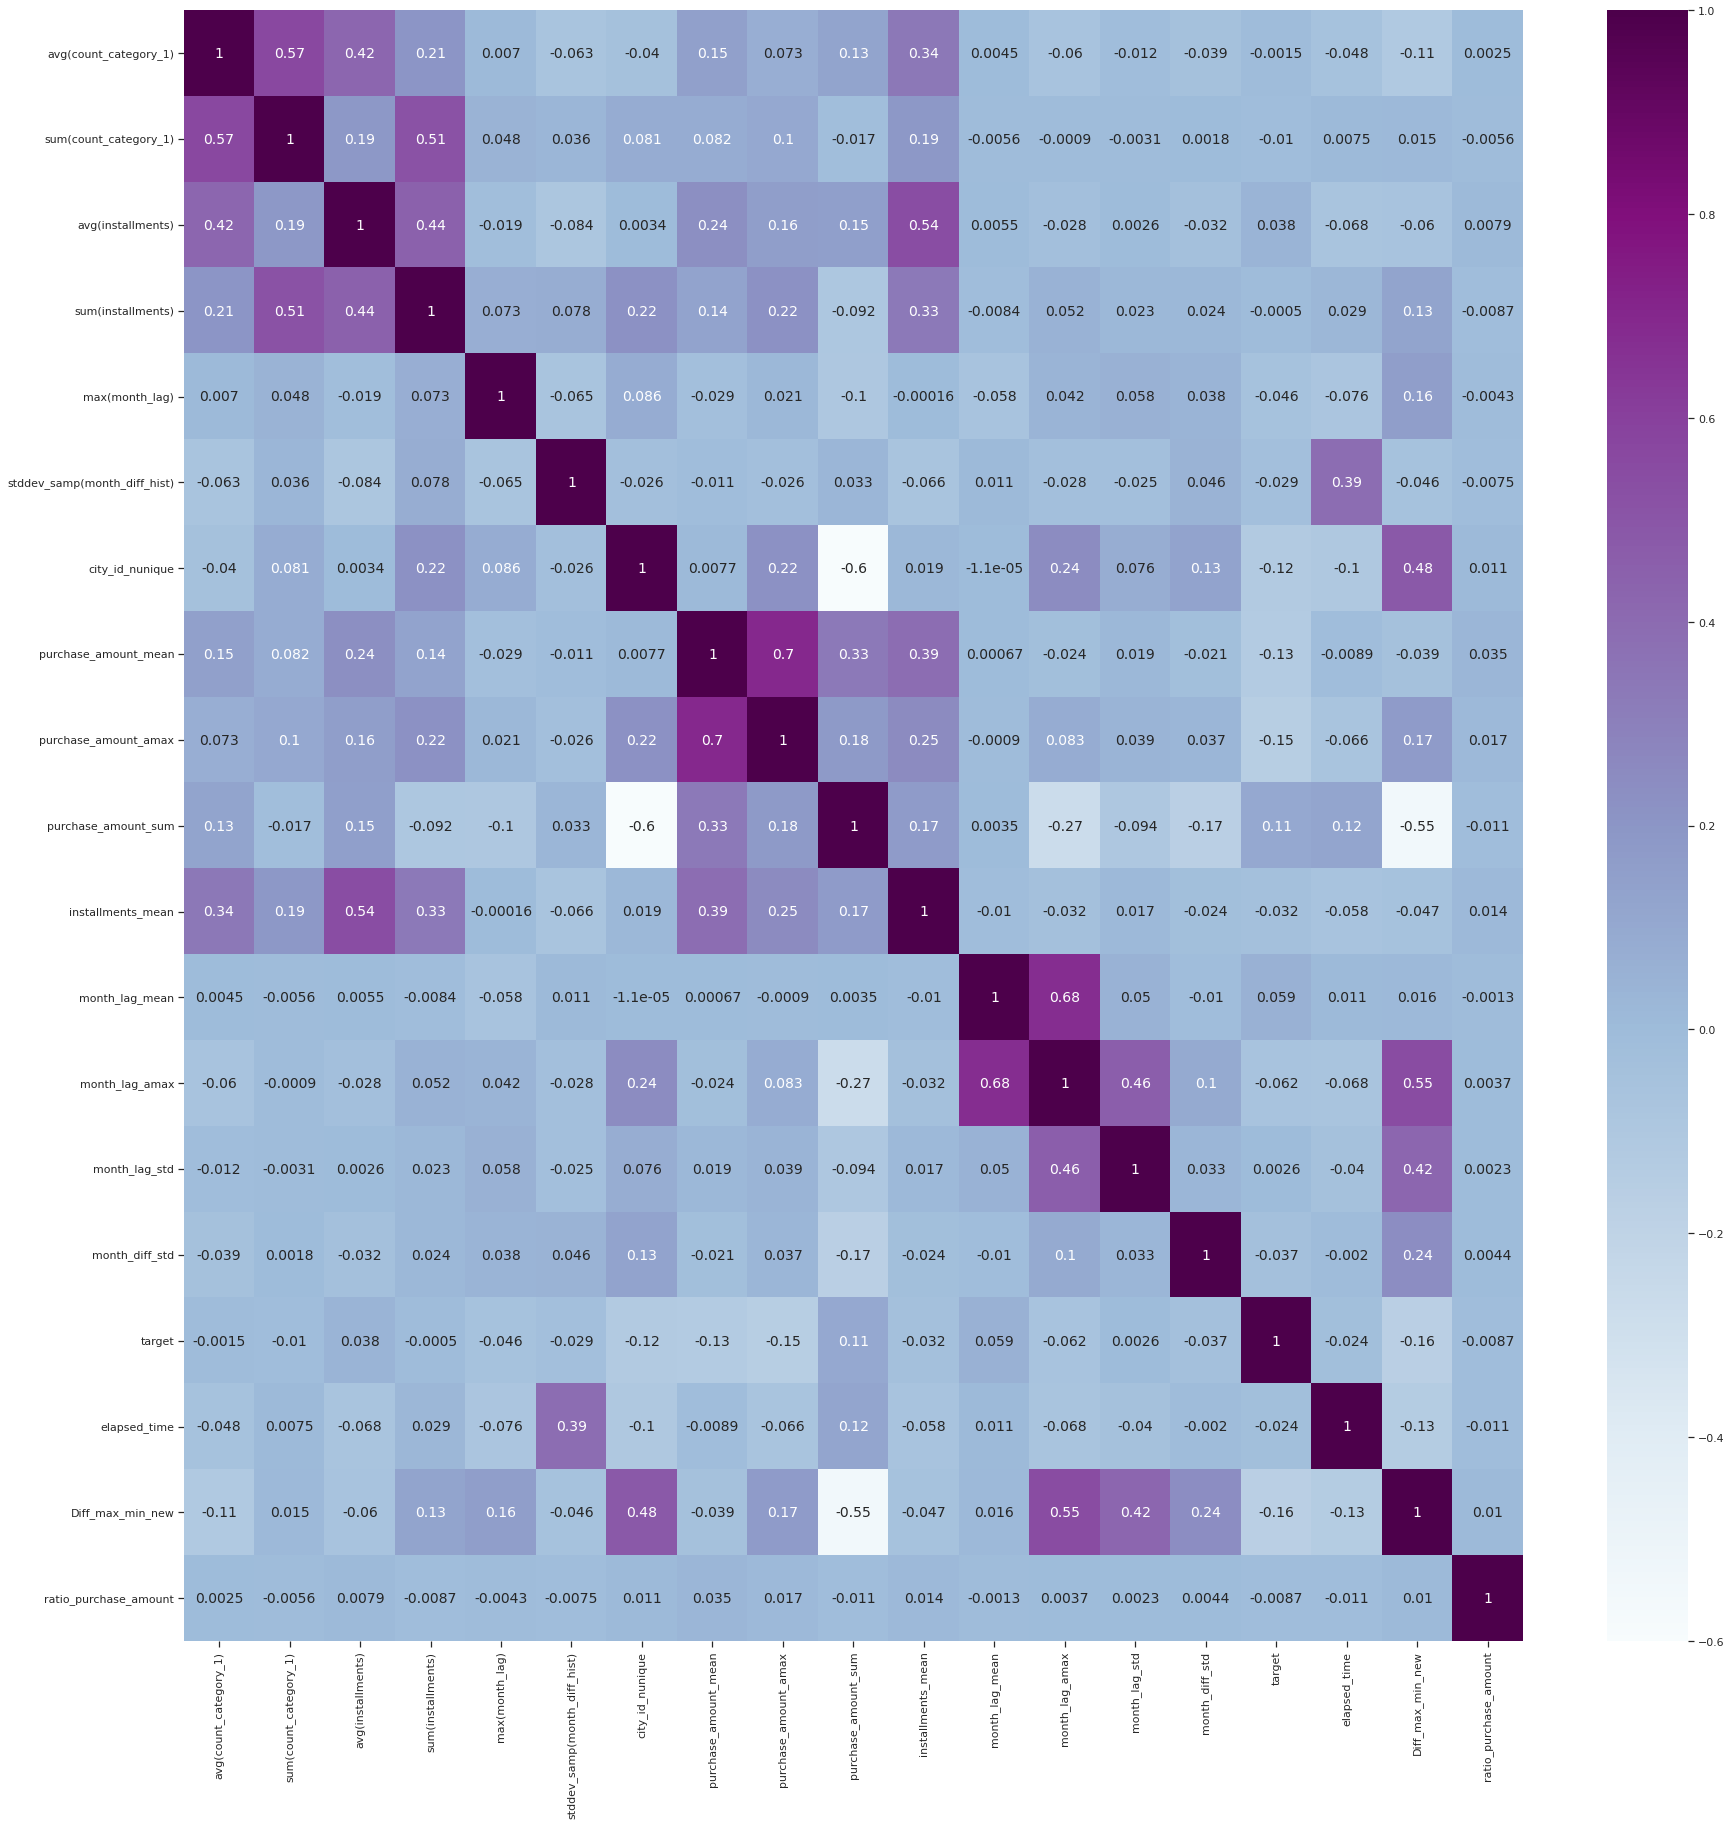

In [ ]:
#LPS & Se realiza el mapa de calor para identificar posibles patrones en la correlación de las variables cualitativas del dataset
plt.figure(figsize=(30, 30))
sns.heatmap(corr_df, annot=True, cmap="BuPu",annot_kws={"size": 14}) 
plt.show()

Teniendo en cuenta el gráfico anterior, no se evidencia algún tipo de correlación  de la variable objetivo  **target** con respecto a las variables del conjunto de datos **ELO_BBDD.**

Las variables que presentan una **correlación moderada alta** entre ellas son: 

* purchase_amount_mean vs purchase_amount_amax
* month_lag_mean vs month_lag_amax

Las variables que presentan una **correlación moderada** entre ellas son: 

* sum(count_category_1) vs avg(count_category_1)
* avg(count_category_1) vs avg(intallments)
* sum(installments) vs sum(count_category_1)
* avg(intallments) vs sum(installments)
* installents_mean vs  avg(installments)
* Diff_max_min_new vs city_id_unique

Las variables que presentan una **correlación baja** entre ellas son: 

* installents_mean vs avg(count_category_1)
* sum(installments) vs installment_mean
* stddev_samp(month_diff_hist vs elapsed_time
* purchase_amount_mean vs  purchase_amount_sum
* purchase_amount_mean vs installment_mean

Adicionalente no se evidencia la existencia de relaciones lineales
entre dos o mas variables del dataset. 

### **3. Estandarización de variables cuantitativas y codificación de variables cualitativas**

En esta sección se realizará un **Pipeline** que contiene dos pasos: el primero escala las variables cuantitativas y el segundo transforma las variables cualitativas a través de la técnica OneHotEncoded. 

In [ ]:
# LPS &OSR Se realia una copia del dataset original sin la vribale target
#LPS &OSR: Se elimina la variable target
ELO_BBDD_sin_target =ELO_BBDD.copy()
ELO_BBDD_sin_target.drop(columns=['target'], inplace=True)

In [ ]:
#LPS &OSR: Se clasifican las variables del dataset obtenido en la sección anterior entre variable númericas y categoricas.
numeric_features = ELO_BBDD_sin_target.select_dtypes(include=['float32', 'float64', 'int16', 'int32', 'int64', 'int8']).columns.to_list()
categorical_features = ELO_BBDD_sin_target.select_dtypes(include=['category', "string"]).columns.to_list()

In [ ]:
#LPS &OSR Transformaciones para las variables numéricas ( se escalan las variablas cuantitativas a través del metodo standard scaler)
numeric_transformer = Pipeline(
                        steps=[
                            ('scaler', StandardScaler())
                        ])

# Transformaciones para las variables categóricas ( procesan  las variablas cualitativas  a través del metodo onehotencoded)
categorical_transformer = Pipeline(
                        steps=[
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                        ])

preprocessor = ColumnTransformer(
                transformers=[
                            ('numeric', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                    ]) 

In [ ]:
# LPS &OSR: Se estancia el pipe
pipe = Pipeline([("preprocessor", preprocessor)])

In [ ]:
#LPS &OSR: Se ajusta el pipeline al dataset obtenido en el apartado anterior
pipe.fit(ELO_BBDD_sin_target)
preprocessed_data = pipe["preprocessor"].transform(ELO_BBDD_sin_target)
preprocessed_data 

array([[ 0.        , -0.48475983, -0.33293229, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.03028867, -0.16995275, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , -0.448208  , -0.27860578, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.        , -0.48475983, -0.33293229, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  4.70864588,  0.26465934, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , -0.48475983, -0.33293229, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
#LPS &OSR: Se crea una lista con los nombres de las nuevas variables obtenidas después del proceso del pipeline
categorical_features_names=['feature_1(1)', 'feature_1(2)', 'feature_1(3)', 'feature_1(4)', 'feature_1(5)', 'feature_2(1)', 'feature_2(2)', 'feature_2(3)', 'feature_3(0)','feature_3(1)']

In [ ]:
#LPS &OSR: Se concatena el dataset resultante del pipeline con la variable target. 
ELO_BD=pd.concat([pd.DataFrame(data=preprocessed_data, columns=numeric_features + categorical_features_names), ELO_BBDD['target']],axis=1) 

In [ ]:
#LPS &OSR se imprime información del dataset resultante de los procesos anteriores
ELO_BD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167758 entries, 0 to 167757
Data columns (total 33 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   max(count_authorized_flag)    167758 non-null  float64
 1   avg(count_category_1)         167758 non-null  float64
 2   sum(count_category_1)         167758 non-null  float64
 3   avg(installments)             167758 non-null  float64
 4   sum(installments)             167758 non-null  float64
 5   max(month_lag)                167758 non-null  float64
 6   stddev_samp(month_diff_hist)  167758 non-null  float64
 7   city_id_nunique               167758 non-null  float64
 8   authorized_flag_mean          167758 non-null  float64
 9   authorized_flag_amax          167758 non-null  float64
 10  authorized_flag_std           167758 non-null  float64
 11  purchase_amount_mean          167758 non-null  float64
 12  purchase_amount_amax          167758 non-nul

In [ ]:
#LPS & OSR: Se exporta a formato csv el dataset resultante
ELO_BD.to_csv("01_DB.csv")

In [ ]:
#LPS &OSR: se comprime el archivo resultante del proceso anterior. 
ELO_BD.to_csv('01_DB.gz', compression='gzip')